<a href="https://colab.research.google.com/github/Tonnonssi/MNISTCUSTOM-CNN-Classifier/blob/master/05_trainercode_ver2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *00.* Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Basic
import os
import pickle
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib
import random
import PIL.Image
from scipy.special import softmax

# 1_01. Load CUSTOM DATA Class, 02. Execute
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
import torch.backends.cudnn as cudnn

# 1_02. Net Class
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.pooling import MaxPool2d

# *01.* Classes and functions

# -- Classes used in Data Setting part

## 01 Load CUSTOM DATA Class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_location, transform=None):
        self.data = self.download_files(file_location)
        self.transform = transform

    def download_files(self,file_location):
        if file_location[-3:] == 'txt':
            data = self.open_pickle(file_location)
            return data

        else:
            fname_lst = os.listdir(file_location)
            data = []
            for fname in fname_lst:
                data.extend(self.open_pickle(file_location+fname))
            return np.array(data)[:,(2,0)] # (img, label)

    def open_pickle(self,file_location):
        with open(file_location,'rb') as f:
            while True:
                try:
                    data = pickle.load(f)
                except EOFError:
                    break
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx][0] #.transpose((1,2,0)) # (C x H x W) -> (H x W x C)
        label = self.data[idx][1]

        if self.transform:
            img = self.transform(img)

        else:
            torch.tensor(img).permute((2,0,1))

        return (img, label)

## 02 BalancedDataset Class
1. `self.spilt_dataset()` : 숫자의 인덱스 별로 딕셔너리에 데이터를 분류
2. `self.find_min_len()` : 분류된 딕셔너리를 이용해 숫자 개수의 최솟값 구하기
3. `self.balance_len()` : 0-9를 딕셔너리에서 랜덤으로 최솟값만큼을 꺼내고 합침

In [ ]:
class BalancedDataset(Dataset):
    def __init__(self, dataset, length=None):
        self.dataset = dataset
        self.length = length
        self.run()

    def run(self):
        self.index_dict = self.spilt_dataset(self.dataset)
        if self.length:
            self.min_value = self.length
        else:
            self.min_value = self.find_min_len(self.index_dict)
        self.total_data = self.balance_len(self.index_dict, self.min_value)

    def spilt_dataset(self, dataset):
        # 인덱스 별로 데이터를 분리할 딕셔너리 생성
        index_dict = {}
        for i in range(10):
            index_dict[i] = []

        for img, label in self.dataset:
            index_dict[label].append((img, label))

        return index_dict

    def find_min_len(self, index_dict):
        self.len_lst = np.zeros((1,10))

        for i in range(10):
            self.len_lst[0,i] = len(index_dict[i])

        return np.min(self.len_lst)

    def balance_len(self, index_dict, min):
        total_data = []
        for i in range(10):
            total_data.extend(random.sample(index_dict[i], int(min)))
        return total_data

    def __len__(self):
        return len(self.total_data)

    def __getitem__(self, idx):
        img = self.total_data[idx][0]
        label = self.total_data[idx][1]
        return (img, label)

# -- Function : split_data

To make it easier to chage the ratio, I'll turn it into a function.
- 6:2:2
- 8:1:1

In [ ]:
def spilt_data(dataset, train_per=0.8, vaild_per=0.1, test_per=0.1):
    if train_per + vaild_per + test_per != 1:
        raise ValueError('train_per + vaild_per + test_per must be 1')
    else:
        train_size = int(len(dataset) * train_per)
        vaild_size = int(len(dataset) * vaild_per)
        test_size = len(dataset) - train_size - vaild_size
        return [train_size, vaild_size, test_size]

# -- Classes used in Training part

## 02 Net Class

batch normalization / 채널의 개수가 순차적으로 늘어나는 CNN

### _1 Net5x5_1

In [ ]:
class Net5x5_1(nn.Module):
    def __init__(self, bn=False):
        super().__init__()
        self.bn = bn

        self.conv1 = nn.Conv2d(1,10,5)
        self.conv2 = nn.Conv2d(10,20,5)

        self.pool = MaxPool2d(2,2)

        self.fc1 = nn.Linear(20*4*4, 100)
        self.fc2 = nn.Linear(100,10)

        #batch normalization
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)

    def forward(self,x):
        if self.bn == True:
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flat
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [ ]:
class Net5x5(nn.Module):
    def __init__(self, bn=False):
        super().__init__()
        self.bn = bn

        self.conv1 = nn.Conv2d(1,10,5)
        self.conv2 = nn.Conv2d(10,20,5)

        self.pool = MaxPool2d(2,2)

        self.fc1 = nn.Linear(20*4*4, 100)
        self.fc2 = nn.Linear(100,10)

        #batch normalization
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)

    def forward(self,x):
        if self.bn == True:
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flat
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

### _2 Net5x5_2
커넬 수가 다름

In [ ]:
class Net5x5_2(nn.Module):
    def __init__(self, bn=False):
        super().__init__()
        self.bn = bn

        self.conv1 = nn.Conv2d(1,12,5)
        self.conv2 = nn.Conv2d(12,12,5)

        self.pool = MaxPool2d(2,2)

        self.fc1 = nn.Linear(4*4*12, 10)

        #batch normalization
        self.bn = nn.BatchNorm2d(12)

    def forward(self,x):
        if self.bn == True:
            x = self.pool(F.relu(self.bn(self.conv1(x))))
            x = self.pool(F.relu(self.bn(self.conv2(x))))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flat
        x = F.relu(self.fc1(x))
        return x

### _3 Net3x3

In [ ]:
class Net3x3(nn.Module):
    def __init__(self, bn=False):
        super().__init__()
        self.bn = bn

        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,20,3)

        self.pool = MaxPool2d(2,2)

        self.fc1 = nn.Linear(20*5*5, 100)
        self.fc2 = nn.Linear(100,10)

        #batch normalization
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)

    def forward(self,x):
        if self.bn == True:
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flat
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

### _4 Net5x3

In [ ]:
class Net5x3(nn.Module):
    def __init__(self, bn=False):
        super().__init__()
        self.bn = bn

        self.conv1 = nn.Conv2d(1,12,5)
        self.conv2 = nn.Conv2d(12,12,3)

        self.pool = MaxPool2d(2,2)

        self.fc1 = nn.Linear(5*5*12, 10)

        #batch normalization
        self.bn = nn.BatchNorm2d(12)

    def forward(self,x):
        if self.bn == True:
            x = self.pool(F.relu(self.bn(self.conv1(x))))
            x = self.pool(F.relu(self.bn(self.conv2(x))))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flat
        x = F.relu(self.fc1(x))
        return x

### _5 Net3x5

In [ ]:
class Net3x5(nn.Module):
    def __init__(self, bn=False):
        super().__init__()
        self.bn = bn

        self.conv1 = nn.Conv2d(1,12,3)
        self.conv2 = nn.Conv2d(12,12,5)

        self.pool = MaxPool2d(2,2)

        self.fc1 = nn.Linear(4*4*12, 10)

        #batch normalization
        self.bn = nn.BatchNorm2d(12)

    def forward(self,x):
        if self.bn == True:
            x = self.pool(F.relu(self.bn(self.conv1(x))))
            x = self.pool(F.relu(self.bn(self.conv2(x))))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flat
        x = F.relu(self.fc1(x))
        return x

### _6 KaggleNet

In [ ]:
class KaggleNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.4)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0)
        self.batchnorm5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=2)
        self.batchnorm6 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.4)

        self.conv7 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0)
        self.batchnorm7 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.4)

        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = nn.ReLU()(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)

        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = nn.ReLU()(x)
        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = nn.ReLU()(x)
        x = self.conv6(x)
        x = self.batchnorm6(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)

        x = self.conv7(x)
        x = self.batchnorm7(x)
        x = nn.ReLU()(x)
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.Softmax(dim=1)(x)

        return x

### _7 LeNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x

## 03 Trainer Class

In [ ]:
class Trainer:
    def __init__(self, fname, net,
                 trainloader, testloader,
                 criterian, epochs, print_interval=100,
                 printing=True,heatmap=True):

        self.fname = fname
        self.net = net
        self.trainloader = trainloader
        self.testloader = testloader
        self.epochs = epochs
        self.print_interval = print_interval
        self.printing = printing
        self.heatmap = heatmap

        self.optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        self.criterian = criterian # nn.CrossEntropyLoss() # Loss
        self.process_txt = ''
        self.acc_loss_epoch = []

        self.run()

    def run(self):
        self.process_txt += f'Epochs : {self.epochs}\n'

        for self.epoch in range(self.epochs):
            txt = f"Epochs {self.epoch+1}\n-------------------------------\n"
            self.process_txt += txt
            if self.printing:
                print(txt)

            self.train(self.net, self.trainloader, self.criterian, self.optimizer, self.epoch)
            self.test(self.net, self.testloader, self.criterian)

            if self.heatmap:
                self.print_table()

        print('Training complete.')

    def train(self, net, trainloader, criterian, optimizer, epoch):
        start = time.time()
        running_loss = 0.0

        for batch, data in enumerate(trainloader, 1):
            imgs, labels = data

            optimizer.zero_grad()

            outputs = net(imgs)
            loss = criterian(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch % self.print_interval == 0:
                txt = f"[{epoch+1}, {batch}] loss: {running_loss /2000:.3f} --------------- {time.time()-start:.3f}\n"
                self.process_txt += txt
                if self.printing:
                    print(txt)
                running_loss = 0.0

    def test(self, net, testloader, critierian):
        self.pred_lst = [] # [ img, label, pred ]를 받음

        size = len(testloader.dataset)
        num_batches = len(testloader)
        net.eval()
        test_loss, correct = 0.0, 0.0

        with torch.no_grad():
            for self.imgs, self.labels in testloader:
                self.preds = net(self.imgs)
                test_loss += critierian(self.preds, self.labels).item()
                correct += (self.preds.argmax(1) == self.labels).type(torch.float).sum().item()
                self.pred_lst.extend(self.make_lst(self.imgs, self.labels, self.preds))

        self.pred_arr = np.array(self.pred_lst, dtype=object)[:, (1, 2)] # label pred만 정리하는 arr
        self.df = pd.DataFrame(self.pred_arr, columns=('label', 'pred')) # np.array -> df

        test_loss /= num_batches
        self.correct = correct / size * 100

        txt = f"Test Error : \n Accuracy : {self.correct:.3f}%, Avg loss: {test_loss:.8f} \n"
        self.process_txt += txt

        self.acc_loss_epoch.append([float(f'{self.correct:.3f}'),
                                    float(f'{test_loss:.8f}'),
                                    self.epoch+1])

        self.output_fname = f'{self.fname}_{self.correct:.1f}%'

        if self.printing:
            print(txt)

    def make_lst(self, imgs, labels, preds):
        inner_lst = []
        for i in range(len(labels)):
            inner_lst.append((np.array(imgs[i]), int(labels[i]), int(preds[i].argmax())))
        return inner_lst

    def print_table(self, softmax=True):
        matplotlib.style.use('default')
        arr_heatmap = np.zeros((10,10))

        for i in range(10):
            df = self.df.loc[self.df['label'] == i]

            for j in range(len(df)):
                pred = df['pred'].iloc[j]
                arr_heatmap[i,pred] += 1

        arr_heatmap = arr_heatmap[::-1]

        if softmax:
            for i in range(10):
                arr_heatmap[i] /= sum(arr_heatmap[i])
            arr_heatmap = np.round(arr_heatmap, decimals=2)
        else:
            arr_heatmap = arr_heatmap.astype(int)

        reversed_cols = np.flip(range(10))
        plt.xticks(range(10))
        plt.yticks(range(10), reversed_cols)

        plt.xlabel('pred')
        plt.ylabel('index')
        plt.title('heatmap')

        for i in range(10):
            for j in range(10):
                value = arr_heatmap[i, j]
                if value > np.max(arr_heatmap) / 2:
                    plt.text(j, i, str(value), ha='center', va='center', color='black')
                else:
                    plt.text(j, i, str(value), ha='center', va='center', color='white')


        plt.imshow(arr_heatmap, cmap='plasma')
        plt.show()


## 04 SaveInformation Class

In [ ]:
class SaveInformation:
    def __init__(self, fname, net, txt, trainset, vaildset, testset): #{self.fname}_
        self.fname = fname
        self.trainset = trainset
        self.vaildset = vaildset
        self.testset = testset

        self.net = net
        self.txt = txt

        self.run()

    def save_data(self, dataset):
        if self.trainset == dataset:
            fset = 'trainset'
        elif self.vaildset == dataset:
            fset = 'vaildset'
        else:
            fset = 'testset'

        with open(f'/content/drive/MyDrive/MNISTandCustom/trained/{self.fname}/{fset}.txt','wb') as f:
            pickle.dump(dataset,f)
            print(f'Saved {fset}')

    def save_process(self):
        with open(f'/content/drive/MyDrive/MNISTandCustom/trained/{self.fname}/process.txt', 'w', encoding='utf-8') as f:
            f.write(self.txt)
            f.close()

    def save_state(self):
        torch.save(self.net.state_dict(),f'/content/drive/MyDrive/MNISTandCustom/trained/{self.fname}/state.pth')
        print(f"Saved PyTorch Model State")

    def save_model(self):
        torch.save(self.net, f'/content/drive/MyDrive/MNISTandCustom/trained/{self.fname}/model.pt')
        print(f"Saved PyTorch Model")

    def run(self):
        new_dir = f"/content/drive/MyDrive/MNISTandCustom/trained/{self.fname}"
        os.makedirs(new_dir, exist_ok=True)

        self.save_data(self.trainset)
        self.save_data(self.vaildset)
        self.save_data(self.testset)
        self.save_process()
        self.save_state()
        self.save_model()

# -- Classes used in Testing part

## 05 ModelTester Class

In [ ]:
class ModelTester:
    def __init__(self, testloader, net, criterian, net_location=None):
        self.testloader = testloader
        self.dataIter = iter(testloader)
        self.net = net
        self.criterian = criterian

        if net_location:
            self.load_pretrainedModel(net_location)

        self.test()

    def load_pretrainedModel(self, net_location):
        loaded_state = torch.load(net_location)
        self.net.load_state_dict(loaded_state)

    def test(self):
        size = len(self.testloader.dataset)
        num_batches = len(self.testloader)

        self.pred_lst = []

        self.net.eval()
        test_loss, correct = 0.0, 0.0
        with torch.no_grad():
            for self.inputs, self.labels in self.testloader:
                self.preds = self.net(self.inputs)
                test_loss += self.criterian(self.preds, self.labels).item()
                correct += (self.preds.argmax(1) == self.labels).type(torch.float).sum().item()
                self.pred_lst.extend(self.make_lst(self.inputs, self.labels, self.preds))

            self.test_loss = round(test_loss / num_batches, 8)
            self.acc = round(correct / size * 100, 1)

            txt = f"Test Error : \n Accuracy : {self.acc}%, Avg loss: {self.test_loss} \n"

            print(txt)

        self.pred_arr = np.array(self.pred_lst, dtype=object)[:, (1, 2)]
        self.df = pd.DataFrame(self.pred_arr, columns=('label', 'pred'))

    def make_lst(self, inputs, labels, preds):
        inner_lst = []
        for i in range(len(inputs)):
            inner_lst.append((np.array(inputs[i]), int(labels[i]), int(preds[i].argmax())))
        return inner_lst

    def show_batch_result(self):
        self.data_arr, label_arr = next(self.dataIter)
        self.net.eval()
        preds_arr = self.net(self.data_arr).argmax(1)
        self.preds_arr = np.array(preds_arr)
        self.label_arr = np.array(label_arr)

        self.df = pd.DataFrame({'pred': self.preds_arr, 'label': self.label_arr})
        return self.df

    def show_percentage(self):
        is_right = self.df['pred'] == self.df['label']
        return sum(is_right) / len(is_right)

    def show_acc_by_num(self):
        lst_by_num = []

        for i in range(10):
            inner_df = self.df.loc[self.df['label'] == i]
            acc = len(inner_df.loc[inner_df['pred'] == i]) / len(inner_df)
            str_i = f'{i}'
            lst_by_num.append((str_i, round(acc, 2)))

        self.df_by_num = pd.DataFrame(lst_by_num, columns=('num', 'accuracy'))
        return self.df_by_num.T

    def print_table(self, softmax=True):
        arr_heatmap = np.zeros((10,10))

        for i in range(10):
            df = self.df.loc[self.df['label'] == i]

            for j in range(len(df)):
                pred = df['pred'].iloc[j]
                arr_heatmap[i,pred] += 1

        arr_heatmap = arr_heatmap[::-1]

        if softmax:
            for i in range(10):
                arr_heatmap[i] /= sum(arr_heatmap[i])
            arr_heatmap = np.round(arr_heatmap, decimals=2)
        else:
            arr_heatmap = arr_heatmap.astype(int)


        reversed_cols = np.flip(range(10))
        plt.xticks(range(10))
        plt.yticks(range(10), reversed_cols)

        plt.xlabel('pred')
        plt.ylabel('index')
        plt.title('heatmap')

        for i in range(10):
            for j in range(10):
                value = arr_heatmap[i, j]
                if value > np.max(arr_heatmap) / 2:
                    plt.text(j, i, str(value), ha='center', va='center', color='black')
                else:
                    plt.text(j, i, str(value), ha='center', va='center', color='white')


        plt.imshow(arr_heatmap, cmap='plasma')
        plt.show()

## 06 PlotMaker Class

In [ ]:
class PlotMaker:
    def __init__(self):
        self.name_arr = []
        self.acc_arr = []
        self.loss_arr = []
        self.epoch_arr = []
        self.line_styles = ['-', '--', '-.', ':']

    def make_arrs(self, name, data):
        acc = [point[0] for point in data]
        loss = [point[1] for point in data]
        epoch = [point[2] for point in data]
        name = name

        self.name_arr.append(name)
        self.acc_arr.append(acc)
        self.loss_arr.append(loss)
        self.epoch_arr.append(epoch)

    def make_plot(self):
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,25))

        # Place coordinates on a plane
        for i in range(len(self.name_arr)):
            linestyle = self.line_styles[i % 4]
            axs[0].plot(self.epoch_arr[i], self.acc_arr[i], label=self.name_arr[i], linestyle=linestyle)
            axs[1].plot(self.epoch_arr[i], self.loss_arr[i], label=self.name_arr[i], linestyle=linestyle)

        # acc plot
        axs[0].set_yticks(range(0, 101, 5))
        axs[0].set_xlabel('epoch')
        axs[0].set_ylabel('acc')
        axs[0].set_title('acc per epochs')
        axs[0].grid(True)
        axs[0].legend()

        #loss plot
        axs[1].set_xlabel('epoch')
        axs[1].set_ylabel('loss')
        axs[1].set_title('loss per epochs')
        axs[1].grid(True)
        axs[1].legend()

        plt.subplots_adjust(hspace=1)

        plt.gca().yaxis.set_label_coords(-0.1, 0.5)  # Y 레이블을 그래프 왼쪽에 출력
        plt.gca().xaxis.set_label_coords(0.5, -0.1)  # X 레이블을 그래프 아래쪽에 출력
        plt.show()

## 07 ModelAccLoss

In [ ]:
class ModelAccLoss:
    def __init__(self, models, data_name, testloaders, printing=True):
        self.models = models
        self.data_name = data_name
        self.testloaders = testloaders
        self.printing = printing

        self.run()

    def cal_acc_loss(self):
        self.acc = {}
        self.loss = {}
        self.name = []

        for i in range(len(self.testloaders)):
            testloader = self.testloaders[i]

            inner_acc = np.zeros((1, len(self.models)))
            inner_loss = np.zeros((1, len(self.models)))
            inner_name = []

            if self.printing:
                print(f'{self.data_name[i]} ----------------------------\n')

            for j in range(len(self.models)):
                model = self.models[j]
                if self.printing:
                    print(f'{model.output_fname} --------------------------')

                tester = ModelTester(testloader=testloader,
                                    criterian=nn.CrossEntropyLoss(),
                                    net=model.net)

                inner_name.append(model.output_fname)
                inner_acc[:,j] = tester.acc
                inner_loss[:,j] = tester.test_loss

            self.acc[self.data_name[i]] = inner_acc.tolist()[0]
            self.loss[self.data_name[i]] = inner_loss.tolist()[0]
            self.name.append(inner_name)

        self.acc_df = pd.DataFrame(self.acc, index=self.name[0])
        self.loss_df = pd.DataFrame(self.loss, index=self.name[0])

    def plot_acc_loss(self):
        matplotlib.style.use('fivethirtyeight')
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
        plt.subplots_adjust(hspace=0.5)

        self.acc_df.plot(kind='bar', ax=axs[0])
        axs[0].set_title('acc')

        self.loss_df.plot(kind='bar', ax=axs[1])
        axs[1].set_title('loss')

        plt.show()
        matplotlib.style.use('default')

    def run(self):
        self.cal_acc_loss()
        self.plot_acc_loss()

In [ ]:
def print_test(model):
    #custom
    print('Custom----------------------------------')
    tester = ModelTester(testloader=testloader,
                        criterian=nn.CrossEntropyLoss(),
                        net=model.net)

    tester.show_acc_by_num()
    tester.print_table(softmax=True)

    #MNIST
    print('MNIST----------------------------------')
    MNIST_tester = ModelTester(testloader=MNIST_testloader,
                            criterian=nn.CrossEntropyLoss(),
                            net=model.net)

    MNIST_tester.show_acc_by_num()
    MNIST_tester.print_table(softmax=True)

    #total
    print('Total----------------------------------')
    total_tester = ModelTester(testloader=total_testloader,
                            criterian=nn.CrossEntropyLoss(),
                            net=model.net)

    total_tester.show_acc_by_num()
    total_tester.print_table(softmax=True)

# .....................................................



# *02.* Define Every Data Set

In [ ]:
MNIST_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= transforms.ToTensor())

MNIST_basic_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform= transforms.ToTensor())

collected_dataset = CustomDataset(file_location='/content/drive/MyDrive/MNISTandCustom/datafile_02/collected_data.txt',
                                      transform=transforms.ToTensor())
zoomed_dataset = CustomDataset(file_location='/content/drive/MyDrive/MNISTandCustom/datafile_02/zoomed_data.txt',
                                      transform=transforms.ToTensor())
rotated_dataset = CustomDataset(file_location='/content/drive/MyDrive/MNISTandCustom/datafile_02/rotated_data.txt',
                                      transform=transforms.ToTensor())
zoom_rotated_dataset = CustomDataset(file_location='/content/drive/MyDrive/MNISTandCustom/datafile_02/zoom_rotated_data.txt',
                                      transform=transforms.ToTensor())


100%|██████████| 9912422/9912422 [00:00<00:00, 102683205.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28664385.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27369724.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3744207.70it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Check for len

print(f'len of MNIST dataset : {len(MNIST_dataset)}')
print(f'len of MNIST_basic_testset : {len(MNIST_basic_testset)}')
print(f'len of collected dataset : {len(collected_dataset)}')
print(f'len of zoomeded dataset : {len(zoomed_dataset)}')
print(f'len of rotated dataset : {len(rotated_dataset)}')
print(f'len of zoom_rotated dataset : {len(zoom_rotated_dataset)}')

len of MNIST dataset : 60000
len of MNIST_basic_testset : 10000
len of collected dataset : 461
len of zoomeded dataset : 461
len of rotated dataset : 5532
len of zoom_rotated dataset : 5532


## 01 scale normalized Dataset

### _1 All normalized data

- normalized_data

In [ ]:
normalized_dataset = zoomed_dataset + zoom_rotated_dataset + MNIST_dataset

In [ ]:
size_list = spilt_data(normalized_dataset)
normalized_trainset, normalized_vaildset, normalized_testset = random_split(normalized_dataset, size_list)

In [ ]:
# Check for len
print(f'len of dataset : {len(normalized_dataset)}')
print(f'len of trainset : {len(normalized_trainset)}')
print(f'len of vaildset : {len(normalized_vaildset)}')
print(f'len of testset : {len(normalized_testset)}')

len of dataset : 65993
len of trainset : 52794
len of vaildset : 6599
len of testset : 6600


### _2 normalize sample size

data normalization to match the sample size
- **normalize sample size (nss)**

In [ ]:
custom_dataset = zoomed_dataset + zoom_rotated_dataset

#MNIST 개수를 맞춰주기
subset_dataset = Subset(MNIST_dataset, range(len(custom_dataset)))

nss_dataset = subset_dataset + custom_dataset

size_list = spilt_data(nss_dataset)
nss_trainset, nss_vaildset, nss_testset = random_split(nss_dataset, size_list)

In [ ]:

# Check for len
print(f'len of dataset : {len(nss_dataset)}')
print(f'len of trainset : {len(nss_trainset)}')
print(f'len of vaildset : {len(nss_vaildset)}')
print(f'len of testset : {len(nss_testset)}')

len of dataset : 11986
len of trainset : 9588
len of vaildset : 1198
len of testset : 1200


### _3 normalize counts of the data distribution

Equalizing the sample size based on the minimum count in the data distribution.
- **normalize count distribition(ncd)**

In [ ]:
# custom dataset 숫자별 개수 맞춰주기
custom_dataset = zoomed_dataset + zoom_rotated_dataset
ncd_custom_dataset = BalancedDataset(custom_dataset)

# MNIST 개수를 ncd_custom_dataset에 맞춰주기
ncd_MNIST_dataset = BalancedDataset(MNIST_dataset, ncd_custom_dataset.min_value)

# total ncd(normalized count distribution)
ncd_dataset = ncd_custom_dataset + ncd_MNIST_dataset

In [ ]:
print(f'len(ncd_custom_dataset) : {len(ncd_custom_dataset)}')
print(f'len(ncd_MNIST_datasets) : {len(ncd_MNIST_dataset)}')
print(f'len(ncd_dataset) : {len(ncd_dataset)}')

len(ncd_custom_dataset) : 3120
len(ncd_MNIST_datasets) : 3120
len(ncd_dataset) : 6240


In [ ]:
size_list = spilt_data(ncd_dataset)
ncd_trainset, ncd_vaildset, ncd_testset = random_split(ncd_dataset, size_list)

In [ ]:
# Check for len
print(f'len of total dataset : {len(ncd_dataset)}')
print(f'len of trainset : {len(ncd_trainset)}')
print(f'len of vaildset : {len(ncd_vaildset)}')
print(f'len of testset : {len(ncd_testset)}')

len of total dataset : 6240
len of trainset : 4992
len of vaildset : 624
len of testset : 624


## 02 scale normalized custom Dataset

### _1 All normalized data

- normalized_data

In [ ]:
normalized_custom_dataset = zoomed_dataset + zoom_rotated_dataset

In [ ]:
size_list = spilt_data(normalized_custom_dataset)
normalized_custom_trainset, normalized_custom_vaildset, normalized_custom_testset = random_split(normalized_custom_dataset, size_list)

In [ ]:
# Check for len
print(f'len of dataset : {len(normalized_custom_dataset)}')
print(f'len of trainset : {len(normalized_custom_trainset)}')
print(f'len of vaildset : {len(normalized_custom_vaildset)}')
print(f'len of testset : {len(normalized_custom_testset)}')

len of dataset : 5993
len of trainset : 4794
len of vaildset : 599
len of testset : 600


### _2 normalize counts of the data distribution

Equalizing the sample size based on the minimum count in the data distribution.
- **normalize count distribition(ncd)**

In [ ]:
# custom dataset 숫자별 개수 맞춰주기
normalized_custom_dataset = zoomed_dataset + zoom_rotated_dataset
ncd_normalized_custom_dataset = BalancedDataset(normalized_custom_dataset)

In [ ]:
print(f'len(ncd_custom_dataset) : {len(ncd_normalized_custom_dataset)}')

len(ncd_custom_dataset) : 3120


In [ ]:
size_list = spilt_data(ncd_normalized_custom_dataset)
ncd_normalized_custom_trainset, ncd_normalized_custom_vaildset, ncd_normalized_custom_testset = random_split(ncd_normalized_custom_dataset, size_list)

In [ ]:
# Check for len
print(f'len of total dataset : {len(ncd_normalized_custom_dataset)}')
print(f'len of trainset : {len(ncd_normalized_custom_trainset)}')
print(f'len of vaildset : {len(ncd_normalized_custom_vaildset)}')
print(f'len of testset : {len(ncd_normalized_custom_testset)}')

len of total dataset : 3120
len of trainset : 2496
len of vaildset : 312
len of testset : 312


## 02 unnormalized dataset

In [ ]:
unnormalized_dataset = collected_dataset + rotated_dataset

In [ ]:
print(f'len of unnormalized_dataset : {len(unnormalized_dataset)}')

len of unnormalized_dataset : 5993


## 03 total custom Dataset
- unnormalized data + normalized data

In [ ]:
custom_dataset = collected_dataset + rotated_dataset + zoomed_dataset + zoom_rotated_dataset

In [ ]:
size_list = spilt_data(custom_dataset)
custom_trainset, custom_vaildset, custom_testset = random_split(custom_dataset, size_list)

In [ ]:
# Check for len
print('final_dataset')
print(f'len of dataset : {len(custom_dataset)}')
print(f'len of trainset : {len(custom_trainset)}')
print(f'len of vaildset : {len(custom_vaildset)}')
print(f'len of testset : {len(custom_testset)}')

final_dataset
len of dataset : 11986
len of trainset : 9588
len of vaildset : 1198
len of testset : 1200


## 04 MNIST dataset

In [ ]:
size_list = spilt_data(MNIST_dataset)
MNIST_trainset, MNIST_vaildset, MNIST_testset = random_split(MNIST_dataset, size_list)

In [ ]:
# Check for len
print('pre_dataet')
print(f'len of dataset : {len(MNIST_dataset)}')
print(f'len of trainset : {len(MNIST_trainset)}')
print(f'len of vaildset : {len(MNIST_vaildset)}')
print(f'len of testset : {len(MNIST_testset)}')

pre_dataet
len of dataset : 60000
len of trainset : 48000
len of vaildset : 6000
len of testset : 6000


## 05 Total dataset

### _1 All data

In [ ]:
total_dataset = collected_dataset + rotated_dataset + zoomed_dataset + zoom_rotated_dataset + MNIST_dataset

In [ ]:
size_list = spilt_data(total_dataset)
total_trainset, total_vaildset, total_testset = random_split(total_dataset, size_list)

In [ ]:
# Check for len
print(f'len of dataset : {len(total_dataset)}')
print(f'len of trainset : {len(total_trainset)}')
print(f'len of vaildset : {len(total_vaildset)}')
print(f'len of testset : {len(total_testset)}')

len of dataset : 71986
len of trainset : 57588
len of vaildset : 7198
len of testset : 7200


### _2 normalize sample size

data normalization to match the sample size
- **total normalize sample size (t_nss)**

In [ ]:
custom_dataset = collected_dataset + rotated_dataset + zoomed_dataset + zoom_rotated_dataset

#MNIST 개수를 맞춰주기
subset_dataset = Subset(MNIST_dataset, range(len(custom_dataset)))

#전체 데이터
t_nss_dataset = subset_dataset + custom_dataset

In [ ]:
size_list = spilt_data(t_nss_dataset)
t_nss_trainset, t_nss_vaildset, t_nss_testset = random_split(t_nss_dataset, size_list)

In [ ]:
# Check for len
print(f'len of dataset : {len(t_nss_dataset)}')
print(f'len of trainset : {len(t_nss_trainset)}')
print(f'len of vaildset : {len(t_nss_vaildset)}')
print(f'len of testset : {len(t_nss_testset)}')

len of dataset : 23972
len of trainset : 19177
len of vaildset : 2397
len of testset : 2398


### _3 normalize counts of the data distribution

Equalizing the sample size based on the minimum count in the data distribution.
- **total normalize count distribition(t_ncd)**

In [ ]:
# custom dataset 숫자별 개수 맞춰주기
custom_dataset = collected_dataset + rotated_dataset + zoomed_dataset + zoom_rotated_dataset
t_ncd_custom_dataset = BalancedDataset(custom_dataset)

# MNIST 개수를 ncd_custom_dataset에 맞춰주기
t_ncd_MNIST_dataset = BalancedDataset(MNIST_dataset, t_ncd_custom_dataset.min_value)

# total ncd(normalized count distribution)
t_ncd_dataset = t_ncd_custom_dataset + t_ncd_MNIST_dataset

In [ ]:
print(f'len(ncd_custom_dataset) : {len(t_ncd_custom_dataset)}')
print(f'len(ncd_MNIST_datasets) : {len(t_ncd_MNIST_dataset)}')
print(f'len(ncd_dataset) : {len(t_ncd_dataset)}')

len(ncd_custom_dataset) : 6240
len(ncd_MNIST_datasets) : 6240
len(ncd_dataset) : 12480


In [ ]:
size_list = spilt_data(t_ncd_dataset)
t_ncd_trainset, t_ncd_vaildset, t_ncd_testset = random_split(t_ncd_dataset, size_list)

In [ ]:
# Check for len
print(f'len of total dataset : {len(t_ncd_dataset)}')
print(f'len of trainset : {len(t_ncd_trainset)}')
print(f'len of vaildset : {len(t_ncd_vaildset)}')
print(f'len of testset : {len(t_ncd_testset)}')

len of total dataset : 12480
len of trainset : 9984
len of vaildset : 1248
len of testset : 1248


# .....................................................



# *03.* Execuse

## 01 Custom Data

### dataset : 03 total custom dataset

### dataloader

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
vaildloader = torch.utils.data.DataLoader(custom_vaildset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
MNIST_testloader = torch.utils.data.DataLoader(MNIST_basic_testset, batch_size=batch_size, shuffle=True, num_workers=2)
total_testloader = torch.utils.data.DataLoader(total_testset, batch_size=batch_size, shuffle=True, num_workers=2)

### train

### trainer_3x3

In [ ]:
fname = 'Net3x3'
net = Net3x3(bn=True)

trainer_3x3 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=50,
                 printing=True,
                 heatmap=False)

Training complete.


### trainer_5x5

In [ ]:
fname = 'Net5x5'
net = Net5x5_1(bn=True)

trainer_5x5 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=50,
                 printing=False,
                 heatmap=False)

Training complete.


### trainer_5x3

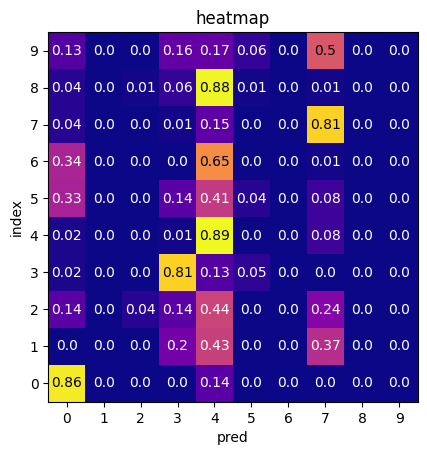

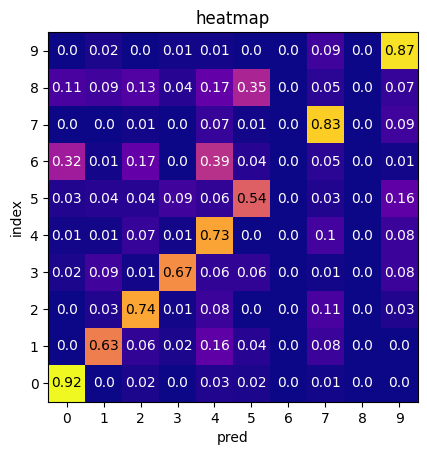

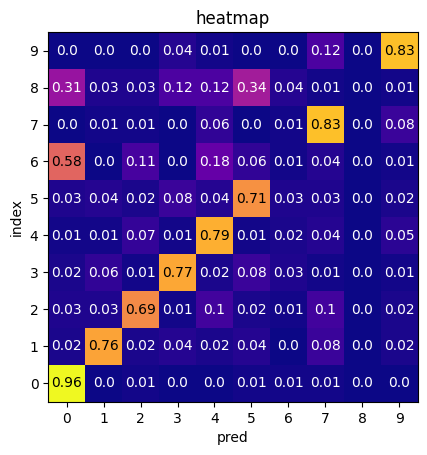

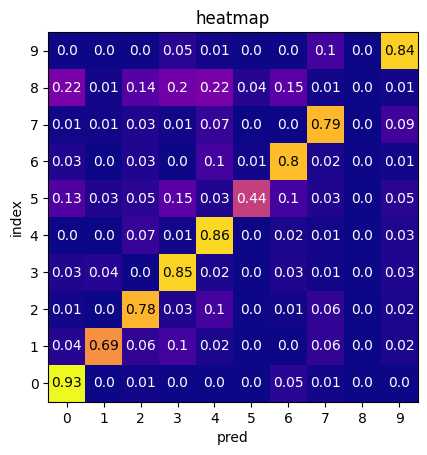

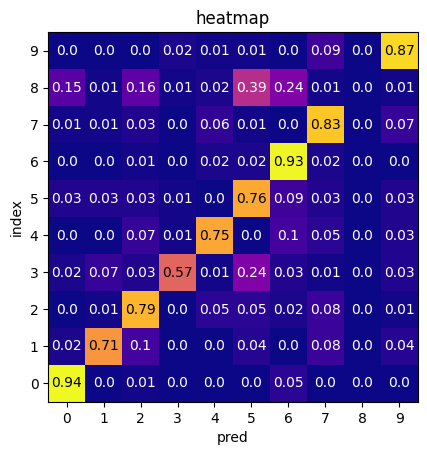

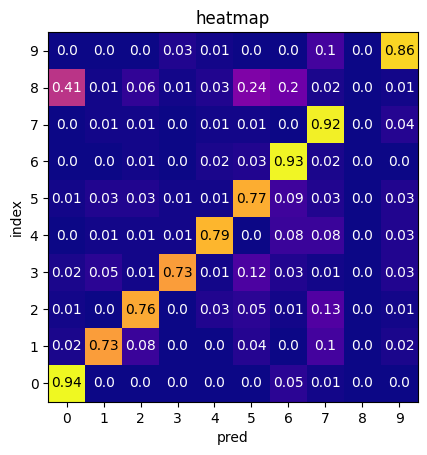

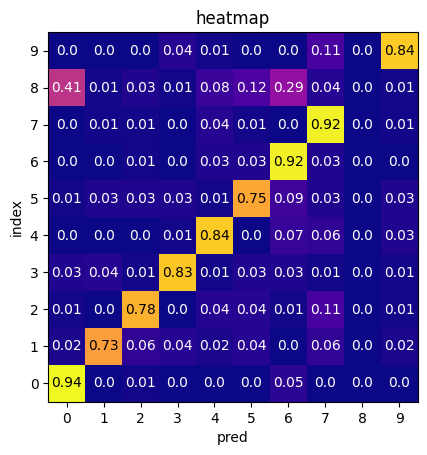

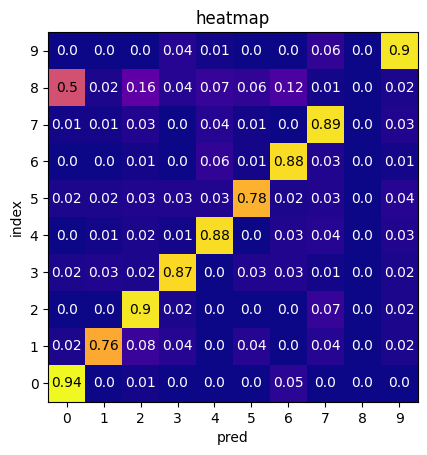

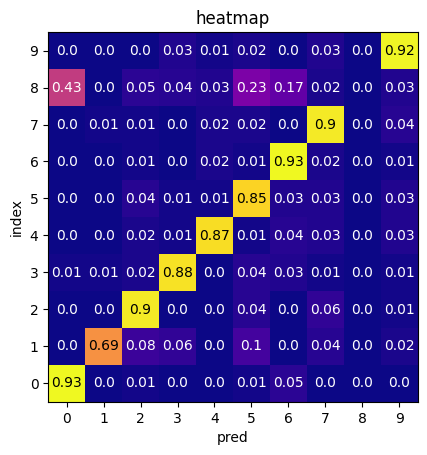

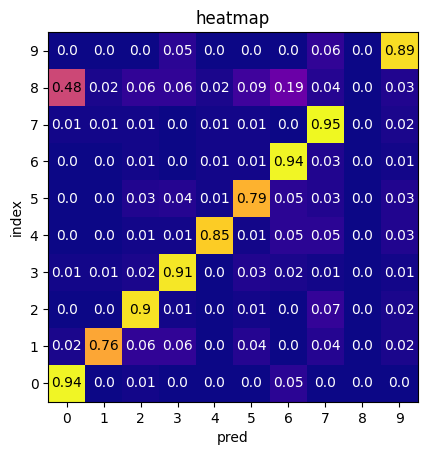

Training complete.


In [ ]:
fname = 'Net5x3'
net = Net5x3(bn=True)

trainer_5x3 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=50,
                 printing=False,
                 heatmap=False)

### trainer_3x5

In [ ]:
fname = 'Net3x5'
net = Net3x5(bn=True)

trainer_3x5 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=50,
                 printing=False,
                 heatmap=False)

Training complete.


### trainer_KaggleNet

In [ ]:
fname = 'KaggleNet'
net = KaggleNet()

trainer_KaggleNet = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=50,
                 printing=False,
                 heatmap=False)

Training complete.


### trainer_LeNet

In [ ]:
fname = 'LeNet'
net = LeNet()

trainer_LeNet = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=50,
                 printing=False,
                 heatmap=False)

Training complete.


### trainer_LeNetMax

In [ ]:
fname = 'LeNet_Max'
net = LeNet()
net.pool = nn.MaxPool2d(2)

trainer_LeNetMax = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=50,
                 printing=False,
                 heatmap=False)

Training complete.


### acc loss plot

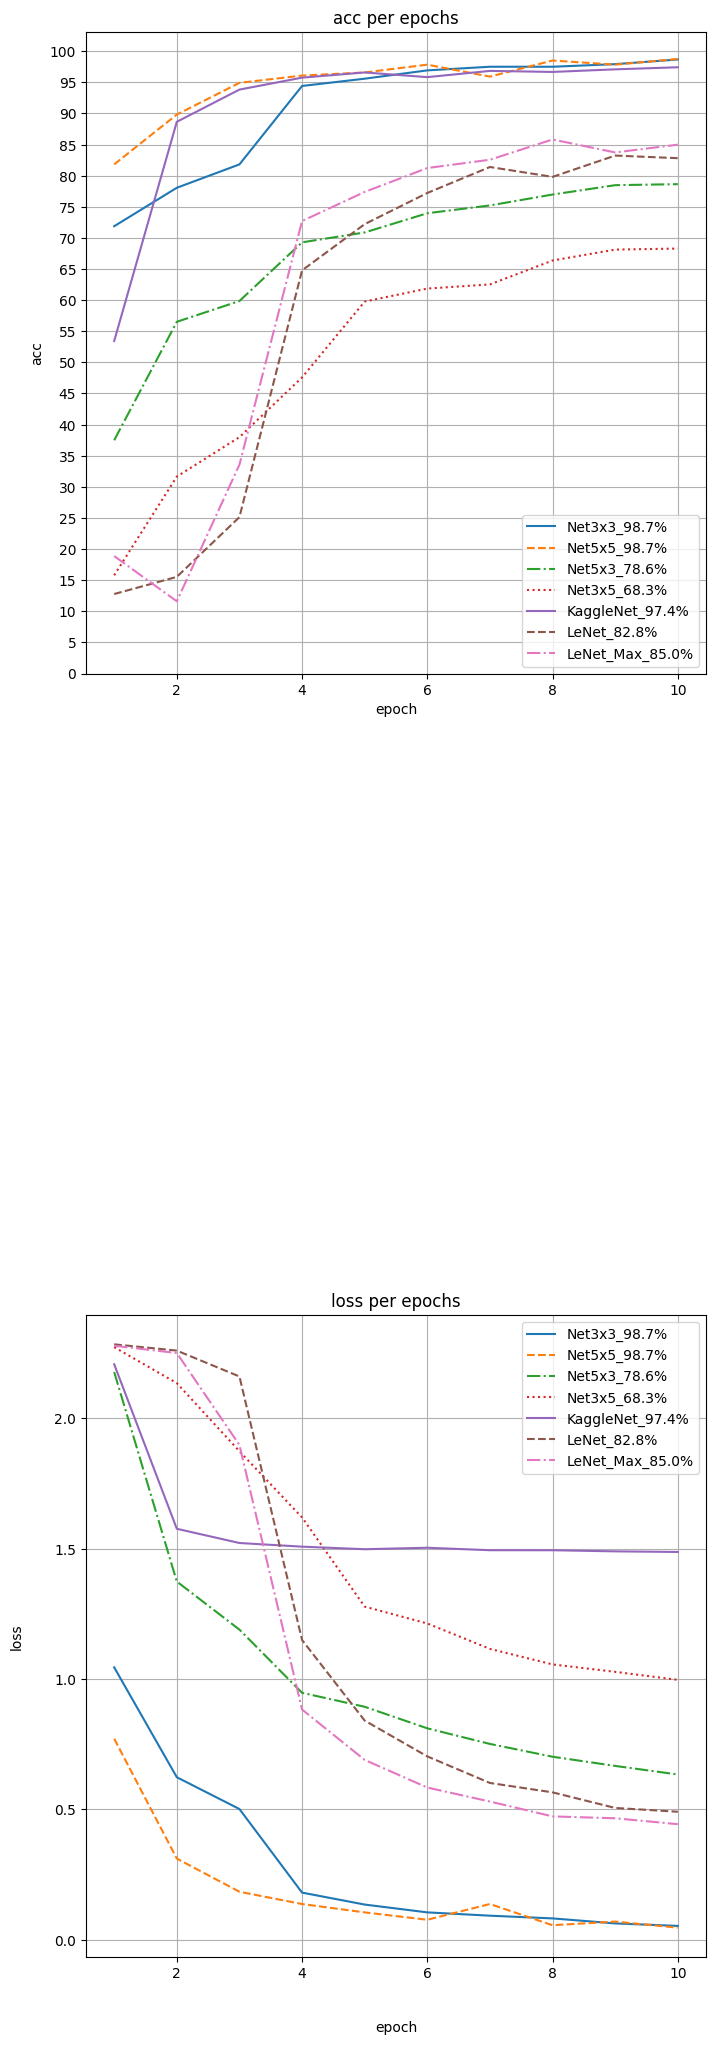

In [ ]:
plot = PlotMaker()
plot.make_arrs(name=trainer_3x3.output_fname, data=trainer_3x3.acc_loss_epoch)
plot.make_arrs(name=trainer_5x5.output_fname, data=trainer_5x5.acc_loss_epoch)
plot.make_arrs(name=trainer_5x3.output_fname, data=trainer_5x3.acc_loss_epoch)
plot.make_arrs(name=trainer_3x5.output_fname, data=trainer_3x5.acc_loss_epoch)
plot.make_arrs(name=trainer_KaggleNet.output_fname, data=trainer_KaggleNet.acc_loss_epoch)
plot.make_arrs(name=trainer_LeNet.output_fname, data=trainer_LeNet.acc_loss_epoch)
plot.make_arrs(name=trainer_LeNetMax.output_fname, data=trainer_LeNetMax.acc_loss_epoch)
plot.make_plot()

In [ ]:
class ModelAccLoss:
    def __init__(self, models, data_name, testloaders, printing=True):
        self.models = models
        self.data_name = data_name
        self.testloaders = testloaders
        self.printing = printing

        self.run()

    def cal_acc_loss(self):
        self.acc = {}
        self.loss = {}
        self.name = []

        for i in range(len(self.testloaders)):
            testloader = self.testloaders[i]

            inner_acc = np.zeros((1, len(self.models)))
            inner_loss = np.zeros((1, len(self.models)))
            inner_name = []

            if self.printing:
                print(f'{self.data_name[i]} ----------------------------\n')

            for j in range(len(self.models)):
                model = self.models[j]
                if self.printing:
                    print(f'{model.output_fname} --------------------------')

                tester = ModelTester(testloader=testloader,
                                    criterian=nn.CrossEntropyLoss(),
                                    net=model.net)

                inner_name.append(model.output_fname)
                inner_acc[:,j] = tester.acc
                inner_loss[:,j] = tester.test_loss

            self.acc[self.data_name[i]] = inner_acc.tolist()[0]
            self.loss[self.data_name[i]] = inner_loss.tolist()[0]
            self.name.append(inner_name)

        self.acc_df = pd.DataFrame(self.acc, index=self.name[0])
        self.loss_df = pd.DataFrame(self.loss, index=self.name[0])

    def plot_acc_loss(self):
        matplotlib.style.use('fivethirtyeight')
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
        plt.subplots_adjust(hspace=0.5)

        self.acc_df.plot(kind='bar', ax=axs[0])
        axs[0].set_title('acc')

        self.loss_df.plot(kind='bar', ax=axs[1])
        axs[1].set_title('loss')

        plt.show()

    def run(self):
        self.cal_acc_loss()
        self.plot_acc_loss()

### plot by models

total data ----------------------------

Net3x3_98.7% --------------------------
Test Error : 
 Accuracy : 66.3%, Avg loss: 2.18659933 

Net5x5_98.7% --------------------------
Test Error : 
 Accuracy : 72.3%, Avg loss: 2.14488561 

Net5x3_78.6% --------------------------
Test Error : 
 Accuracy : 56.9%, Avg loss: 1.45368482 

Net3x5_68.3% --------------------------
Test Error : 
 Accuracy : 43.4%, Avg loss: 1.74702345 

KaggleNet_97.4% --------------------------
Test Error : 
 Accuracy : 70.4%, Avg loss: 1.75422896 

LeNet_82.8% --------------------------
Test Error : 
 Accuracy : 52.4%, Avg loss: 1.92634664 

LeNet_Max_85.0% --------------------------
Test Error : 
 Accuracy : 59.4%, Avg loss: 1.55448295 

MNIST data ----------------------------

Net3x3_98.7% --------------------------
Test Error : 
 Accuracy : 59.9%, Avg loss: 2.62266312 

Net5x5_98.7% --------------------------
Test Error : 
 Accuracy : 68.2%, Avg loss: 2.3964298 

Net5x3_78.6% --------------------------
Test Error

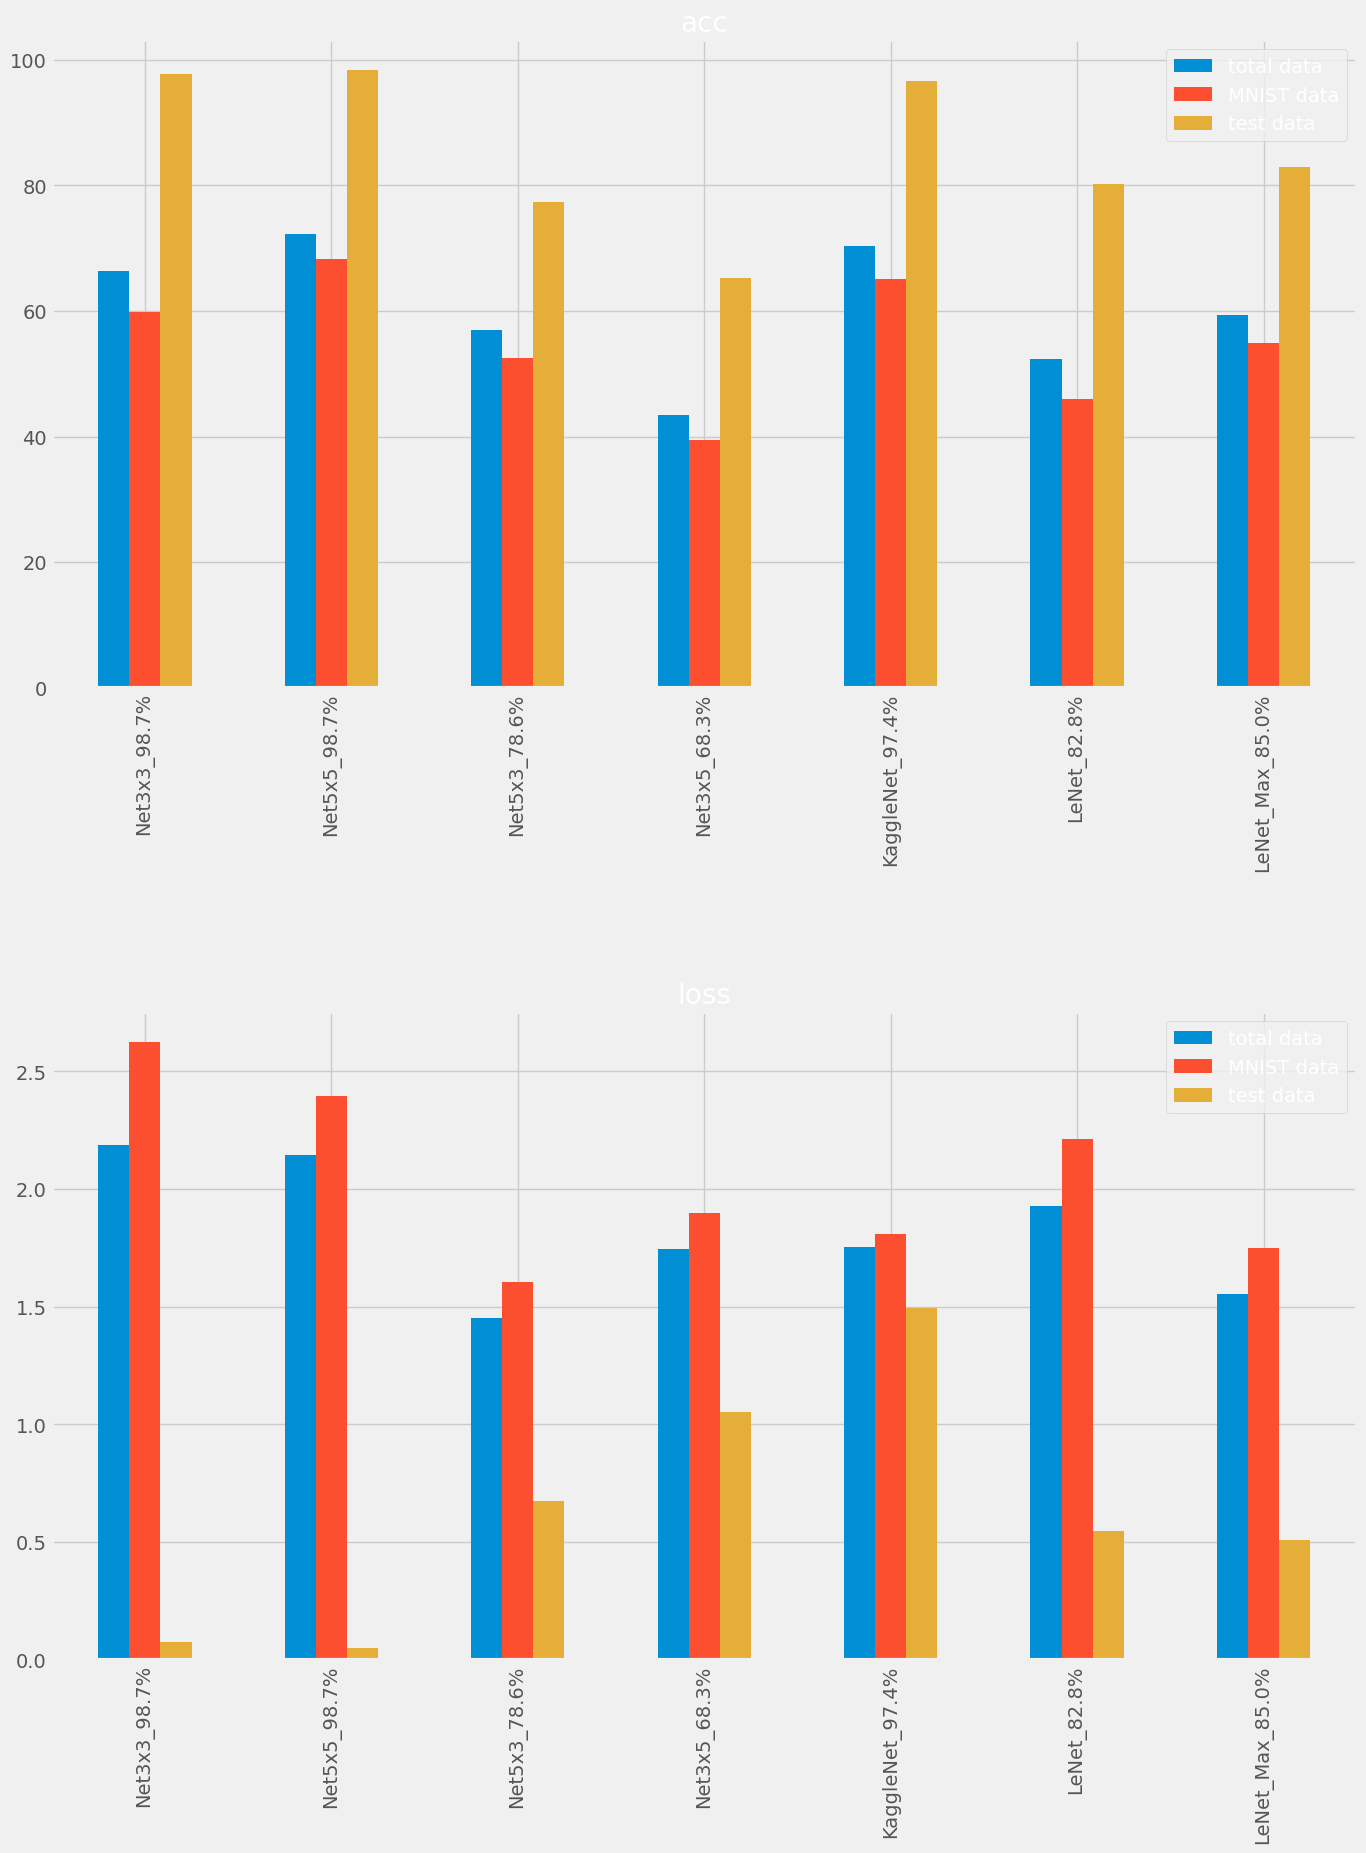

In [ ]:
models = [trainer_3x3, trainer_5x5, trainer_5x3, trainer_3x5, trainer_KaggleNet, trainer_LeNet, trainer_LeNetMax]
data_name=['total data', 'MNIST data', 'test data']
testloaders=[total_testloader, MNIST_testloader, testloader]

mal = ModelAccLoss(models=models, data_name=data_name, testloaders=testloaders)

### print test

Custom----------------------------------
Test Error : 
 Accuracy : 98.2%, Avg loss: 0.064314 

             0     1     2     3    4     5    6    7     8     9
num          0     1     2     3    4     5    6    7     8     9
accuracy  0.97  0.99  0.97  0.93  1.0  0.97  1.0  1.0  0.99  0.99


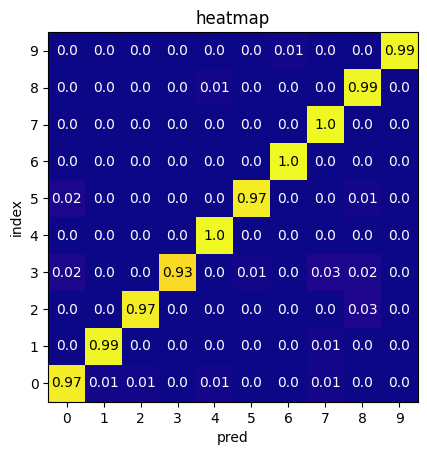

MNIST----------------------------------
Test Error : 
 Accuracy : 65.0%, Avg loss: 2.394991 

             0     1     2    3     4    5     6     7    8     9
num          0     1     2    3     4    5     6     7    8     9
accuracy  0.78  0.96  0.46  0.4  0.92  0.7  0.48  0.81  0.7  0.27


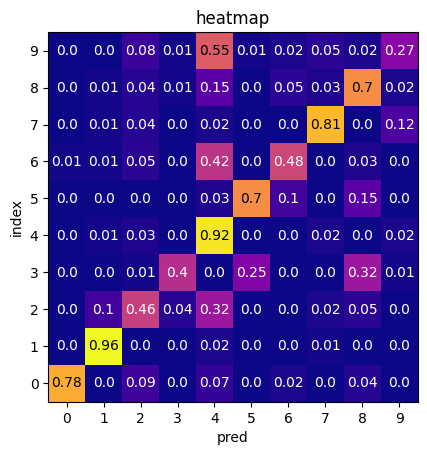

Total----------------------------------
Test Error : 
 Accuracy : 69.7%, Avg loss: 2.053288 

             0     1     2     3     4     5     6    7     8     9
num          0     1     2     3     4     5     6    7     8     9
accuracy  0.78  0.95  0.54  0.52  0.92  0.75  0.58  0.8  0.73  0.34


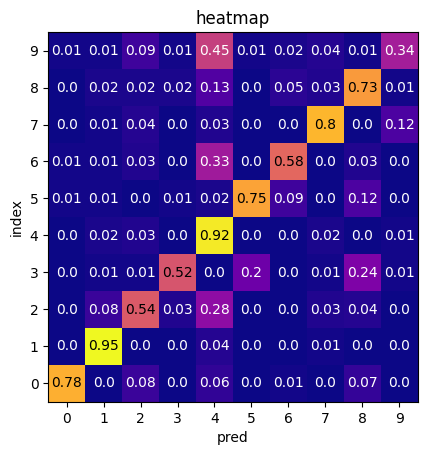

In [ ]:
print_test(trainer_3x3)

### save

In [ ]:
info = SaveInformation(fname = trainer.output_fname,
                      net=trainer.net,
                      txt=trainer.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
saved PyTorch Model


## 02 total Data

### dataset : 03 total dataset

### dataloader

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(total_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
vaildloader = torch.utils.data.DataLoader(total_vaildset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(total_testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
MNIST_testloader = torch.utils.data.DataLoader(MNIST_basic_testset, batch_size=batch_size, shuffle=True, num_workers=2)
total_testloader = torch.utils.data.DataLoader(total_testset, batch_size=batch_size, shuffle=True, num_workers=2)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=True, num_workers=2)

### train

### trainer_3x3

In [ ]:
fname = 'Net3x3'
net = Net3x3(bn=True)

trainer_3x3 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=False)

Epochs 1
-------------------------------

[1, 200] loss: 0.153 --------------- 4.632

[1, 400] loss: 0.078 --------------- 7.186

[1, 600] loss: 0.063 --------------- 9.417

[1, 800] loss: 0.054 --------------- 11.318

[1, 1000] loss: 0.050 --------------- 14.493

[1, 1200] loss: 0.049 --------------- 16.866

[1, 1400] loss: 0.045 --------------- 18.747

[1, 1600] loss: 0.045 --------------- 20.675

[1, 1800] loss: 0.043 --------------- 22.896

Test Error : 
 Accuracy : 86.052%, Avg loss: 0.41043119 

Epochs 2
-------------------------------

[2, 200] loss: 0.041 --------------- 4.870

[2, 400] loss: 0.041 --------------- 7.087

[2, 600] loss: 0.038 --------------- 8.807

[2, 800] loss: 0.039 --------------- 10.522

[2, 1000] loss: 0.039 --------------- 12.241

[2, 1200] loss: 0.039 --------------- 14.138

[2, 1400] loss: 0.036 --------------- 16.051

[2, 1600] loss: 0.036 --------------- 17.739

[2, 1800] loss: 0.036 --------------- 19.442

Test Error : 
 Accuracy : 87.330%, Avg loss:

### trainer_5x5

Epochs 1
-------------------------------

[1, 200] loss: 0.185 --------------- 2.525

[1, 400] loss: 0.096 --------------- 4.904

[1, 600] loss: 0.067 --------------- 7.024

[1, 800] loss: 0.057 --------------- 9.019

[1, 1000] loss: 0.050 --------------- 11.026

[1, 1200] loss: 0.049 --------------- 13.040

[1, 1400] loss: 0.044 --------------- 15.011

[1, 1600] loss: 0.042 --------------- 17.012

[1, 1800] loss: 0.040 --------------- 19.233

Test Error : 
 Accuracy : 92.401%, Avg loss: 0.40900291 



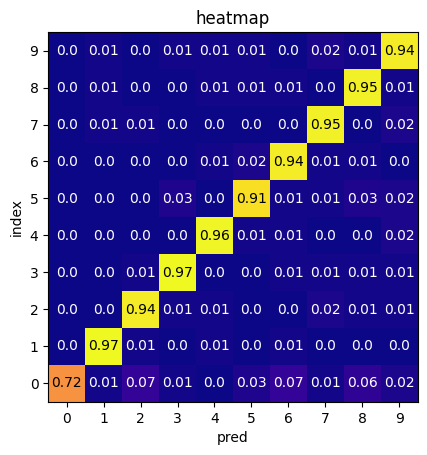

Epochs 2
-------------------------------

[2, 200] loss: 0.041 --------------- 2.082

[2, 400] loss: 0.039 --------------- 3.951

[2, 600] loss: 0.040 --------------- 5.778

[2, 800] loss: 0.035 --------------- 7.609

[2, 1000] loss: 0.036 --------------- 9.592

[2, 1200] loss: 0.036 --------------- 11.656

[2, 1400] loss: 0.035 --------------- 13.522

[2, 1600] loss: 0.033 --------------- 15.321

[2, 1800] loss: 0.034 --------------- 17.116

Test Error : 
 Accuracy : 95.985%, Avg loss: 0.32989637 



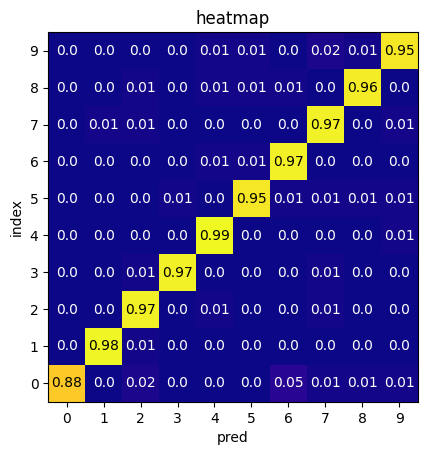

Epochs 3
-------------------------------

[3, 200] loss: 0.033 --------------- 2.164

[3, 400] loss: 0.032 --------------- 4.242

[3, 600] loss: 0.032 --------------- 6.187

[3, 800] loss: 0.032 --------------- 7.959

[3, 1000] loss: 0.032 --------------- 9.773

[3, 1200] loss: 0.032 --------------- 11.640

[3, 1400] loss: 0.032 --------------- 13.498

[3, 1600] loss: 0.032 --------------- 15.413

[3, 1800] loss: 0.031 --------------- 17.524

Test Error : 
 Accuracy : 96.318%, Avg loss: 0.32679823 



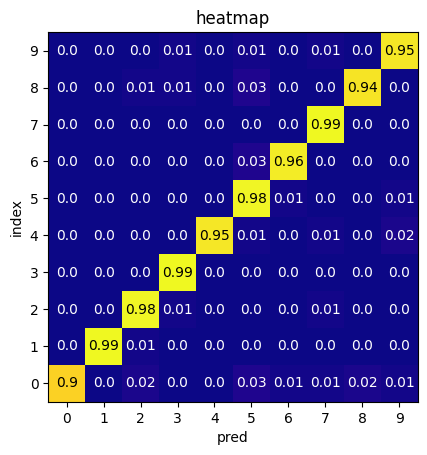

Epochs 4
-------------------------------

[4, 200] loss: 0.031 --------------- 2.109

[4, 400] loss: 0.030 --------------- 3.973

[4, 600] loss: 0.029 --------------- 5.818

[4, 800] loss: 0.031 --------------- 7.669

[4, 1000] loss: 0.028 --------------- 9.549

[4, 1200] loss: 0.031 --------------- 11.659

[4, 1400] loss: 0.029 --------------- 13.606

[4, 1600] loss: 0.030 --------------- 15.493

[4, 1800] loss: 0.029 --------------- 17.356

Test Error : 
 Accuracy : 96.513%, Avg loss: 0.31926733 



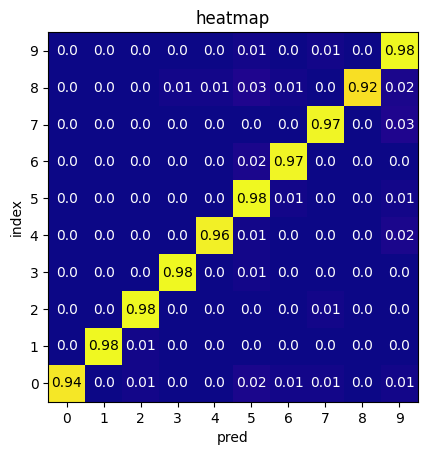

Epochs 5
-------------------------------

[5, 200] loss: 0.030 --------------- 2.183

[5, 400] loss: 0.028 --------------- 4.353

[5, 600] loss: 0.029 --------------- 6.350

[5, 800] loss: 0.030 --------------- 8.179

[5, 1000] loss: 0.027 --------------- 9.979

[5, 1200] loss: 0.029 --------------- 11.756

[5, 1400] loss: 0.028 --------------- 13.610

[5, 1600] loss: 0.029 --------------- 15.728

[5, 1800] loss: 0.027 --------------- 17.790

Test Error : 
 Accuracy : 97.847%, Avg loss: 0.29307095 



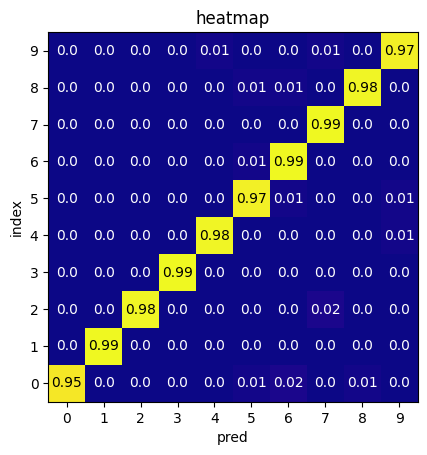

Epochs 6
-------------------------------

[6, 200] loss: 0.026 --------------- 2.100

[6, 400] loss: 0.027 --------------- 4.012

[6, 600] loss: 0.028 --------------- 5.903

[6, 800] loss: 0.028 --------------- 7.865

[6, 1000] loss: 0.028 --------------- 9.967

[6, 1200] loss: 0.028 --------------- 12.064

[6, 1400] loss: 0.027 --------------- 14.059

[6, 1600] loss: 0.028 --------------- 16.061

[6, 1800] loss: 0.028 --------------- 18.002

Test Error : 
 Accuracy : 97.583%, Avg loss: 0.29601090 



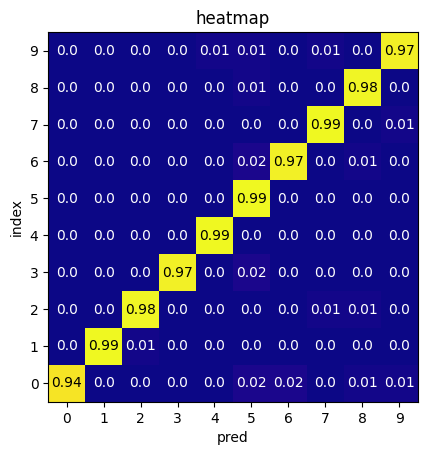

Epochs 7
-------------------------------

[7, 200] loss: 0.027 --------------- 2.232

[7, 400] loss: 0.026 --------------- 4.429

[7, 600] loss: 0.028 --------------- 6.491

[7, 800] loss: 0.027 --------------- 8.416

[7, 1000] loss: 0.026 --------------- 10.335

[7, 1200] loss: 0.027 --------------- 12.144

[7, 1400] loss: 0.027 --------------- 14.013

[7, 1600] loss: 0.026 --------------- 15.992

[7, 1800] loss: 0.026 --------------- 18.204

Test Error : 
 Accuracy : 97.944%, Avg loss: 0.28544732 



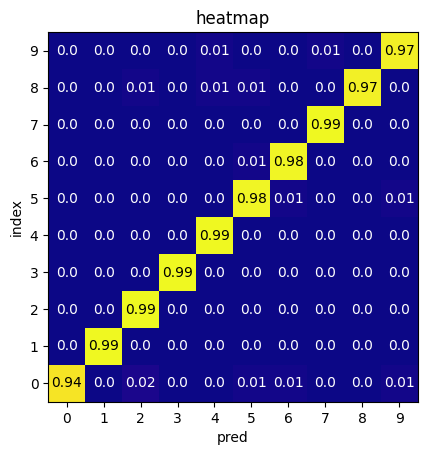

Epochs 8
-------------------------------

[8, 200] loss: 0.026 --------------- 2.220

[8, 400] loss: 0.026 --------------- 4.123

[8, 600] loss: 0.027 --------------- 6.002

[8, 800] loss: 0.025 --------------- 7.891

[8, 1000] loss: 0.026 --------------- 9.962

[8, 1200] loss: 0.025 --------------- 11.958

[8, 1400] loss: 0.027 --------------- 13.809

[8, 1600] loss: 0.026 --------------- 15.674

[8, 1800] loss: 0.027 --------------- 17.484

Test Error : 
 Accuracy : 98.013%, Avg loss: 0.29052791 



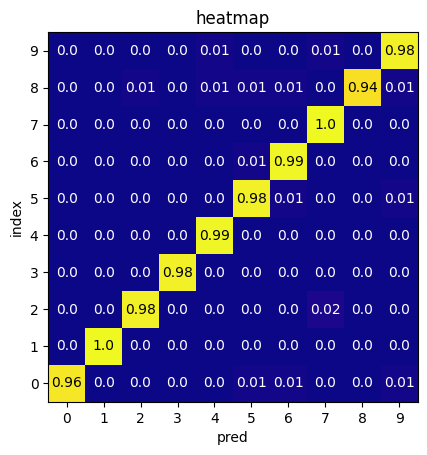

Epochs 9
-------------------------------

[9, 200] loss: 0.026 --------------- 2.137

[9, 400] loss: 0.026 --------------- 4.219

[9, 600] loss: 0.026 --------------- 6.177

[9, 800] loss: 0.025 --------------- 8.067

[9, 1000] loss: 0.026 --------------- 9.907

[9, 1200] loss: 0.026 --------------- 11.718

[9, 1400] loss: 0.027 --------------- 13.568

[9, 1600] loss: 0.010 --------------- 15.517

[9, 1800] loss: 0.004 --------------- 17.537

Test Error : 
 Accuracy : 98.527%, Avg loss: 0.05406422 



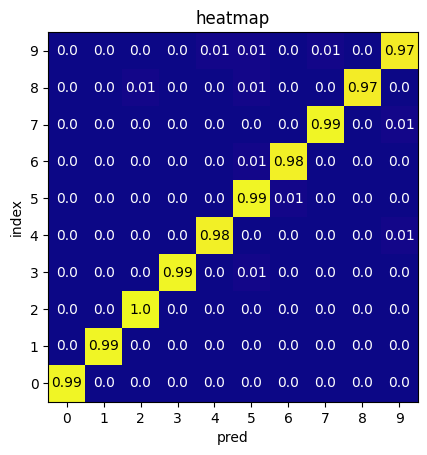

Epochs 10
-------------------------------

[10, 200] loss: 0.003 --------------- 2.094

[10, 400] loss: 0.004 --------------- 3.908

[10, 600] loss: 0.003 --------------- 5.789

[10, 800] loss: 0.003 --------------- 7.600

[10, 1000] loss: 0.003 --------------- 9.536

[10, 1200] loss: 0.003 --------------- 11.649

[10, 1400] loss: 0.004 --------------- 13.579

[10, 1600] loss: 0.004 --------------- 15.477

[10, 1800] loss: 0.003 --------------- 17.356

Test Error : 
 Accuracy : 98.708%, Avg loss: 0.05113028 



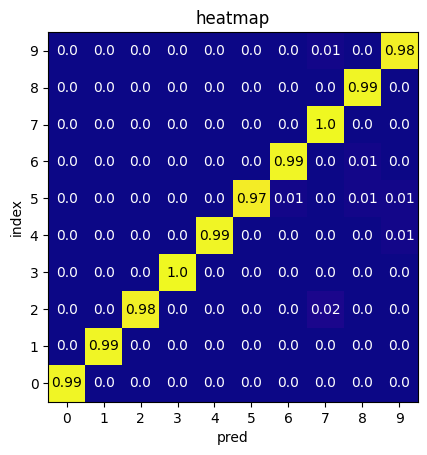

Training complete.


In [ ]:
fname = 'Net5x5'
net = Net5x5(bn=True)

trainer_5x5 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=True)

### trainer_KaggleNet

Epochs 1
-------------------------------

[1, 200] loss: 0.228 --------------- 10.091

[1, 400] loss: 0.216 --------------- 19.115

[1, 600] loss: 0.201 --------------- 28.978

[1, 800] loss: 0.192 --------------- 38.951

[1, 1000] loss: 0.185 --------------- 48.678

[1, 1200] loss: 0.181 --------------- 57.295

[1, 1400] loss: 0.179 --------------- 66.674

[1, 1600] loss: 0.177 --------------- 76.316

[1, 1800] loss: 0.174 --------------- 85.843

Test Error : 
 Accuracy : 82.801%, Avg loss: 1.66673404 



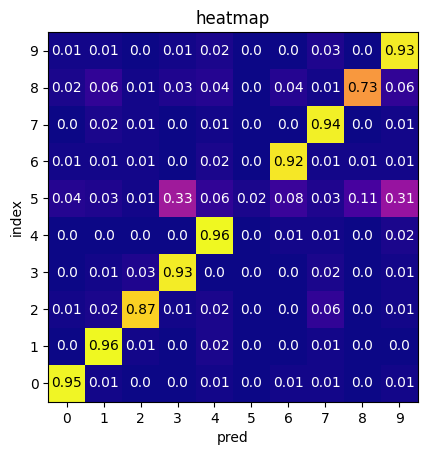

Epochs 2
-------------------------------

[2, 200] loss: 0.159 --------------- 9.578

[2, 400] loss: 0.154 --------------- 17.844

[2, 600] loss: 0.154 --------------- 26.905

[2, 800] loss: 0.153 --------------- 35.796

[2, 1000] loss: 0.152 --------------- 43.606

[2, 1200] loss: 0.152 --------------- 52.461

[2, 1400] loss: 0.151 --------------- 61.503

[2, 1600] loss: 0.151 --------------- 69.277



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f20bba6d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f20bba6d5a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[2, 1800] loss: 0.151 --------------- 79.051

Test Error : 
 Accuracy : 95.638%, Avg loss: 1.50575409 



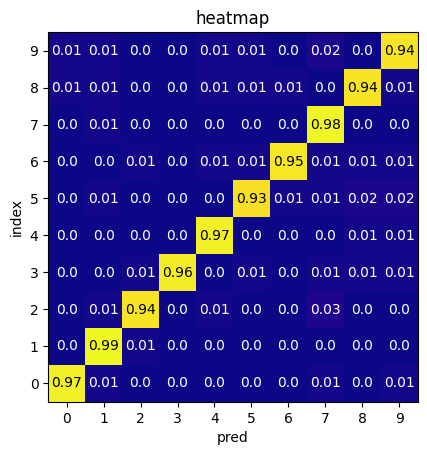

Epochs 3
-------------------------------

[3, 200] loss: 0.150 --------------- 9.731

[3, 400] loss: 0.150 --------------- 18.903

[3, 600] loss: 0.150 --------------- 28.037

[3, 800] loss: 0.150 --------------- 36.372

[3, 1000] loss: 0.150 --------------- 45.345

[3, 1200] loss: 0.150 --------------- 53.928

[3, 1400] loss: 0.149 --------------- 62.021

[3, 1600] loss: 0.150 --------------- 70.895

[3, 1800] loss: 0.149 --------------- 79.589

Test Error : 
 Accuracy : 96.735%, Avg loss: 1.49524814 



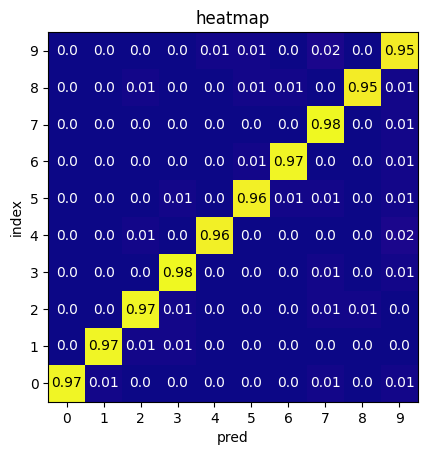

Epochs 4
-------------------------------

[4, 200] loss: 0.149 --------------- 9.463

[4, 400] loss: 0.149 --------------- 17.512

[4, 600] loss: 0.149 --------------- 26.400

[4, 800] loss: 0.149 --------------- 35.873

[4, 1000] loss: 0.149 --------------- 43.811

[4, 1200] loss: 0.149 --------------- 52.754

[4, 1400] loss: 0.149 --------------- 61.560

[4, 1600] loss: 0.149 --------------- 69.607

[4, 1800] loss: 0.149 --------------- 78.626

Test Error : 
 Accuracy : 97.749%, Avg loss: 1.48450126 



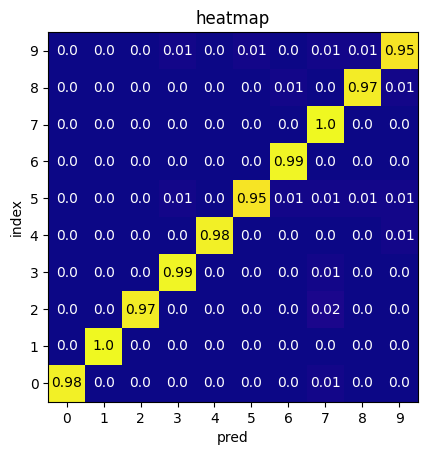

Epochs 5
-------------------------------

[5, 200] loss: 0.148 --------------- 9.352

[5, 400] loss: 0.148 --------------- 18.353

[5, 600] loss: 0.148 --------------- 26.338

[5, 800] loss: 0.149 --------------- 35.162

[5, 1000] loss: 0.148 --------------- 44.198

[5, 1200] loss: 0.148 --------------- 52.069

[5, 1400] loss: 0.148 --------------- 61.255

[5, 1600] loss: 0.149 --------------- 70.046

[5, 1800] loss: 0.148 --------------- 78.045

Test Error : 
 Accuracy : 98.152%, Avg loss: 1.47989423 



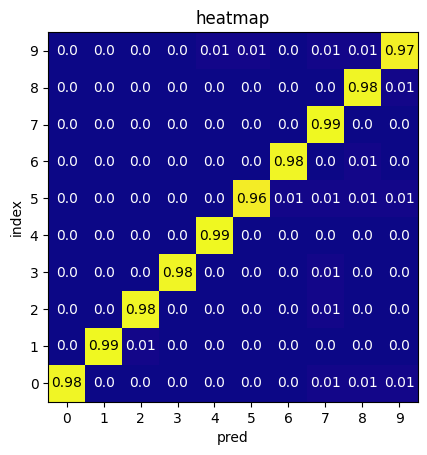

Epochs 6
-------------------------------

[6, 200] loss: 0.148 --------------- 8.274

[6, 400] loss: 0.148 --------------- 17.350

[6, 600] loss: 0.148 --------------- 26.306

[6, 800] loss: 0.148 --------------- 34.211

[6, 1000] loss: 0.148 --------------- 43.473

[6, 1200] loss: 0.148 --------------- 52.440

[6, 1400] loss: 0.148 --------------- 60.257

[6, 1600] loss: 0.148 --------------- 69.204

[6, 1800] loss: 0.148 --------------- 77.935

Test Error : 
 Accuracy : 98.347%, Avg loss: 1.47800301 



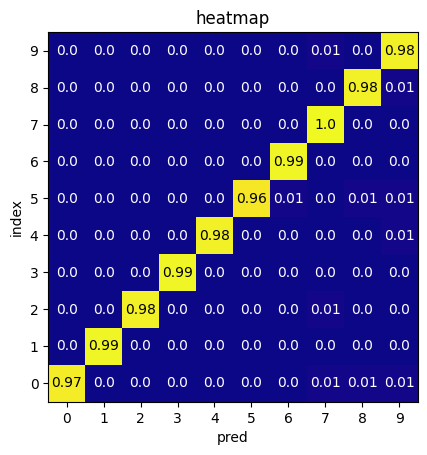

Epochs 7
-------------------------------

[7, 200] loss: 0.148 --------------- 9.691

[7, 400] loss: 0.148 --------------- 17.828

[7, 600] loss: 0.148 --------------- 26.760

[7, 800] loss: 0.148 --------------- 35.794

[7, 1000] loss: 0.148 --------------- 43.694

[7, 1200] loss: 0.148 --------------- 52.672

[7, 1400] loss: 0.148 --------------- 61.746

[7, 1600] loss: 0.148 --------------- 69.660

[7, 1800] loss: 0.148 --------------- 78.589

Test Error : 
 Accuracy : 98.500%, Avg loss: 1.47699506 



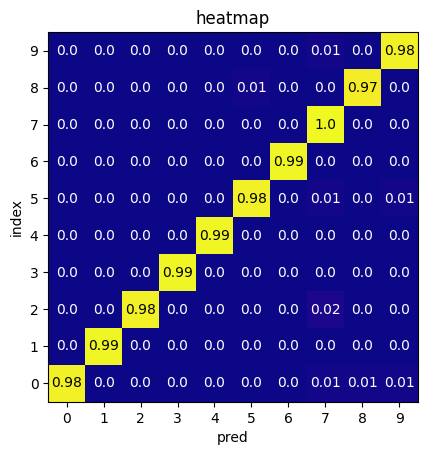

Epochs 8
-------------------------------

[8, 200] loss: 0.148 --------------- 9.477

[8, 400] loss: 0.148 --------------- 18.195

[8, 600] loss: 0.147 --------------- 26.434

[8, 800] loss: 0.148 --------------- 35.256

[8, 1000] loss: 0.148 --------------- 44.247

[8, 1200] loss: 0.148 --------------- 52.051

[8, 1400] loss: 0.148 --------------- 60.865

[8, 1600] loss: 0.148 --------------- 69.806

[8, 1800] loss: 0.148 --------------- 77.636

Test Error : 
 Accuracy : 98.472%, Avg loss: 1.47685750 



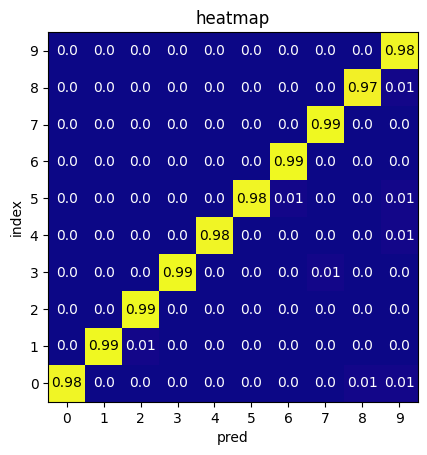

Epochs 9
-------------------------------

[9, 200] loss: 0.147 --------------- 8.264

[9, 400] loss: 0.147 --------------- 17.225

[9, 600] loss: 0.148 --------------- 25.943

[9, 800] loss: 0.148 --------------- 33.894

[9, 1000] loss: 0.147 --------------- 42.732

[9, 1200] loss: 0.147 --------------- 51.930

[9, 1400] loss: 0.148 --------------- 59.721

[9, 1600] loss: 0.147 --------------- 68.867

[9, 1800] loss: 0.148 --------------- 77.977

Test Error : 
 Accuracy : 97.861%, Avg loss: 1.48298882 



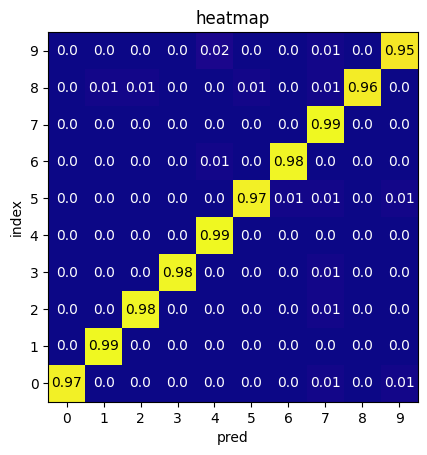

Epochs 10
-------------------------------

[10, 200] loss: 0.147 --------------- 9.474

[10, 400] loss: 0.147 --------------- 17.429

[10, 600] loss: 0.148 --------------- 26.281

[10, 800] loss: 0.147 --------------- 35.100

[10, 1000] loss: 0.147 --------------- 43.223

[10, 1200] loss: 0.147 --------------- 52.181

[10, 1400] loss: 0.148 --------------- 61.301

[10, 1600] loss: 0.147 --------------- 69.209

[10, 1800] loss: 0.147 --------------- 78.304

Test Error : 
 Accuracy : 98.680%, Avg loss: 1.47492398 



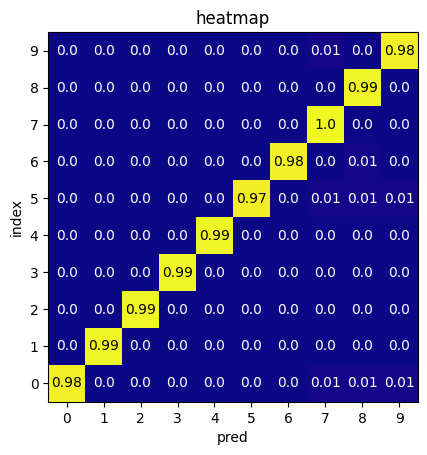

Training complete.


In [ ]:
fname = 'KaggleNet'
net = KaggleNet()

trainer_KaggleNet = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=True)

### acc loss plot

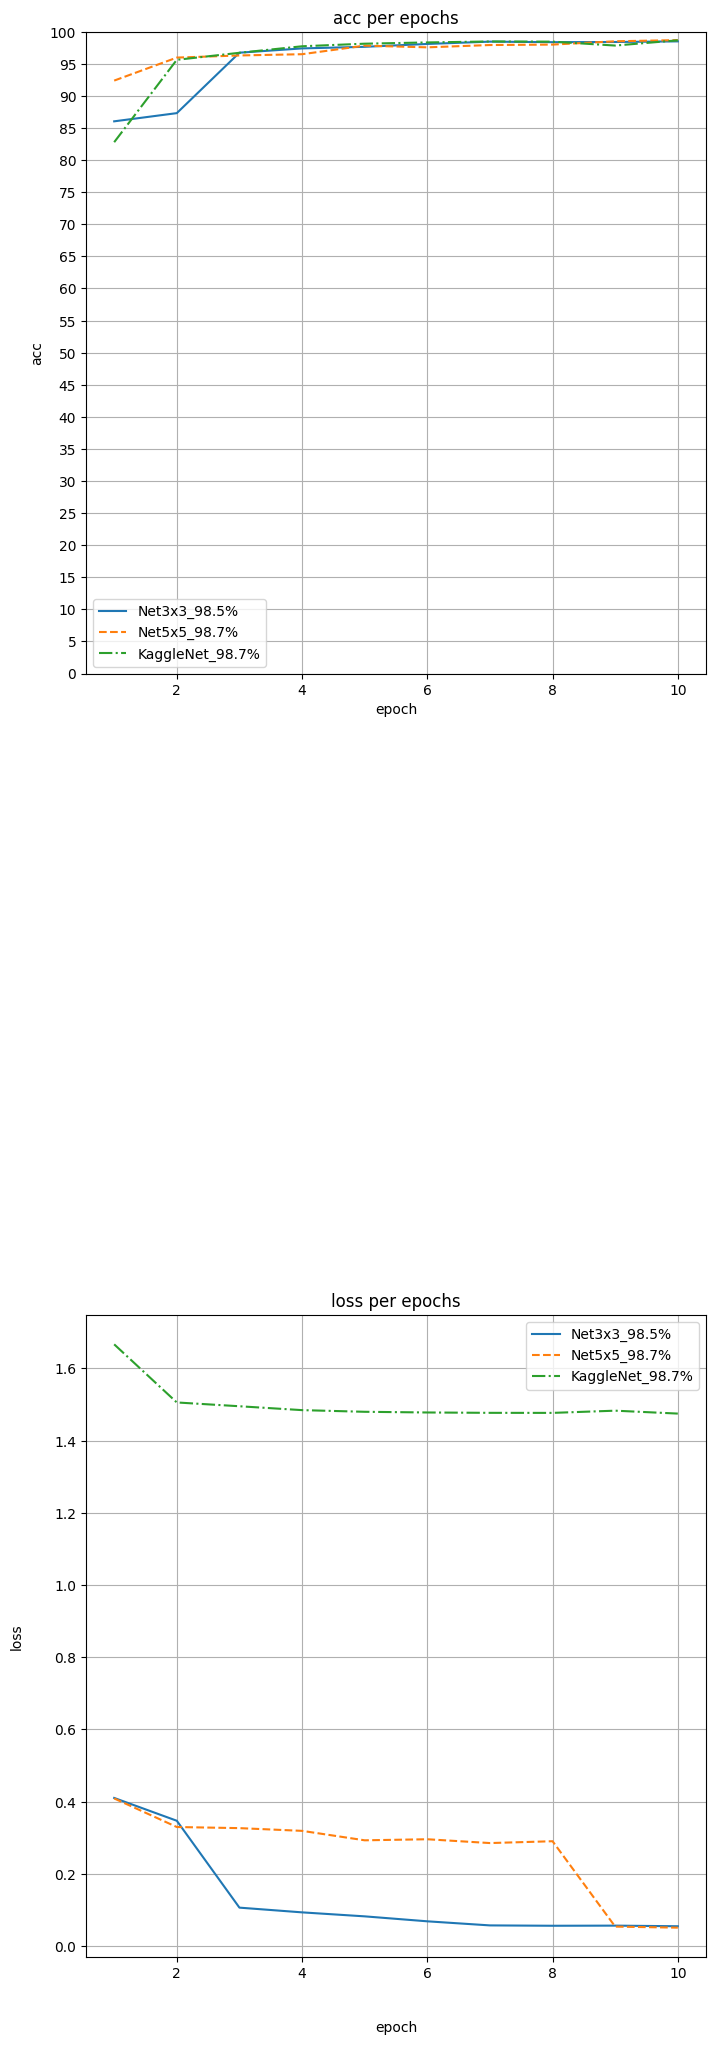

In [ ]:
matplotlib.style.use('default')

plot = PlotMaker()

plot.make_arrs(name=trainer_3x3.output_fname, data=trainer_3x3.acc_loss_epoch)
plot.make_arrs(name=trainer_5x5.output_fname, data=trainer_5x5.acc_loss_epoch)
plot.make_arrs(name=trainer_KaggleNet.output_fname, data=trainer_KaggleNet.acc_loss_epoch)
plot.make_plot()

### plot by models

total data ----------------------------

Net3x3_98.5% --------------------------
Test Error : 
 Accuracy : 98.4%, Avg loss: 0.05991178 

Net5x5_98.7% --------------------------
Test Error : 
 Accuracy : 98.3%, Avg loss: 0.06143913 

KaggleNet_98.7% --------------------------
Test Error : 
 Accuracy : 98.5%, Avg loss: 1.47606959 

MNIST data ----------------------------

Net3x3_98.5% --------------------------
Test Error : 
 Accuracy : 98.7%, Avg loss: 0.04650043 

Net5x5_98.7% --------------------------
Test Error : 
 Accuracy : 98.9%, Avg loss: 0.04101832 

KaggleNet_98.7% --------------------------
Test Error : 
 Accuracy : 99.1%, Avg loss: 1.47039077 

custom data ----------------------------

Net3x3_98.5% --------------------------
Test Error : 
 Accuracy : 98.2%, Avg loss: 0.0745092 

Net5x5_98.7% --------------------------
Test Error : 
 Accuracy : 98.3%, Avg loss: 0.07493288 

KaggleNet_98.7% --------------------------
Test Error : 
 Accuracy : 96.7%, Avg loss: 1.49480169 

test

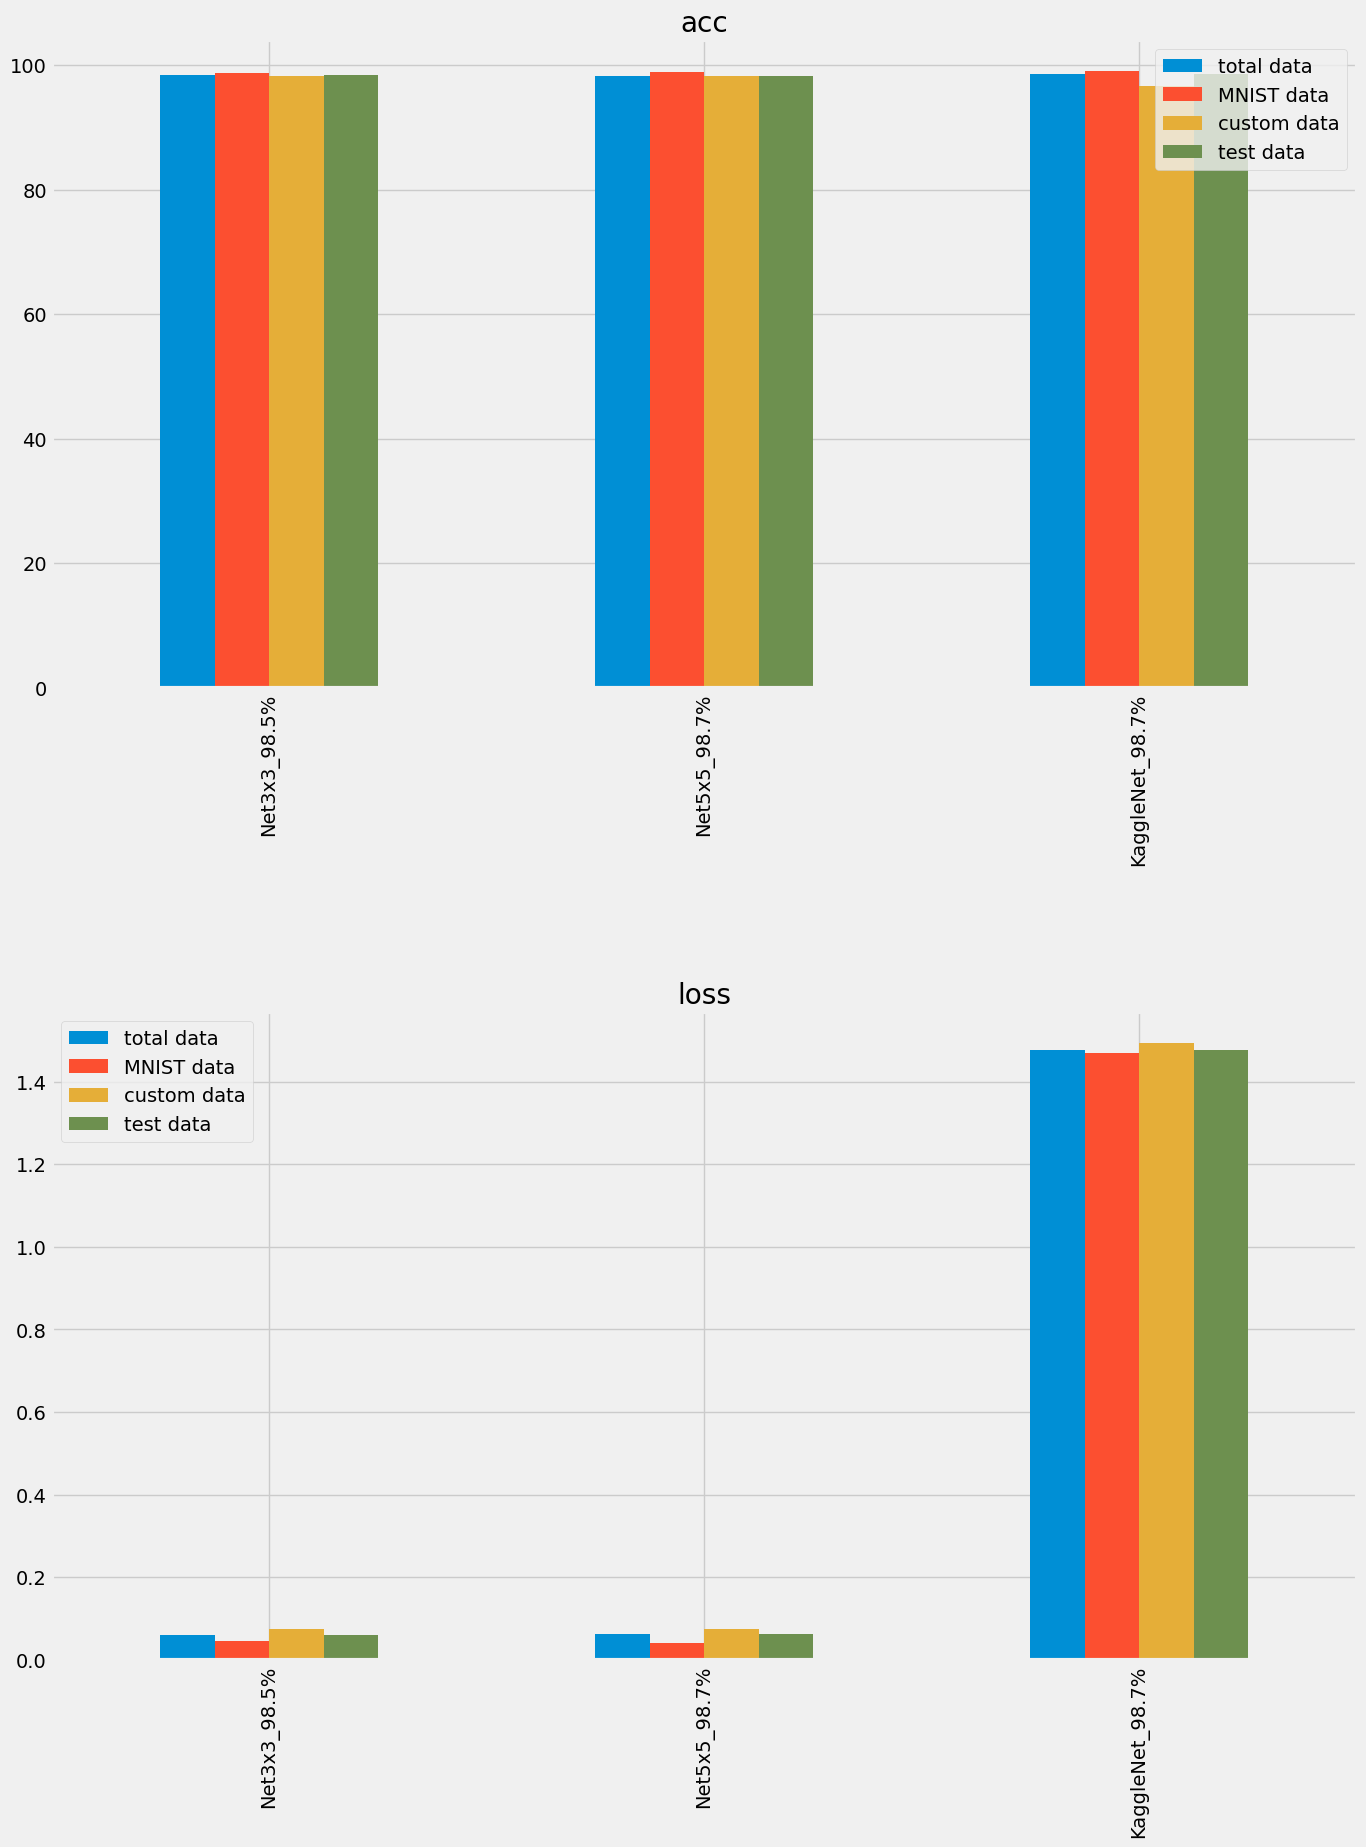

In [ ]:
models = [trainer_3x3, trainer_5x5, trainer_KaggleNet]
data_name=['total data', 'MNIST data', 'custom data', 'test data']
testloaders=[total_testloader, MNIST_testloader, custom_testloader, testloader]
mal = ModelAccLoss(models=models, data_name=data_name, testloaders=testloaders)

save

In [ ]:
info = SaveInformation(fname = trainer_3x3.output_fname,
                      net=trainer_3x3.net,
                      txt=trainer_3x3.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


In [ ]:
info = SaveInformation(fname = trainer_5x5.output_fname,
                      net=trainer_5x5.net,
                      txt=trainer_5x5.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


In [ ]:
info = SaveInformation(fname = trainer_KaggleNet.output_fname,
                      net=trainer_KaggleNet.net,
                      txt=trainer_KaggleNet.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


## 03 total Data

### dataset : 03 total dataset

### dataloader

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(t_nss_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
vaildloader = torch.utils.data.DataLoader(t_nss_vaildset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(t_nss_testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
MNIST_testloader = torch.utils.data.DataLoader(MNIST_basic_testset, batch_size=batch_size, shuffle=True, num_workers=2)
total_testloader = torch.utils.data.DataLoader(total_testset, batch_size=batch_size, shuffle=True, num_workers=2)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=True, num_workers=2)

### train

### trainer_3x3

In [ ]:
fname = 'Net3x3'
net = Net3x3(bn=True)

trainer_3x3 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=False)

Epochs 1
-------------------------------

[1, 200] loss: 0.191 --------------- 2.017

[1, 400] loss: 0.101 --------------- 3.648

[1, 600] loss: 0.055 --------------- 5.404

Test Error : 
 Accuracy : 86.733%, Avg loss: 0.46006793 

Epochs 2
-------------------------------

[2, 200] loss: 0.041 --------------- 1.906

[2, 400] loss: 0.033 --------------- 3.490

[2, 600] loss: 0.029 --------------- 5.098

Test Error : 
 Accuracy : 93.200%, Avg loss: 0.23633183 

Epochs 3
-------------------------------

[3, 200] loss: 0.024 --------------- 1.788

[3, 400] loss: 0.021 --------------- 3.410

[3, 600] loss: 0.019 --------------- 5.030

Test Error : 
 Accuracy : 94.577%, Avg loss: 0.18496502 

Epochs 4
-------------------------------

[4, 200] loss: 0.017 --------------- 2.044

[4, 400] loss: 0.014 --------------- 3.785

[4, 600] loss: 0.016 --------------- 5.329

Test Error : 
 Accuracy : 95.369%, Avg loss: 0.14164283 

Epochs 5
-------------------------------

[5, 200] loss: 0.014 ---------

### trainer_5x5

Epochs 1
-------------------------------

[1, 200] loss: 0.182 --------------- 2.031

[1, 400] loss: 0.090 --------------- 3.957

[1, 600] loss: 0.058 --------------- 5.734

Test Error : 
 Accuracy : 87.151%, Avg loss: 0.46014766 



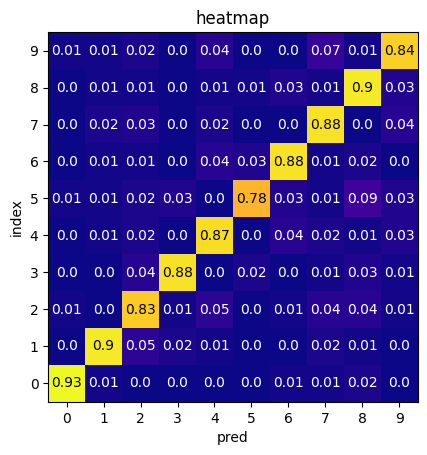

Epochs 2
-------------------------------

[2, 200] loss: 0.042 --------------- 2.350

[2, 400] loss: 0.032 --------------- 4.173

[2, 600] loss: 0.027 --------------- 5.855

Test Error : 
 Accuracy : 92.991%, Avg loss: 0.23403169 



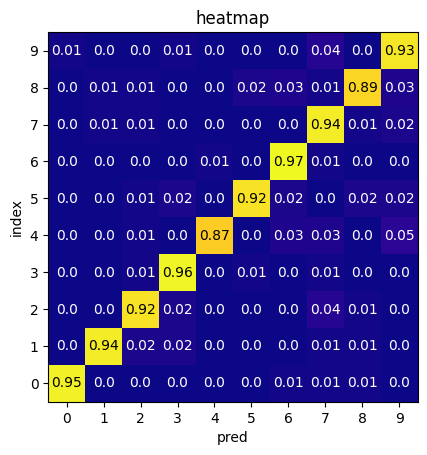

Epochs 3
-------------------------------

[3, 200] loss: 0.021 --------------- 2.006

[3, 400] loss: 0.022 --------------- 3.712

[3, 600] loss: 0.018 --------------- 5.425

Test Error : 
 Accuracy : 95.494%, Avg loss: 0.16102853 



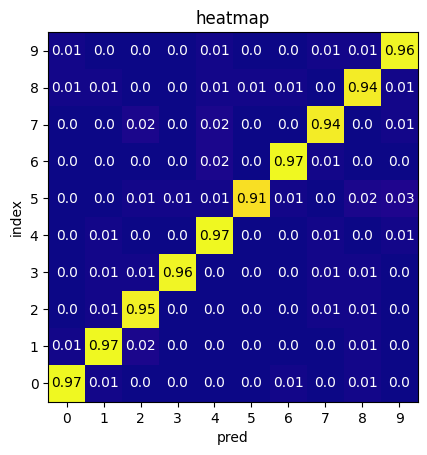

Epochs 4
-------------------------------

[4, 200] loss: 0.015 --------------- 2.187

[4, 400] loss: 0.016 --------------- 3.924

[4, 600] loss: 0.013 --------------- 5.650

Test Error : 
 Accuracy : 95.870%, Avg loss: 0.13720423 



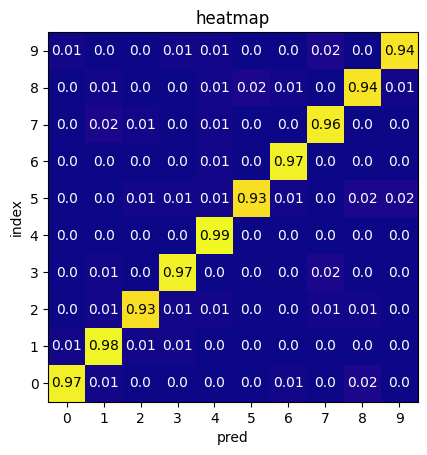

Epochs 5
-------------------------------

[5, 200] loss: 0.012 --------------- 1.993

[5, 400] loss: 0.011 --------------- 3.753

[5, 600] loss: 0.010 --------------- 5.682

Test Error : 
 Accuracy : 95.745%, Avg loss: 0.13663677 



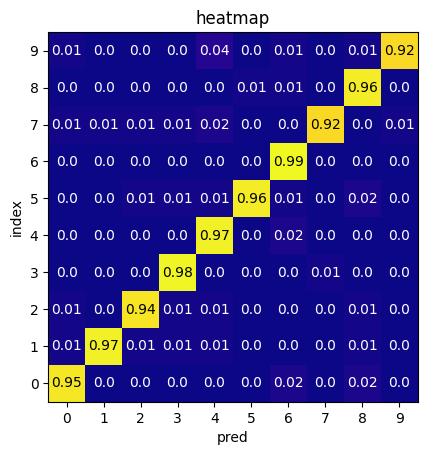

Epochs 6
-------------------------------

[6, 200] loss: 0.009 --------------- 2.032

[6, 400] loss: 0.009 --------------- 3.827

[6, 600] loss: 0.008 --------------- 5.593

Test Error : 
 Accuracy : 97.038%, Avg loss: 0.10578307 



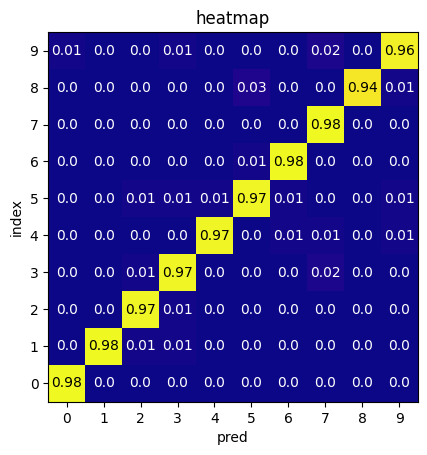

Epochs 7
-------------------------------

[7, 200] loss: 0.007 --------------- 2.047

[7, 400] loss: 0.008 --------------- 3.845

[7, 600] loss: 0.007 --------------- 5.926

Test Error : 
 Accuracy : 96.871%, Avg loss: 0.10121132 



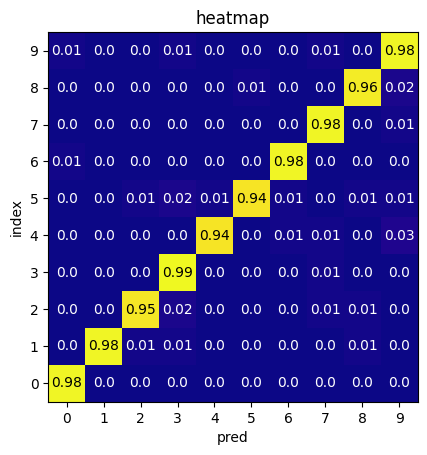

Epochs 8
-------------------------------

[8, 200] loss: 0.006 --------------- 1.889

[8, 400] loss: 0.006 --------------- 3.636

[8, 600] loss: 0.006 --------------- 5.295

Test Error : 
 Accuracy : 96.996%, Avg loss: 0.10936416 



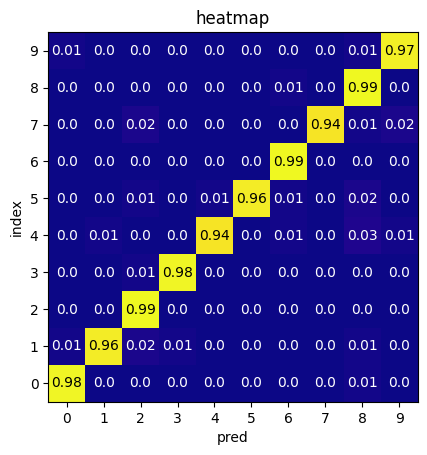

Epochs 9
-------------------------------

[9, 200] loss: 0.005 --------------- 1.934

[9, 400] loss: 0.005 --------------- 3.748

[9, 600] loss: 0.005 --------------- 5.772

Test Error : 
 Accuracy : 98.164%, Avg loss: 0.07227138 



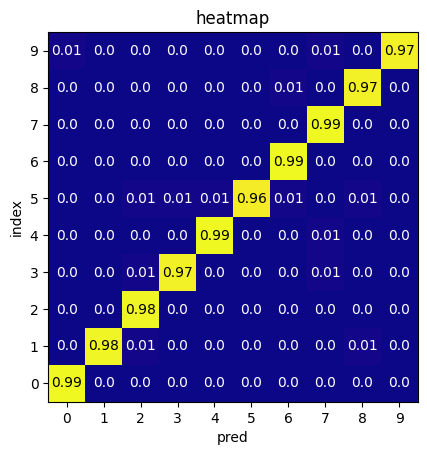

Epochs 10
-------------------------------

[10, 200] loss: 0.004 --------------- 1.963

[10, 400] loss: 0.005 --------------- 3.726

[10, 600] loss: 0.005 --------------- 5.479

Test Error : 
 Accuracy : 97.831%, Avg loss: 0.08988422 



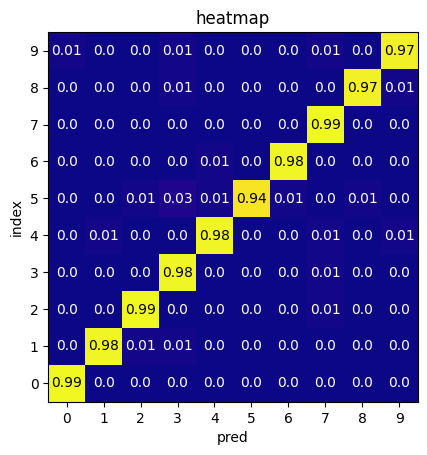

Training complete.


In [ ]:
fname = 'Net5x5'
net = Net5x5(bn=True)

trainer_5x5 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=True)

### trainer_KaggleNet

Epochs 1
-------------------------------

[1, 200] loss: 0.229 --------------- 10.008

[1, 400] loss: 0.223 --------------- 18.298

[1, 600] loss: 0.212 --------------- 28.118

Test Error : 
 Accuracy : 52.149%, Avg loss: 2.05080905 



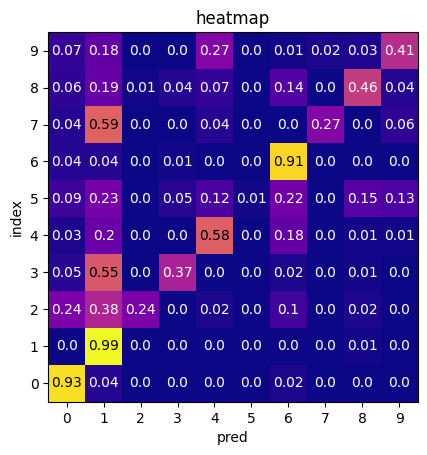

Epochs 2
-------------------------------

[2, 200] loss: 0.174 --------------- 9.344

[2, 400] loss: 0.161 --------------- 17.962

[2, 600] loss: 0.157 --------------- 25.780

Test Error : 
 Accuracy : 91.030%, Avg loss: 1.55649491 



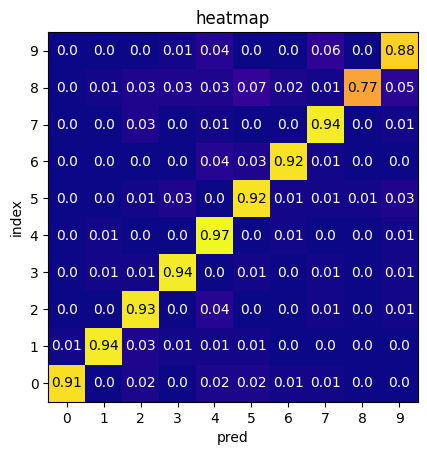

Epochs 3
-------------------------------

[3, 200] loss: 0.155 --------------- 9.098

[3, 400] loss: 0.154 --------------- 18.077

[3, 600] loss: 0.153 --------------- 25.828

Test Error : 
 Accuracy : 93.700%, Avg loss: 1.52720349 



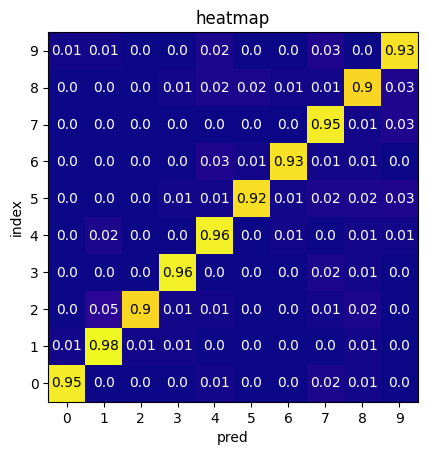

Epochs 4
-------------------------------

[4, 200] loss: 0.153 --------------- 8.758

[4, 400] loss: 0.152 --------------- 17.486

[4, 600] loss: 0.152 --------------- 25.287

Test Error : 
 Accuracy : 95.578%, Avg loss: 1.50875834 



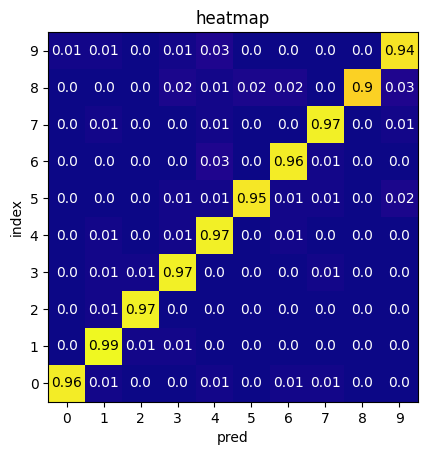

Epochs 5
-------------------------------

[5, 200] loss: 0.151 --------------- 8.184

[5, 400] loss: 0.150 --------------- 16.749

[5, 600] loss: 0.150 --------------- 25.250

Test Error : 
 Accuracy : 96.245%, Avg loss: 1.50025571 



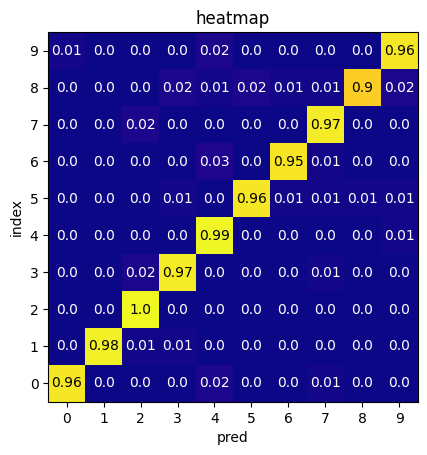

Epochs 6
-------------------------------

[6, 200] loss: 0.150 --------------- 8.089

[6, 400] loss: 0.150 --------------- 16.604

[6, 600] loss: 0.150 --------------- 25.316

Test Error : 
 Accuracy : 95.661%, Avg loss: 1.50465402 



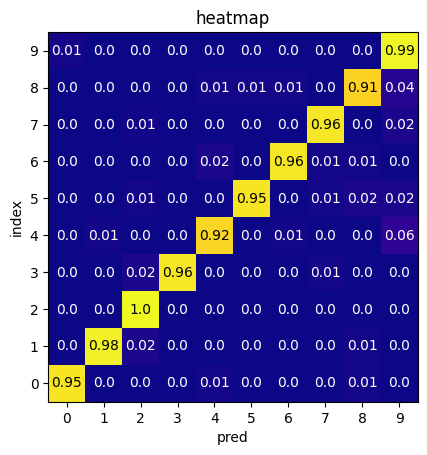

Epochs 7
-------------------------------

[7, 200] loss: 0.150 --------------- 8.701

[7, 400] loss: 0.149 --------------- 16.636

[7, 600] loss: 0.149 --------------- 25.286

Test Error : 
 Accuracy : 96.662%, Avg loss: 1.49541494 



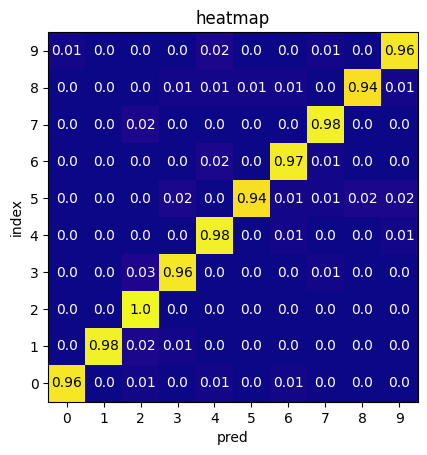

Epochs 8
-------------------------------

[8, 200] loss: 0.149 --------------- 9.067

[8, 400] loss: 0.149 --------------- 16.923

[8, 600] loss: 0.149 --------------- 25.604

Test Error : 
 Accuracy : 97.413%, Avg loss: 1.48806676 



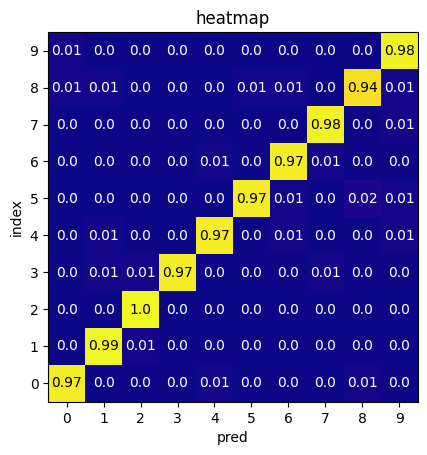

Epochs 9
-------------------------------

[9, 200] loss: 0.149 --------------- 9.130

[9, 400] loss: 0.149 --------------- 17.215

[9, 600] loss: 0.149 --------------- 25.683

Test Error : 
 Accuracy : 97.747%, Avg loss: 1.48440653 



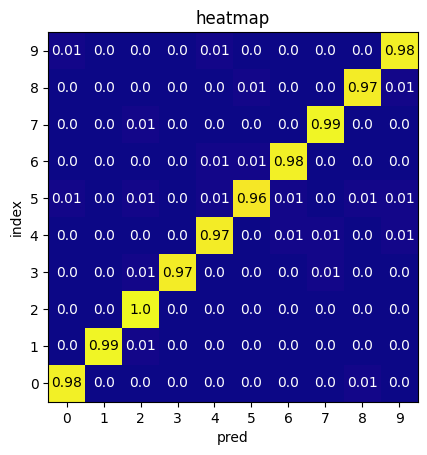

Epochs 10
-------------------------------

[10, 200] loss: 0.148 --------------- 9.175

[10, 400] loss: 0.148 --------------- 17.954

[10, 600] loss: 0.148 --------------- 25.605

Test Error : 
 Accuracy : 97.831%, Avg loss: 1.48330554 



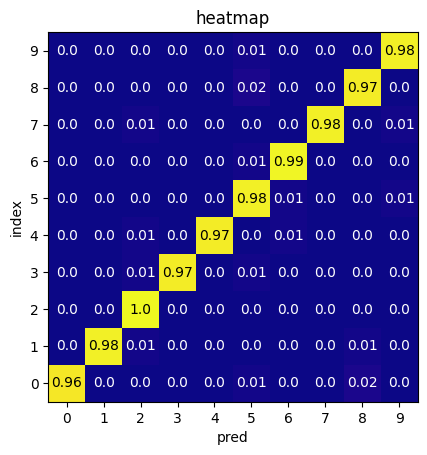

Training complete.


In [ ]:
fname = 'KaggleNet'
net = KaggleNet()

trainer_KaggleNet = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=10,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=True)

### acc loss plot

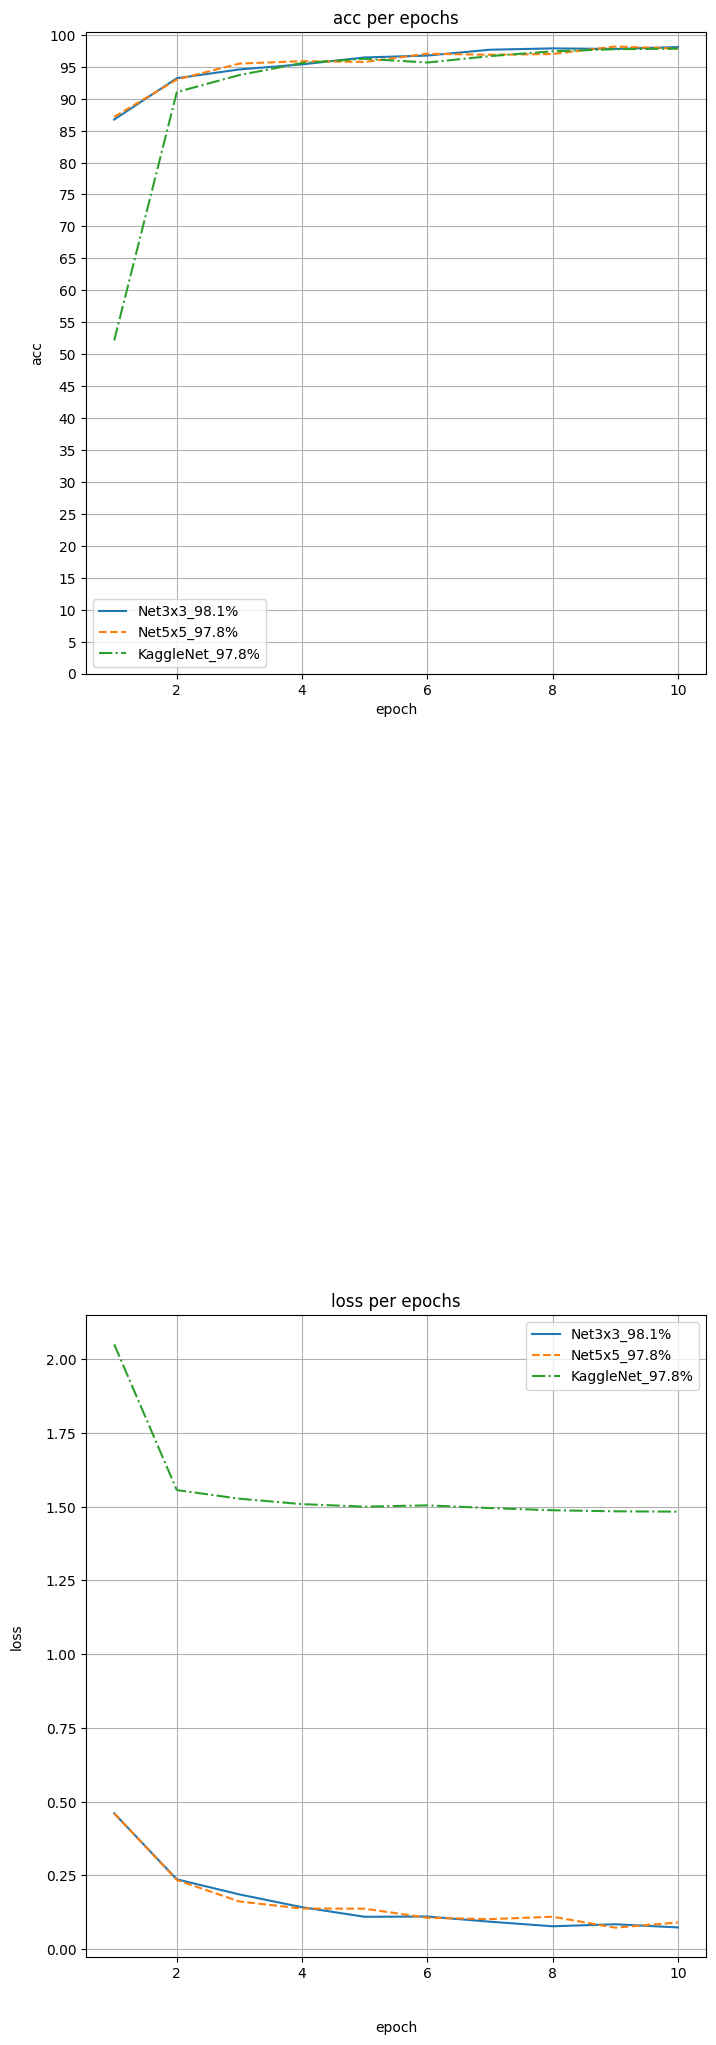

In [ ]:
matplotlib.style.use('default')

plot = PlotMaker()

plot.make_arrs(name=trainer_3x3.output_fname, data=trainer_3x3.acc_loss_epoch)
plot.make_arrs(name=trainer_5x5.output_fname, data=trainer_5x5.acc_loss_epoch)
plot.make_arrs(name=trainer_KaggleNet.output_fname, data=trainer_KaggleNet.acc_loss_epoch)
plot.make_plot()

### plot by models

total data ----------------------------

Net3x3_98.1% --------------------------
Test Error : 
 Accuracy : 97.5%, Avg loss: 0.09866408 

Net5x5_97.8% --------------------------
Test Error : 
 Accuracy : 97.7%, Avg loss: 0.09235191 

KaggleNet_97.8% --------------------------
Test Error : 
 Accuracy : 97.6%, Avg loss: 1.48477396 

MNIST data ----------------------------

Net3x3_98.1% --------------------------
Test Error : 
 Accuracy : 97.3%, Avg loss: 0.09299938 

Net5x5_97.8% --------------------------
Test Error : 
 Accuracy : 97.3%, Avg loss: 0.09615074 

KaggleNet_97.8% --------------------------
Test Error : 
 Accuracy : 97.8%, Avg loss: 1.48425745 

custom data ----------------------------

Net3x3_98.1% --------------------------
Test Error : 
 Accuracy : 99.5%, Avg loss: 0.03665108 

Net5x5_97.8% --------------------------
Test Error : 
 Accuracy : 99.1%, Avg loss: 0.04248303 

KaggleNet_97.8% --------------------------
Test Error : 
 Accuracy : 98.3%, Avg loss: 1.48035538 

tes

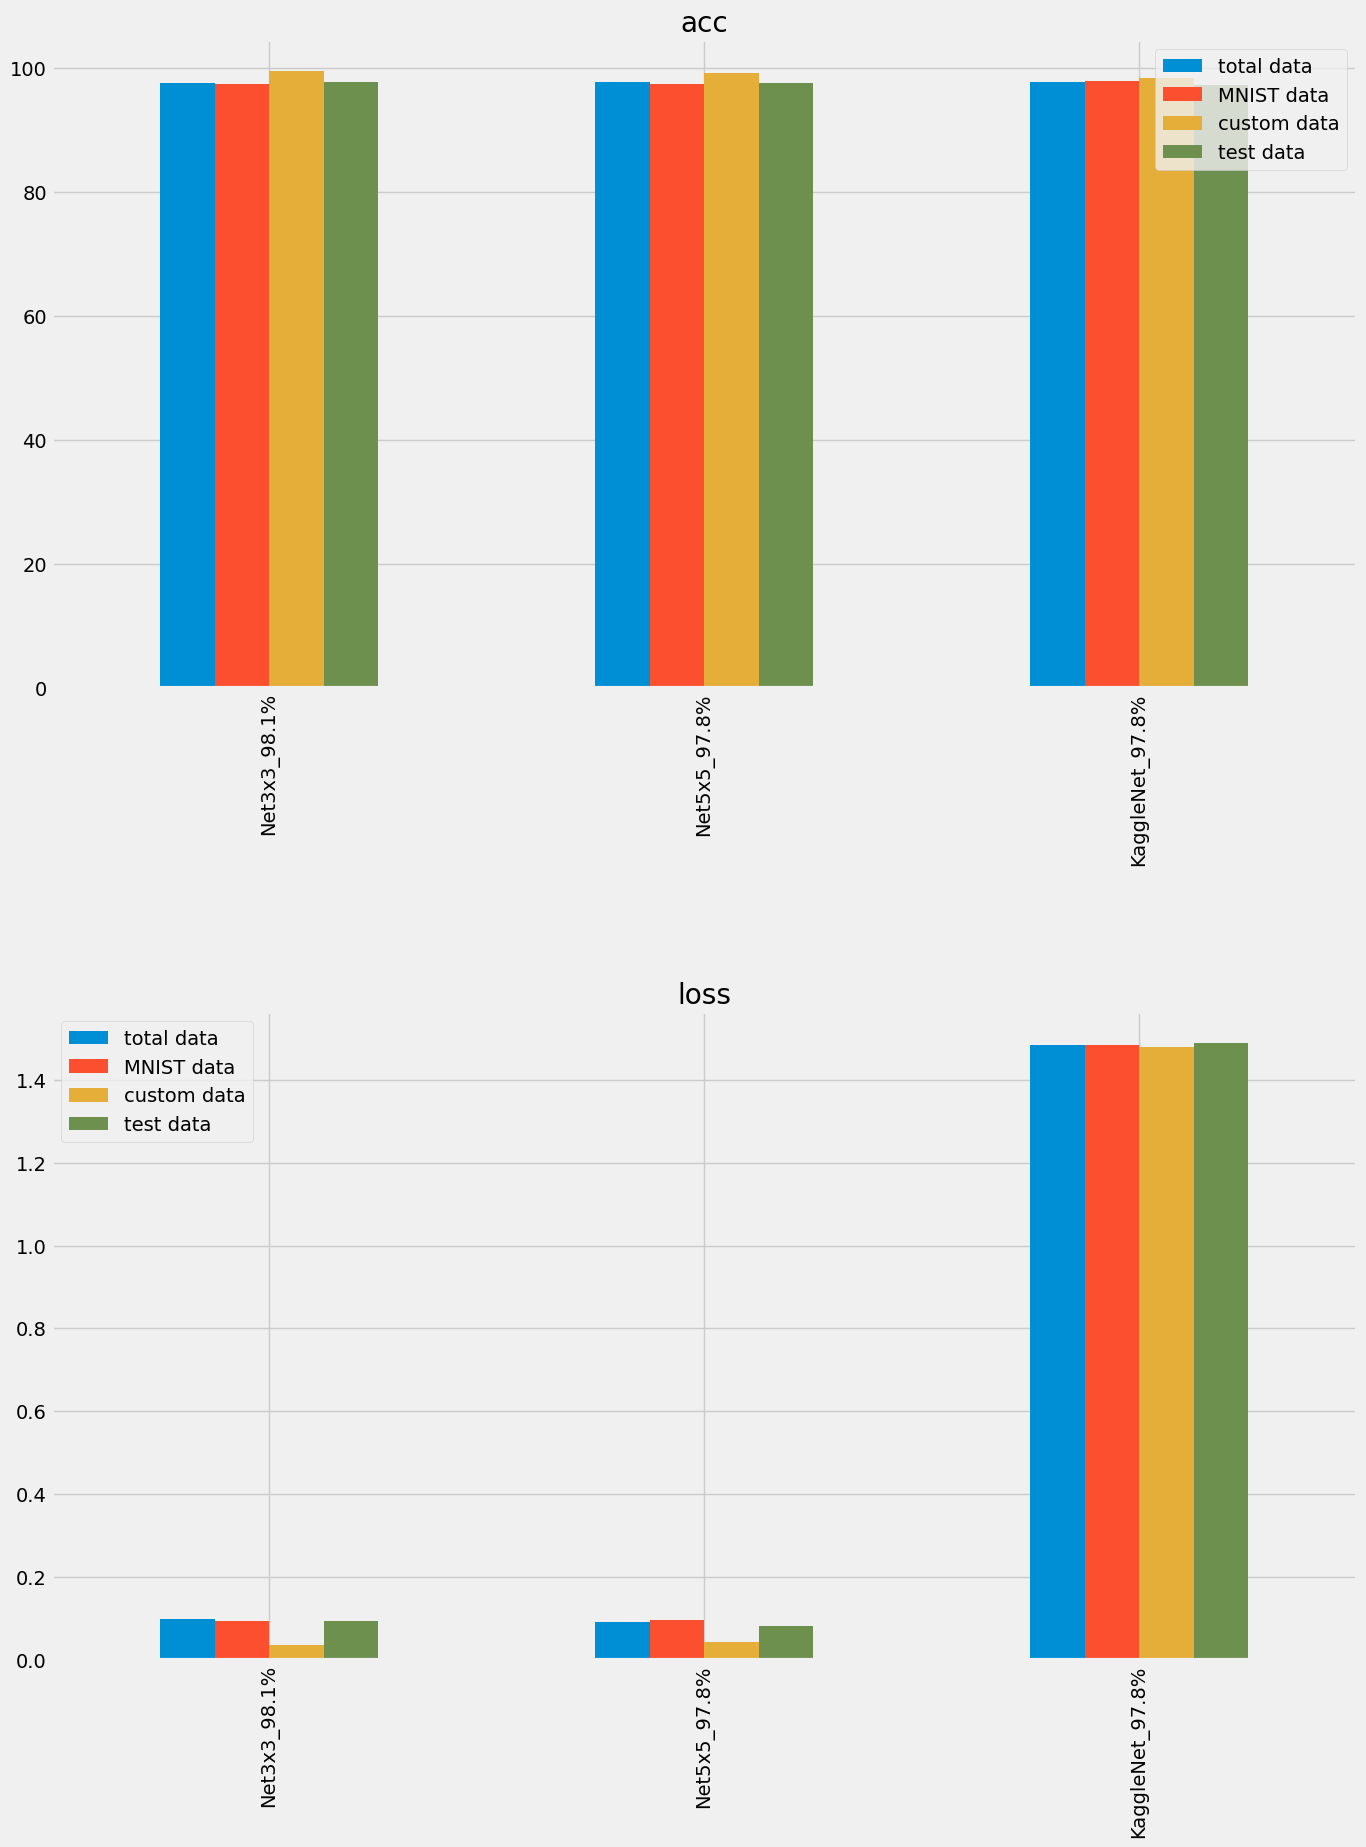

In [ ]:
models = [trainer_3x3, trainer_5x5, trainer_KaggleNet]
data_name=['total data', 'MNIST data', 'custom data', 'test data']
testloaders=[total_testloader, MNIST_testloader, custom_testloader, testloader]
mal = ModelAccLoss(models=models, data_name=data_name, testloaders=testloaders)

save

In [ ]:
info = SaveInformation(fname = trainer_3x3.output_fname,
                      net=trainer_3x3.net,
                      txt=trainer_3x3.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


In [ ]:
info = SaveInformation(fname = trainer_5x5.output_fname,
                      net=trainer_5x5.net,
                      txt=trainer_5x5.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


In [ ]:
info = SaveInformation(fname = trainer_KaggleNet.output_fname,
                      net=trainer_KaggleNet.net,
                      txt=trainer_KaggleNet.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


## 04 total Data

### dataset : 03 total dataset

### dataloader

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(t_ncd_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
vaildloader = torch.utils.data.DataLoader(t_ncd_vaildset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(t_ncd_testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
MNIST_testloader = torch.utils.data.DataLoader(MNIST_basic_testset, batch_size=batch_size, shuffle=True, num_workers=2)
total_testloader = torch.utils.data.DataLoader(total_testset, batch_size=batch_size, shuffle=True, num_workers=2)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=True, num_workers=2)

### train

### trainer_3x3

Epochs 1
-------------------------------

[1, 50] loss: 0.056 --------------- 1.002

[1, 100] loss: 0.049 --------------- 1.753

[1, 150] loss: 0.042 --------------- 2.323

[1, 200] loss: 0.036 --------------- 2.907

[1, 250] loss: 0.031 --------------- 3.323

[1, 300] loss: 0.026 --------------- 3.719

Test Error : 
 Accuracy : 74.199%, Avg loss: 0.96490783 



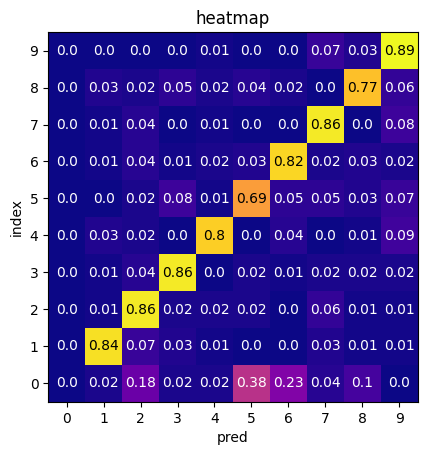

Epochs 2
-------------------------------

[2, 50] loss: 0.022 --------------- 0.520

[2, 100] loss: 0.020 --------------- 0.917

[2, 150] loss: 0.015 --------------- 1.310

[2, 200] loss: 0.011 --------------- 1.694

[2, 250] loss: 0.011 --------------- 2.078

[2, 300] loss: 0.010 --------------- 2.432

Test Error : 
 Accuracy : 87.660%, Avg loss: 0.40047987 



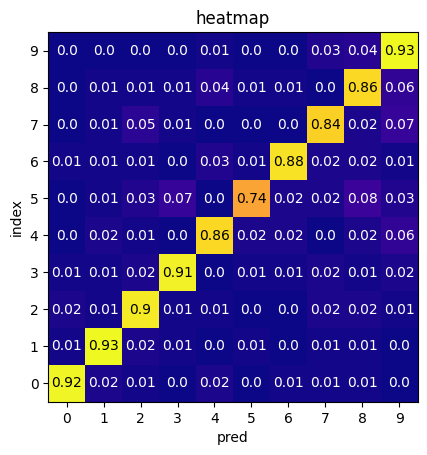

Epochs 3
-------------------------------

[3, 50] loss: 0.009 --------------- 0.534

[3, 100] loss: 0.009 --------------- 0.935

[3, 150] loss: 0.007 --------------- 1.332

[3, 200] loss: 0.008 --------------- 1.721

[3, 250] loss: 0.008 --------------- 2.115

[3, 300] loss: 0.008 --------------- 2.510

Test Error : 
 Accuracy : 88.542%, Avg loss: 0.33657714 



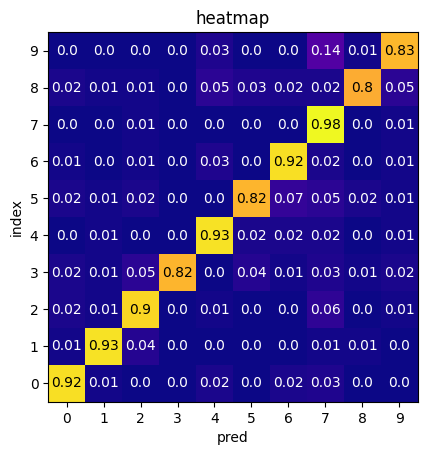

Epochs 4
-------------------------------

[4, 50] loss: 0.006 --------------- 0.505

[4, 100] loss: 0.006 --------------- 0.900

[4, 150] loss: 0.006 --------------- 1.285

[4, 200] loss: 0.006 --------------- 1.664

[4, 250] loss: 0.006 --------------- 2.132

[4, 300] loss: 0.005 --------------- 2.628

Test Error : 
 Accuracy : 92.869%, Avg loss: 0.21615444 



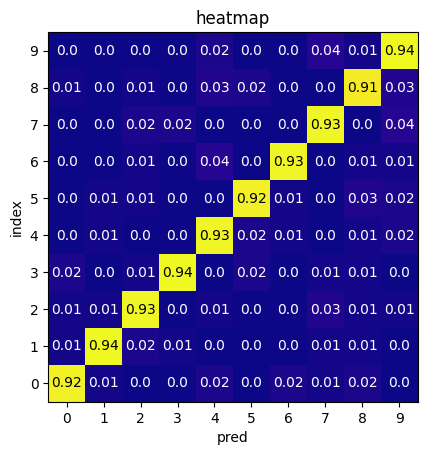

Epochs 5
-------------------------------

[5, 50] loss: 0.005 --------------- 0.659

[5, 100] loss: 0.004 --------------- 1.075

[5, 150] loss: 0.005 --------------- 1.456

[5, 200] loss: 0.005 --------------- 1.853

[5, 250] loss: 0.005 --------------- 2.212

[5, 300] loss: 0.004 --------------- 2.589

Test Error : 
 Accuracy : 92.788%, Avg loss: 0.21532628 



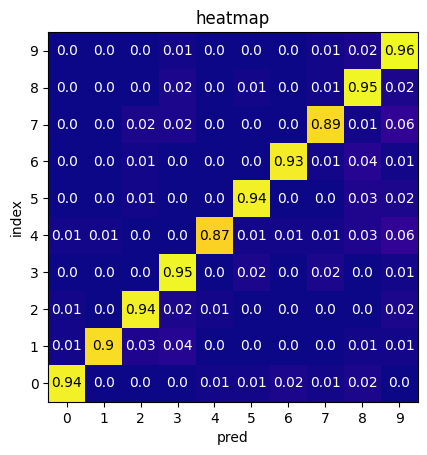

Epochs 6
-------------------------------

[6, 50] loss: 0.004 --------------- 0.519

[6, 100] loss: 0.004 --------------- 0.900

[6, 150] loss: 0.004 --------------- 1.280

[6, 200] loss: 0.004 --------------- 1.646

[6, 250] loss: 0.004 --------------- 2.035

[6, 300] loss: 0.004 --------------- 2.414

Test Error : 
 Accuracy : 94.071%, Avg loss: 0.17257172 



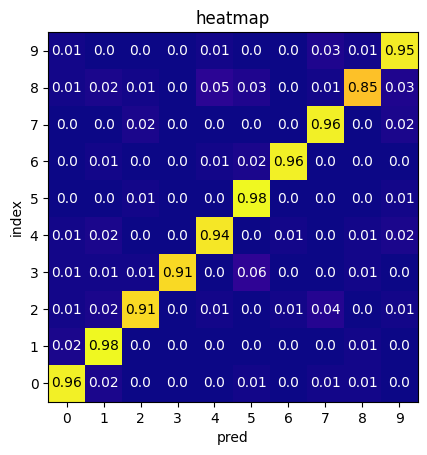

Epochs 7
-------------------------------

[7, 50] loss: 0.003 --------------- 0.519

[7, 100] loss: 0.002 --------------- 0.890

[7, 150] loss: 0.003 --------------- 1.270

[7, 200] loss: 0.003 --------------- 1.631

[7, 250] loss: 0.004 --------------- 1.998

[7, 300] loss: 0.004 --------------- 2.366

Test Error : 
 Accuracy : 93.990%, Avg loss: 0.15691991 



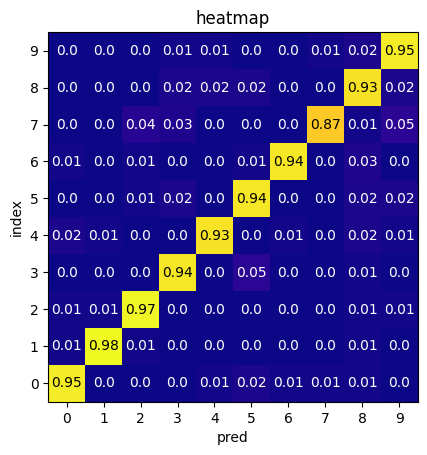

Epochs 8
-------------------------------

[8, 50] loss: 0.003 --------------- 0.506

[8, 100] loss: 0.002 --------------- 0.903

[8, 150] loss: 0.003 --------------- 1.377

[8, 200] loss: 0.003 --------------- 1.843

[8, 250] loss: 0.003 --------------- 2.308

[8, 300] loss: 0.003 --------------- 2.783

Test Error : 
 Accuracy : 96.314%, Avg loss: 0.12112832 



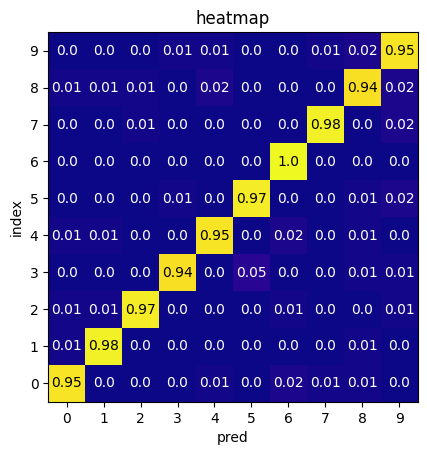

Epochs 9
-------------------------------

[9, 50] loss: 0.002 --------------- 0.494

[9, 100] loss: 0.002 --------------- 0.885

[9, 150] loss: 0.002 --------------- 1.271

[9, 200] loss: 0.002 --------------- 1.656

[9, 250] loss: 0.002 --------------- 2.040

[9, 300] loss: 0.002 --------------- 2.416

Test Error : 
 Accuracy : 96.554%, Avg loss: 0.11675278 



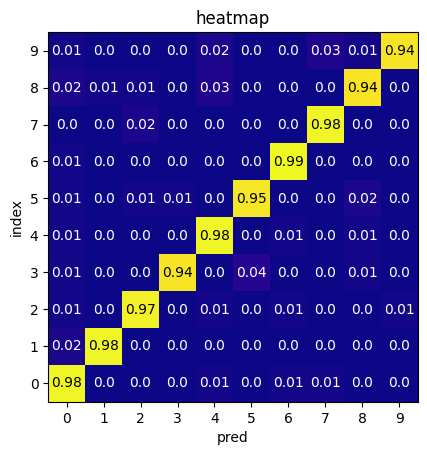

Epochs 10
-------------------------------

[10, 50] loss: 0.002 --------------- 0.544

[10, 100] loss: 0.001 --------------- 0.938

[10, 150] loss: 0.002 --------------- 1.323

[10, 200] loss: 0.002 --------------- 1.705

[10, 250] loss: 0.002 --------------- 2.077

[10, 300] loss: 0.002 --------------- 2.442

Test Error : 
 Accuracy : 96.234%, Avg loss: 0.11836398 



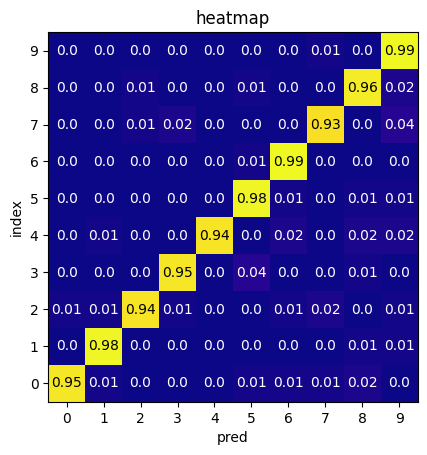

Epochs 11
-------------------------------

[11, 50] loss: 0.001 --------------- 0.513

[11, 100] loss: 0.002 --------------- 0.906

[11, 150] loss: 0.002 --------------- 1.282

[11, 200] loss: 0.002 --------------- 1.646

[11, 250] loss: 0.002 --------------- 2.006

[11, 300] loss: 0.003 --------------- 2.370

Test Error : 
 Accuracy : 95.032%, Avg loss: 0.12651036 



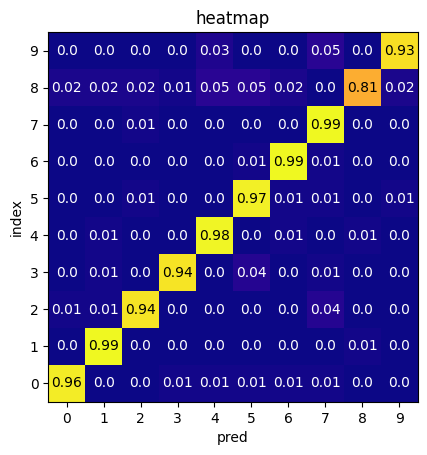

Epochs 12
-------------------------------

[12, 50] loss: 0.001 --------------- 0.618

[12, 100] loss: 0.001 --------------- 1.096

[12, 150] loss: 0.001 --------------- 1.581

[12, 200] loss: 0.001 --------------- 2.070

[12, 250] loss: 0.001 --------------- 2.545

[12, 300] loss: 0.001 --------------- 2.979

Test Error : 
 Accuracy : 97.115%, Avg loss: 0.09662073 



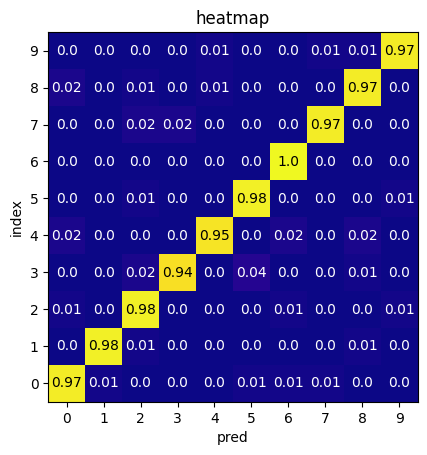

Epochs 13
-------------------------------

[13, 50] loss: 0.001 --------------- 0.492

[13, 100] loss: 0.001 --------------- 0.871

[13, 150] loss: 0.001 --------------- 1.266

[13, 200] loss: 0.001 --------------- 1.644

[13, 250] loss: 0.001 --------------- 2.018

[13, 300] loss: 0.001 --------------- 2.401

Test Error : 
 Accuracy : 96.554%, Avg loss: 0.09256726 



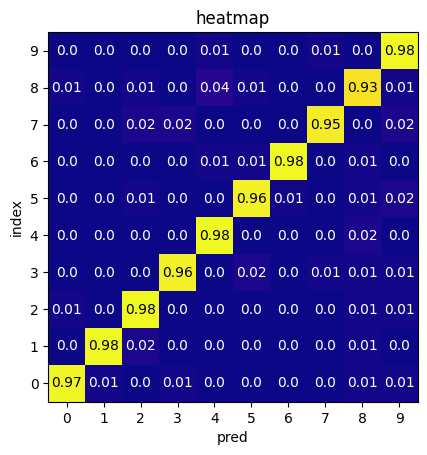

Epochs 14
-------------------------------

[14, 50] loss: 0.001 --------------- 0.535

[14, 100] loss: 0.001 --------------- 0.934

[14, 150] loss: 0.001 --------------- 1.349

[14, 200] loss: 0.001 --------------- 1.741

[14, 250] loss: 0.001 --------------- 2.141

[14, 300] loss: 0.001 --------------- 2.528

Test Error : 
 Accuracy : 97.436%, Avg loss: 0.08244397 



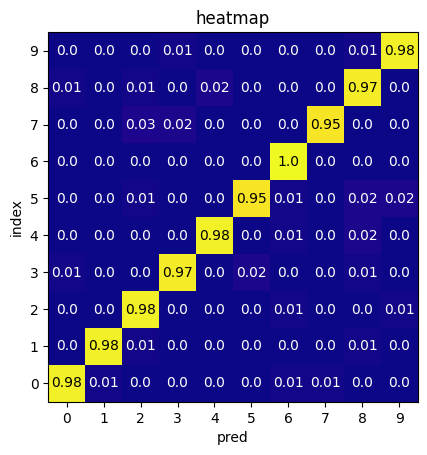

Epochs 15
-------------------------------

[15, 50] loss: 0.001 --------------- 0.549

[15, 100] loss: 0.001 --------------- 0.937

[15, 150] loss: 0.001 --------------- 1.332

[15, 200] loss: 0.001 --------------- 1.724

[15, 250] loss: 0.001 --------------- 2.171

[15, 300] loss: 0.001 --------------- 2.661

Test Error : 
 Accuracy : 97.276%, Avg loss: 0.09203679 



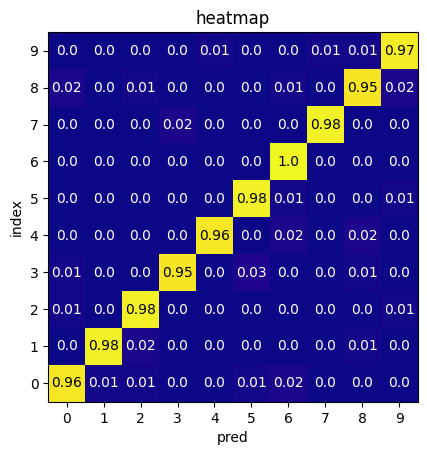

Epochs 16
-------------------------------

[16, 50] loss: 0.001 --------------- 0.654

[16, 100] loss: 0.001 --------------- 1.155

[16, 150] loss: 0.001 --------------- 1.545

[16, 200] loss: 0.001 --------------- 1.936

[16, 250] loss: 0.000 --------------- 2.321

[16, 300] loss: 0.001 --------------- 2.682

Test Error : 
 Accuracy : 96.955%, Avg loss: 0.08659644 



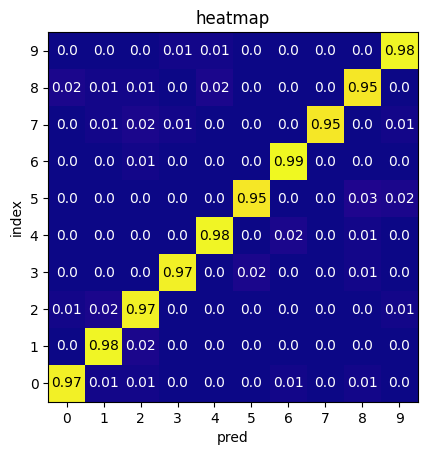

Epochs 17
-------------------------------

[17, 50] loss: 0.000 --------------- 0.540

[17, 100] loss: 0.000 --------------- 0.910

[17, 150] loss: 0.001 --------------- 1.321

[17, 200] loss: 0.001 --------------- 1.689

[17, 250] loss: 0.001 --------------- 2.047

[17, 300] loss: 0.001 --------------- 2.399

Test Error : 
 Accuracy : 96.394%, Avg loss: 0.11614499 



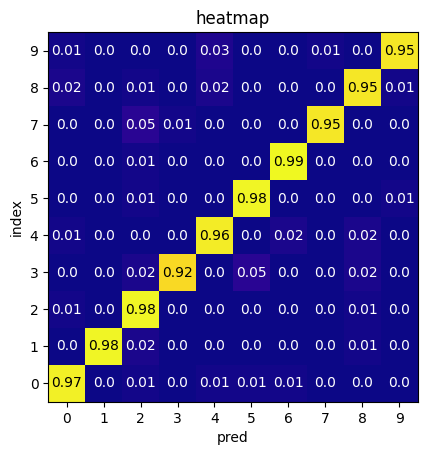

Epochs 18
-------------------------------

[18, 50] loss: 0.000 --------------- 0.513

[18, 100] loss: 0.000 --------------- 0.902

[18, 150] loss: 0.001 --------------- 1.303

[18, 200] loss: 0.001 --------------- 1.695

[18, 250] loss: 0.000 --------------- 2.087

[18, 300] loss: 0.000 --------------- 2.449

Test Error : 
 Accuracy : 97.676%, Avg loss: 0.08477476 



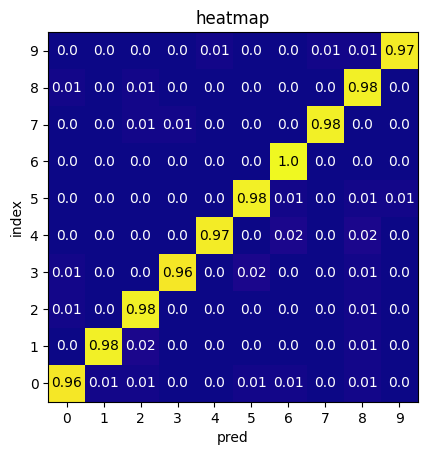

Epochs 19
-------------------------------

[19, 50] loss: 0.000 --------------- 0.500

[19, 100] loss: 0.000 --------------- 0.889

[19, 150] loss: 0.000 --------------- 1.369

[19, 200] loss: 0.000 --------------- 1.850

[19, 250] loss: 0.000 --------------- 2.317

[19, 300] loss: 0.000 --------------- 2.803

Test Error : 
 Accuracy : 97.756%, Avg loss: 0.07427829 



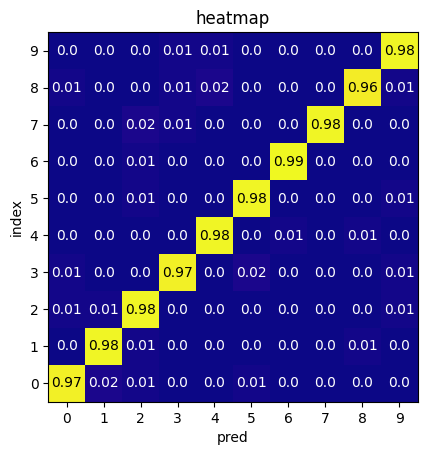

Epochs 20
-------------------------------

[20, 50] loss: 0.000 --------------- 0.515

[20, 100] loss: 0.000 --------------- 0.909

[20, 150] loss: 0.000 --------------- 1.275

[20, 200] loss: 0.000 --------------- 1.651

[20, 250] loss: 0.000 --------------- 2.038

[20, 300] loss: 0.000 --------------- 2.395

Test Error : 
 Accuracy : 97.676%, Avg loss: 0.07487232 



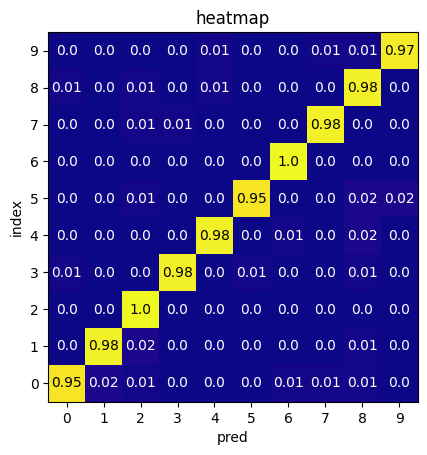

Training complete.


In [ ]:
fname = 'Net3x3'
net = Net3x3(bn=True)

trainer_3x3 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=20,
                 net=net,
                 print_interval=50,
                 printing=True,
                 heatmap=True)

### trainer_5x5

Epochs 1
-------------------------------

[1, 200] loss: 0.193 --------------- 1.856

Test Error : 
 Accuracy : 64.103%, Avg loss: 1.24473279 



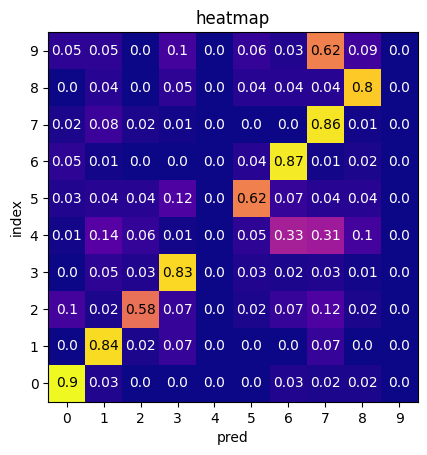

Epochs 2
-------------------------------

[2, 200] loss: 0.106 --------------- 2.012

Test Error : 
 Accuracy : 70.513%, Avg loss: 0.86442938 



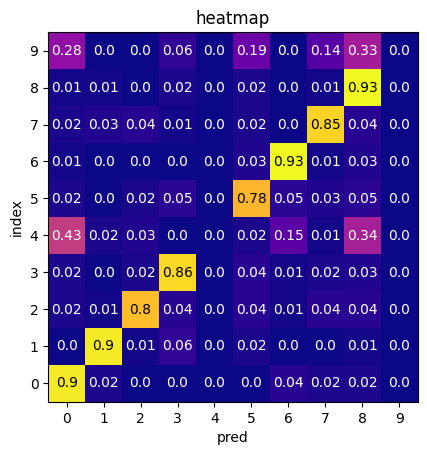

Epochs 3
-------------------------------

[3, 200] loss: 0.082 --------------- 1.791

Test Error : 
 Accuracy : 74.519%, Avg loss: 0.70528363 



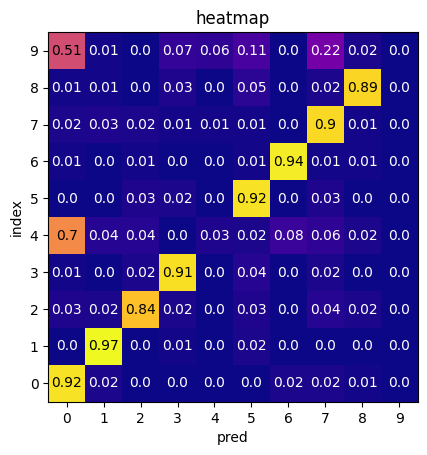

Epochs 4
-------------------------------

[4, 200] loss: 0.064 --------------- 1.815

Test Error : 
 Accuracy : 82.131%, Avg loss: 0.49010268 



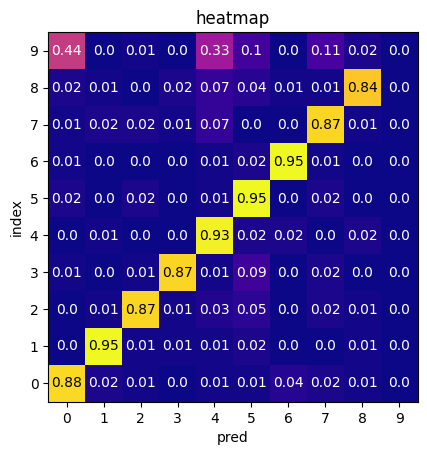

Epochs 5
-------------------------------

[5, 200] loss: 0.045 --------------- 1.773

Test Error : 
 Accuracy : 84.215%, Avg loss: 0.45558502 



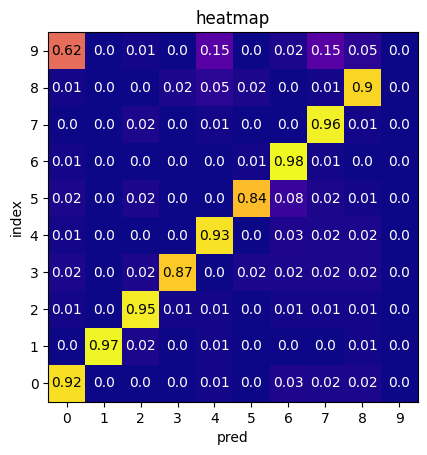

Epochs 6
-------------------------------

[6, 200] loss: 0.042 --------------- 2.158

Test Error : 
 Accuracy : 85.657%, Avg loss: 0.37737652 



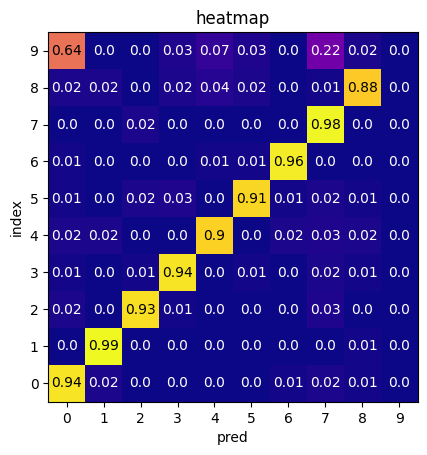

Epochs 7
-------------------------------

[7, 200] loss: 0.037 --------------- 1.793

Test Error : 
 Accuracy : 86.939%, Avg loss: 0.35744881 



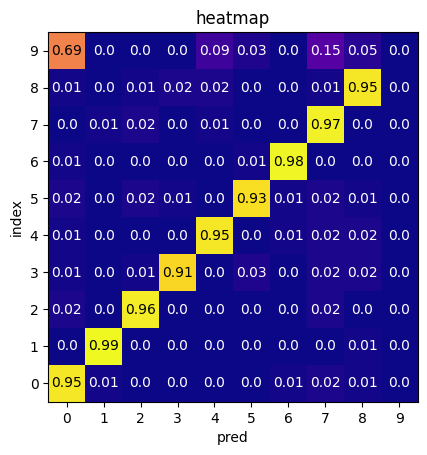

Epochs 8
-------------------------------

[8, 200] loss: 0.036 --------------- 1.782

Test Error : 
 Accuracy : 92.869%, Avg loss: 0.23523554 



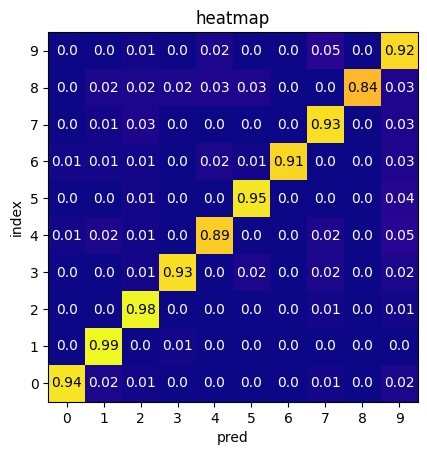

Epochs 9
-------------------------------

[9, 200] loss: 0.014 --------------- 1.996

Test Error : 
 Accuracy : 94.792%, Avg loss: 0.17058165 



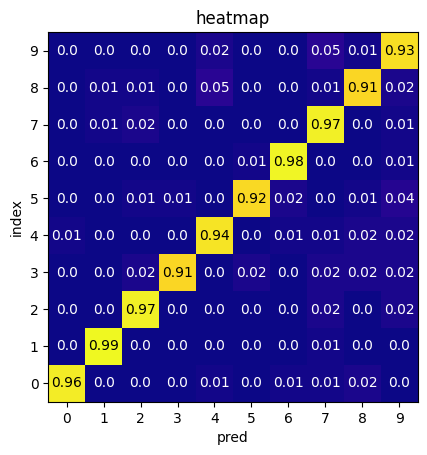

Epochs 10
-------------------------------

[10, 200] loss: 0.011 --------------- 1.741

Test Error : 
 Accuracy : 95.513%, Avg loss: 0.15069270 



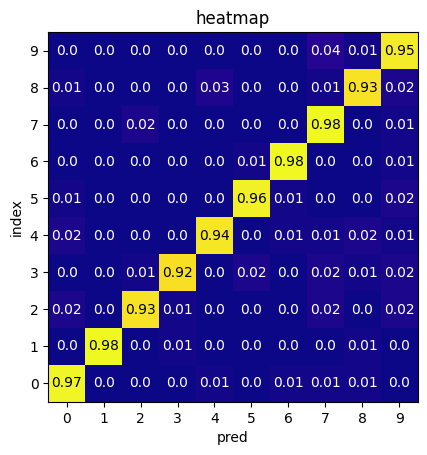

Epochs 11
-------------------------------

[11, 200] loss: 0.010 --------------- 1.774

Test Error : 
 Accuracy : 95.833%, Avg loss: 0.14512863 



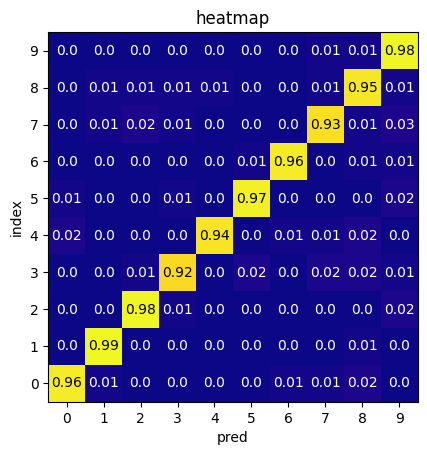

Epochs 12
-------------------------------

[12, 200] loss: 0.009 --------------- 1.755

Test Error : 
 Accuracy : 95.272%, Avg loss: 0.14918700 



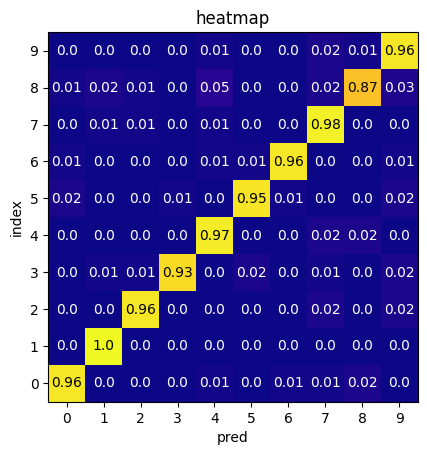

Epochs 13
-------------------------------

[13, 200] loss: 0.008 --------------- 2.060

Test Error : 
 Accuracy : 96.234%, Avg loss: 0.12092013 



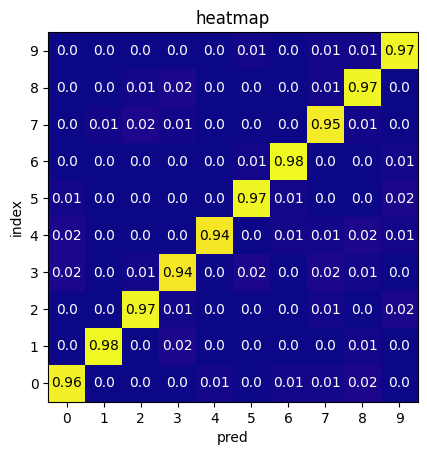

Epochs 14
-------------------------------

[14, 200] loss: 0.006 --------------- 1.810

Test Error : 
 Accuracy : 96.474%, Avg loss: 0.11945182 



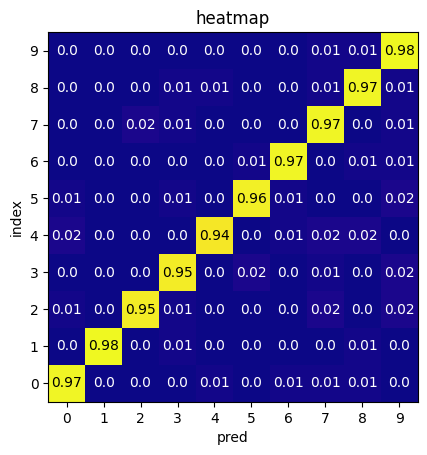

Epochs 15
-------------------------------

[15, 200] loss: 0.005 --------------- 1.753

Test Error : 
 Accuracy : 96.474%, Avg loss: 0.12120542 



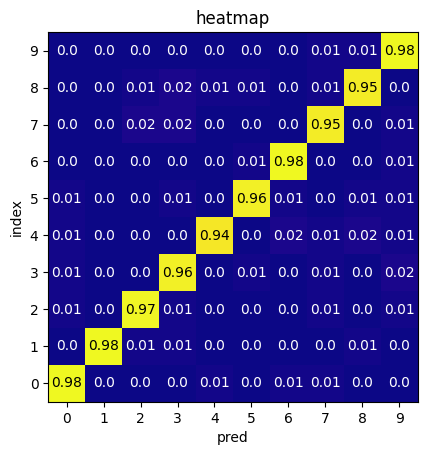

Epochs 16
-------------------------------

[16, 200] loss: 0.005 --------------- 2.011

Test Error : 
 Accuracy : 95.994%, Avg loss: 0.13111207 



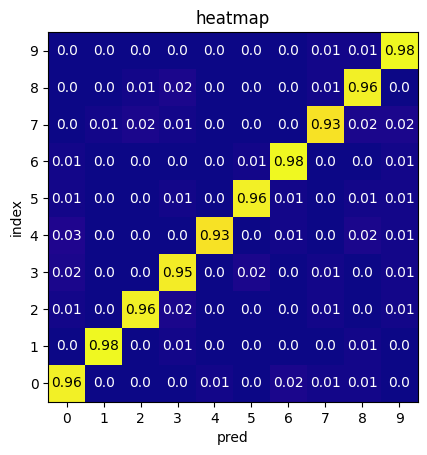

Epochs 17
-------------------------------

[17, 200] loss: 0.005 --------------- 1.923

Test Error : 
 Accuracy : 96.394%, Avg loss: 0.11580110 



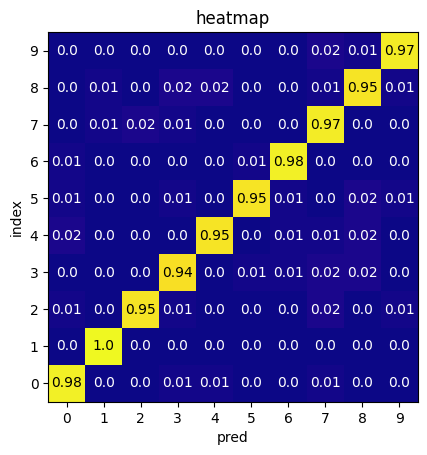

Epochs 18
-------------------------------

[18, 200] loss: 0.004 --------------- 1.849

Test Error : 
 Accuracy : 96.474%, Avg loss: 0.11075241 



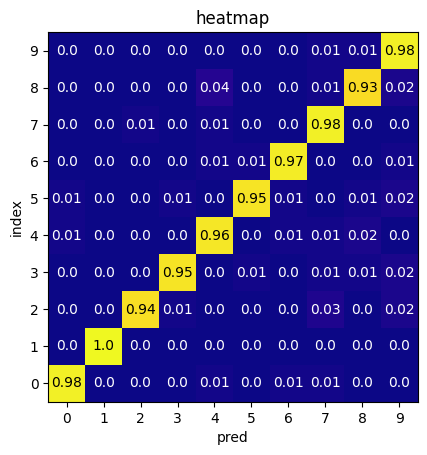

Epochs 19
-------------------------------

[19, 200] loss: 0.004 --------------- 1.861

Test Error : 
 Accuracy : 96.635%, Avg loss: 0.10702046 



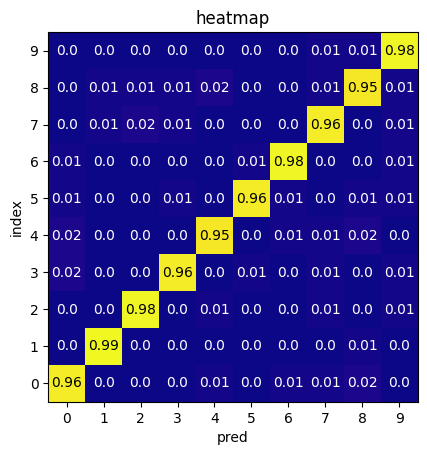

Epochs 20
-------------------------------

[20, 200] loss: 0.003 --------------- 1.960

Test Error : 
 Accuracy : 96.554%, Avg loss: 0.10176854 



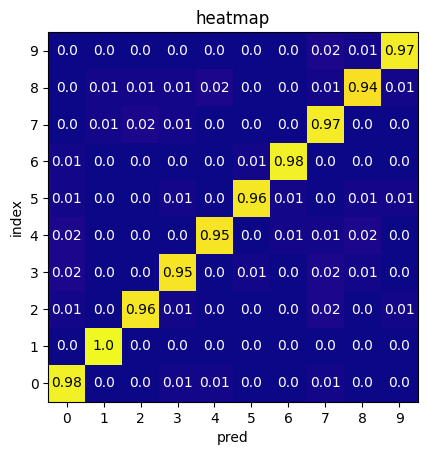

Training complete.


In [ ]:
fname = 'Net5x5'
net = Net5x5(bn=True)

trainer_5x5 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=20,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=True)

### trainer_KaggleNet

Epochs 1
-------------------------------

[1, 200] loss: 0.229 --------------- 9.611

Test Error : 
 Accuracy : 51.683%, Avg loss: 2.21894063 



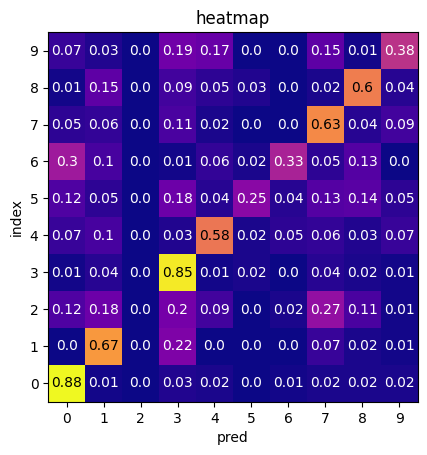

Epochs 2
-------------------------------

[2, 200] loss: 0.184 --------------- 7.886

Test Error : 
 Accuracy : 76.763%, Avg loss: 1.69774222 



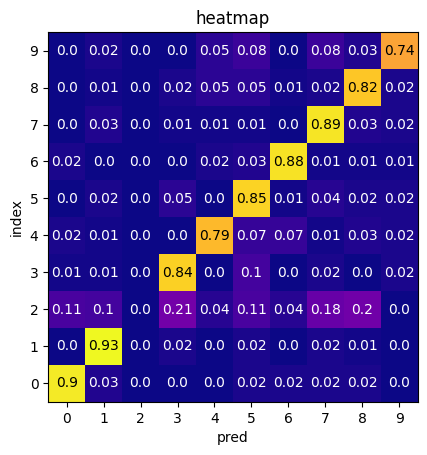

Epochs 3
-------------------------------

[3, 200] loss: 0.168 --------------- 8.164

Test Error : 
 Accuracy : 81.410%, Avg loss: 1.64759110 



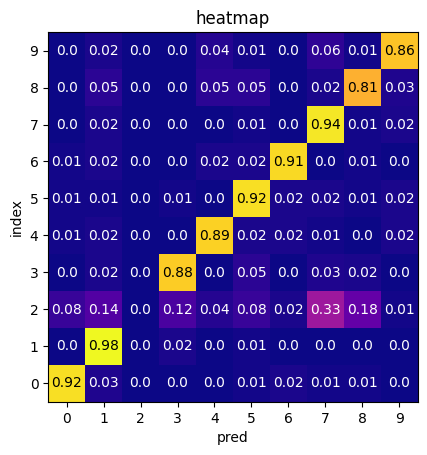

Epochs 4
-------------------------------

[4, 200] loss: 0.165 --------------- 9.013

Test Error : 
 Accuracy : 83.654%, Avg loss: 1.62532685 



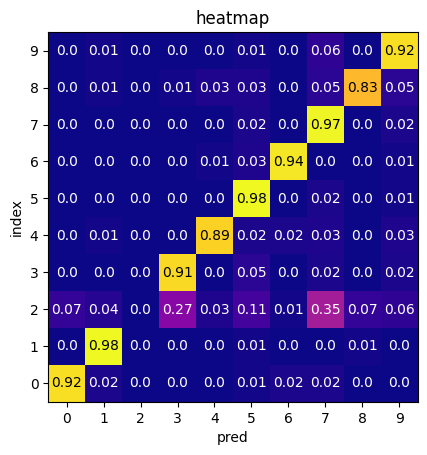

Epochs 5
-------------------------------

[5, 200] loss: 0.160 --------------- 9.131

Test Error : 
 Accuracy : 91.747%, Avg loss: 1.54473116 



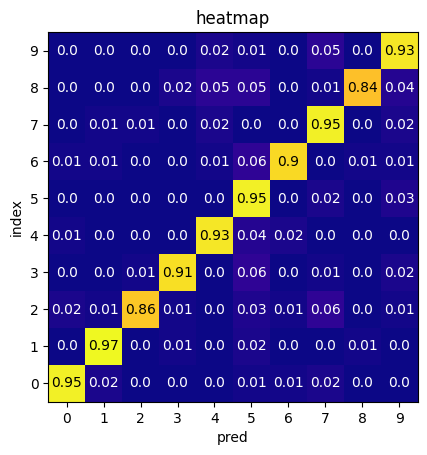

Epochs 6
-------------------------------

[6, 200] loss: 0.153 --------------- 8.941

Test Error : 
 Accuracy : 92.308%, Avg loss: 1.53828408 



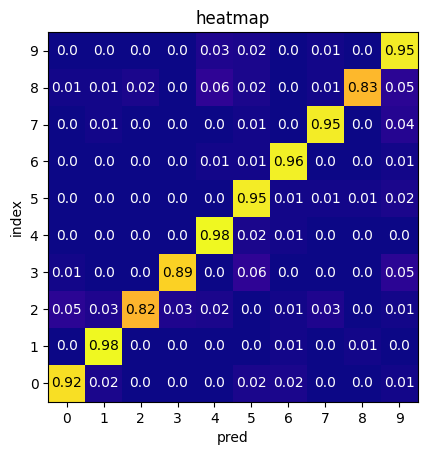

Epochs 7
-------------------------------

[7, 200] loss: 0.151 --------------- 8.966

Test Error : 
 Accuracy : 93.830%, Avg loss: 1.52297135 



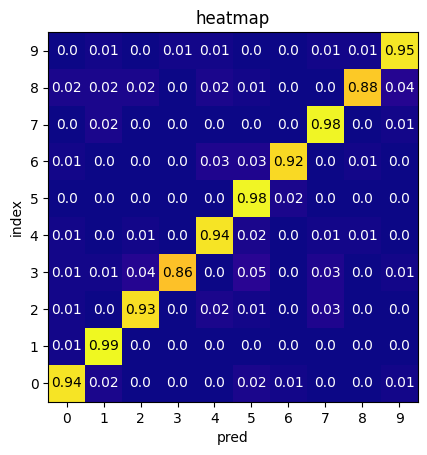

Epochs 8
-------------------------------

[8, 200] loss: 0.151 --------------- 8.003

Test Error : 
 Accuracy : 95.032%, Avg loss: 1.50950418 



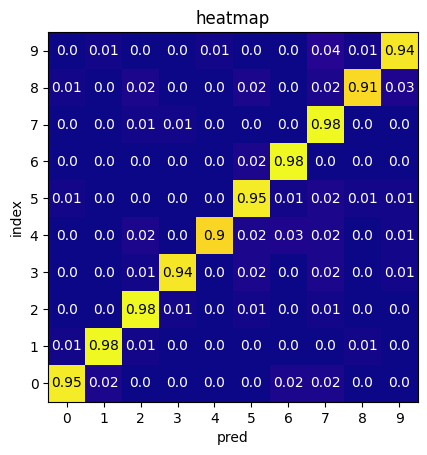

Epochs 9
-------------------------------

[9, 200] loss: 0.150 --------------- 8.112

Test Error : 
 Accuracy : 94.872%, Avg loss: 1.51146883 



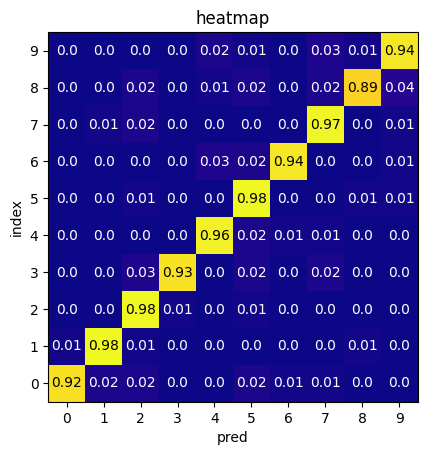

Epochs 10
-------------------------------

[10, 200] loss: 0.150 --------------- 10.200

Test Error : 
 Accuracy : 95.353%, Avg loss: 1.50890613 



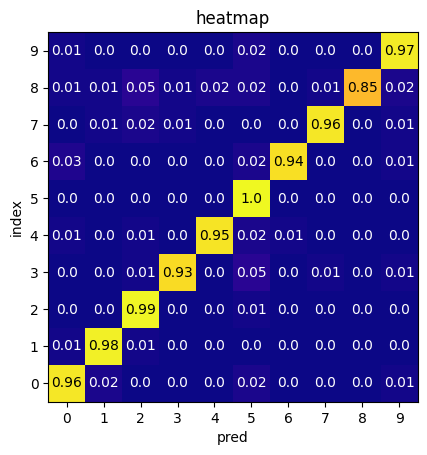

Epochs 11
-------------------------------

[11, 200] loss: 0.150 --------------- 9.345

Test Error : 
 Accuracy : 95.433%, Avg loss: 1.50739202 



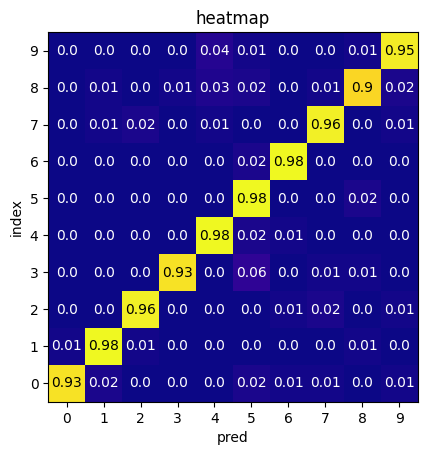

Epochs 12
-------------------------------

[12, 200] loss: 0.149 --------------- 9.256

Test Error : 
 Accuracy : 96.394%, Avg loss: 1.49806616 



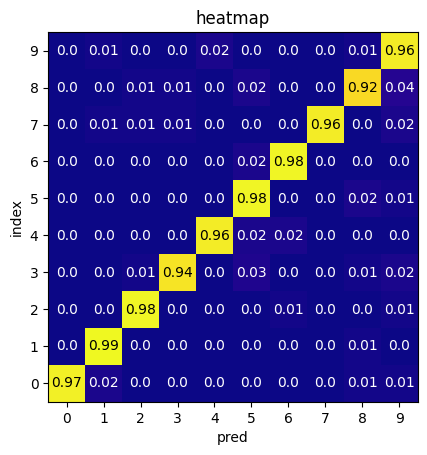

Epochs 13
-------------------------------

[13, 200] loss: 0.149 --------------- 9.463

Test Error : 
 Accuracy : 96.074%, Avg loss: 1.50024046 



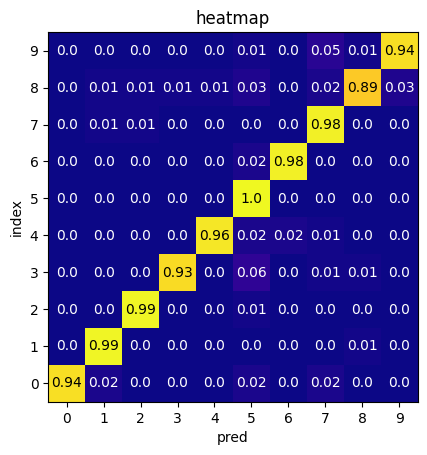

Epochs 14
-------------------------------

[14, 200] loss: 0.149 --------------- 9.359

Test Error : 
 Accuracy : 96.154%, Avg loss: 1.49896489 



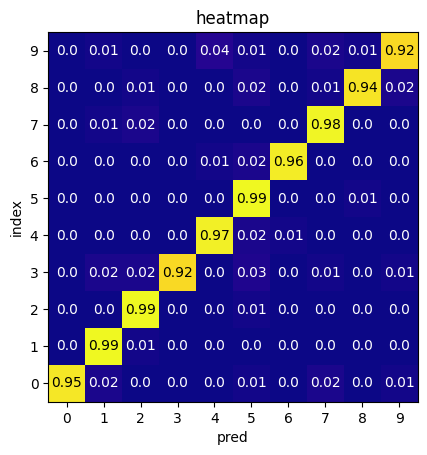

Epochs 15
-------------------------------

[15, 200] loss: 0.149 --------------- 8.310

Test Error : 
 Accuracy : 95.913%, Avg loss: 1.50118516 



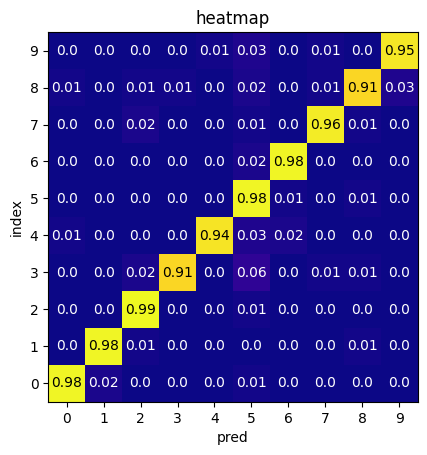

Epochs 16
-------------------------------

[16, 200] loss: 0.149 --------------- 9.013

Test Error : 
 Accuracy : 96.314%, Avg loss: 1.49802703 



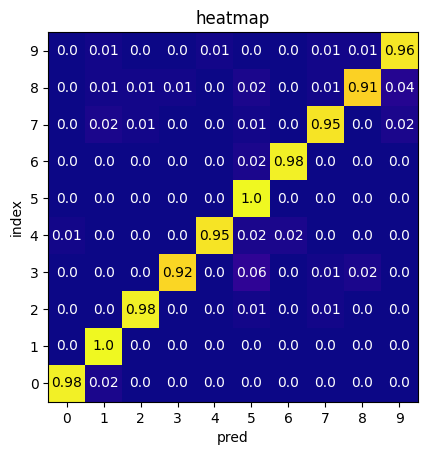

Epochs 17
-------------------------------

[17, 200] loss: 0.149 --------------- 9.507

Test Error : 
 Accuracy : 95.673%, Avg loss: 1.50283257 



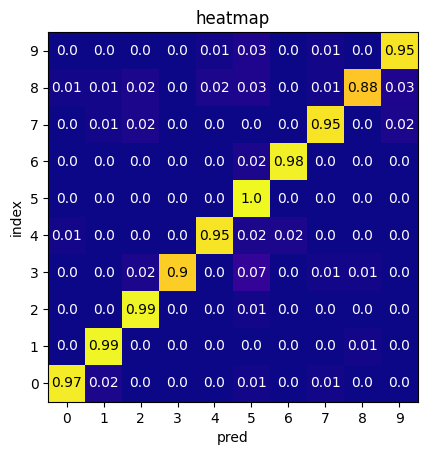

Epochs 18
-------------------------------

[18, 200] loss: 0.148 --------------- 10.233

Test Error : 
 Accuracy : 96.394%, Avg loss: 1.49950673 



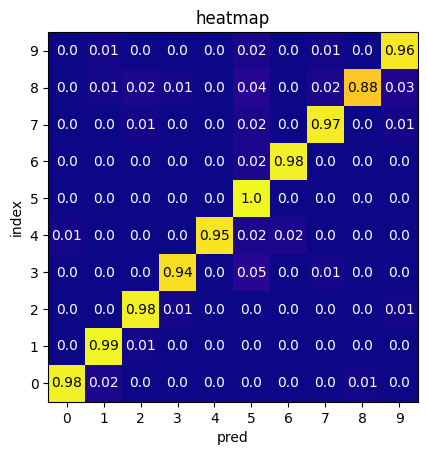

Epochs 19
-------------------------------

[19, 200] loss: 0.148 --------------- 8.522

Test Error : 
 Accuracy : 96.314%, Avg loss: 1.50005002 



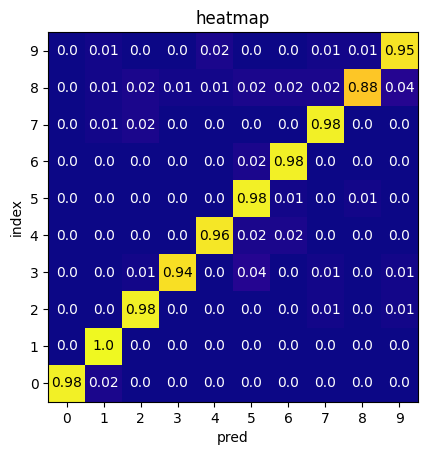

Epochs 20
-------------------------------

[20, 200] loss: 0.148 --------------- 8.383

Test Error : 
 Accuracy : 96.635%, Avg loss: 1.49595634 



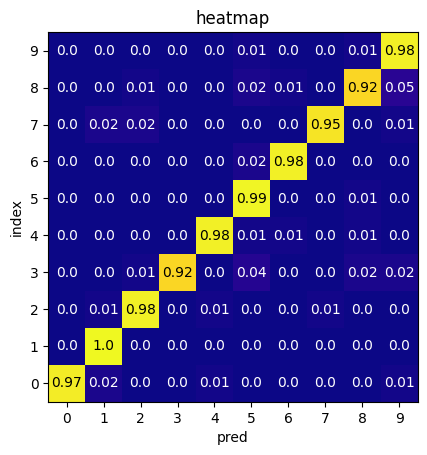

Training complete.


In [ ]:
fname = 'KaggleNet'
net = KaggleNet()

trainer_KaggleNet = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=20,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=True)

### acc loss plot

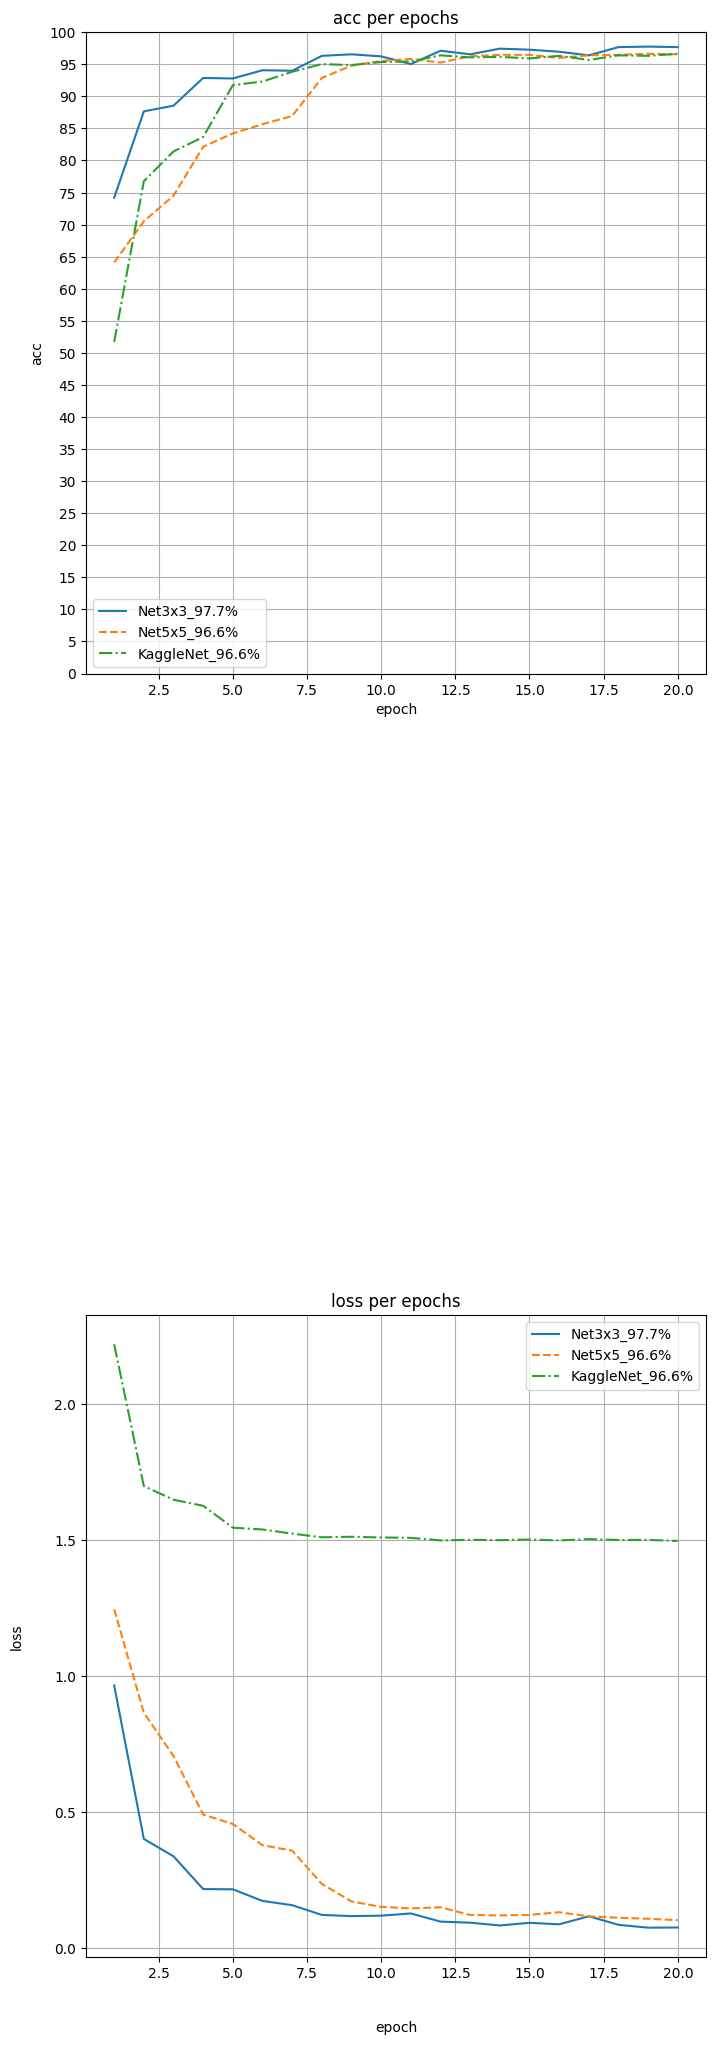

In [ ]:
matplotlib.style.use('default')

plot = PlotMaker()

plot.make_arrs(name=trainer_3x3.output_fname, data=trainer_3x3.acc_loss_epoch)
plot.make_arrs(name=trainer_5x5.output_fname, data=trainer_5x5.acc_loss_epoch)
plot.make_arrs(name=trainer_KaggleNet.output_fname, data=trainer_KaggleNet.acc_loss_epoch)
plot.make_plot()

### plot by models

total data ----------------------------

Net3x3_97.7% --------------------------
Test Error : 
 Accuracy : 97.0%, Avg loss: 0.13096159 

Net5x5_96.6% --------------------------
Test Error : 
 Accuracy : 97.1%, Avg loss: 0.1227747 

KaggleNet_96.6% --------------------------
Test Error : 
 Accuracy : 96.7%, Avg loss: 1.49439086 

MNIST data ----------------------------

Net3x3_97.7% --------------------------
Test Error : 
 Accuracy : 97.2%, Avg loss: 0.12853159 

Net5x5_96.6% --------------------------
Test Error : 
 Accuracy : 97.8%, Avg loss: 0.09053577 

KaggleNet_96.6% --------------------------
Test Error : 
 Accuracy : 97.1%, Avg loss: 1.49094485 

custom data ----------------------------

Net3x3_97.7% --------------------------
Test Error : 
 Accuracy : 98.8%, Avg loss: 0.035626 

Net5x5_96.6% --------------------------
Test Error : 
 Accuracy : 96.8%, Avg loss: 0.08881829 

KaggleNet_96.6% --------------------------
Test Error : 
 Accuracy : 95.9%, Avg loss: 1.50328578 

test d

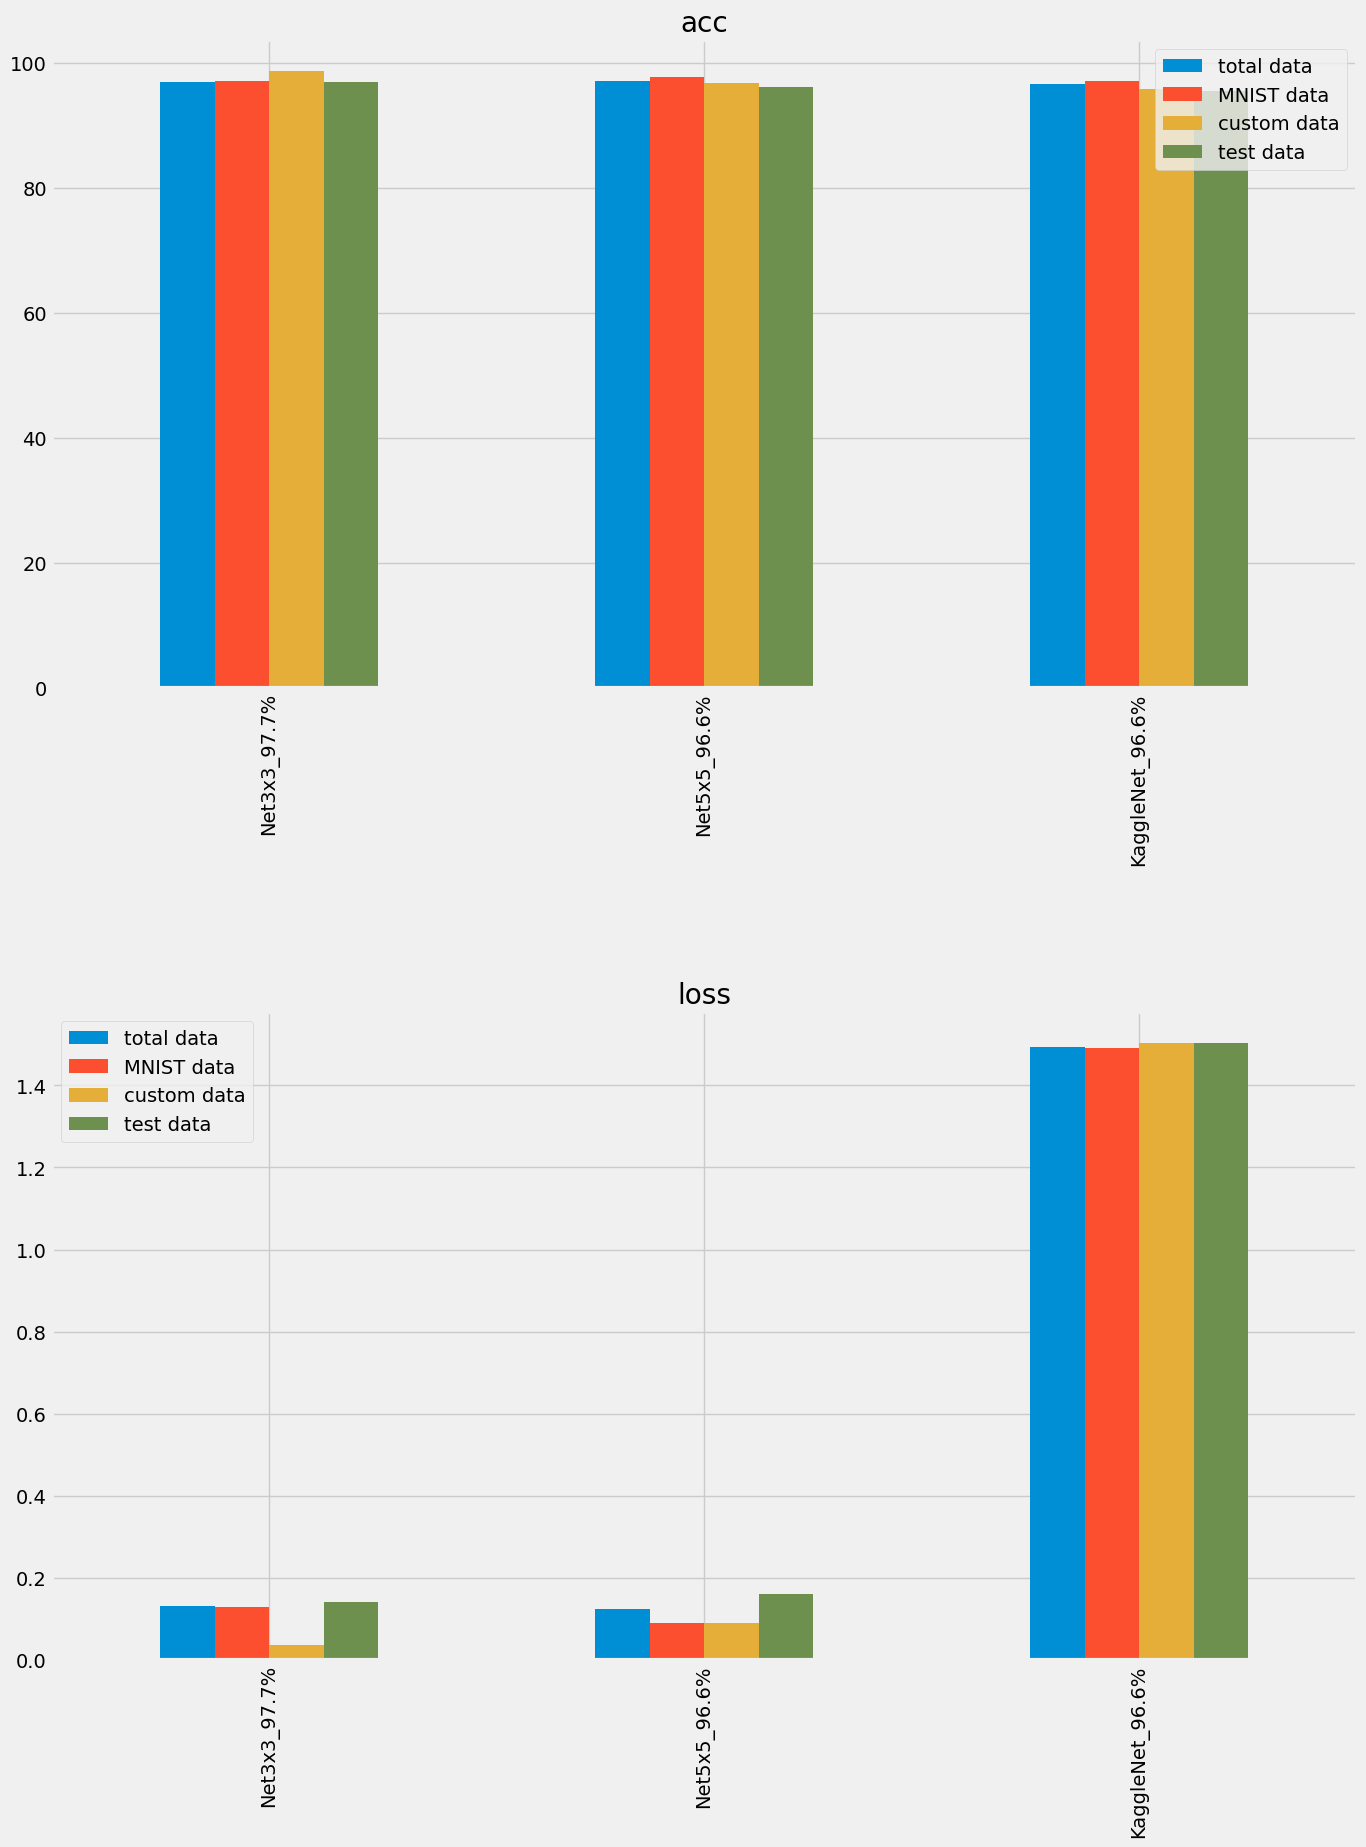

In [ ]:
models = [trainer_3x3, trainer_5x5, trainer_KaggleNet]
data_name=['total data', 'MNIST data', 'custom data', 'test data']
testloaders=[total_testloader, MNIST_testloader, custom_testloader, testloader]
mal = ModelAccLoss(models=models, data_name=data_name, testloaders=testloaders)

save

In [ ]:
info = SaveInformation(fname = trainer_3x3.output_fname,
                      net=trainer_3x3.net,
                      txt=trainer_3x3.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


In [ ]:
info = SaveInformation(fname = trainer_5x5.output_fname,
                      net=trainer_5x5.net,
                      txt=trainer_5x5.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


In [ ]:
info = SaveInformation(fname = trainer_KaggleNet.output_fname,
                      net=trainer_KaggleNet.net,
                      txt=trainer_KaggleNet.process_txt,
                       trainset=custom_trainset,
                       vaildset=custom_vaildset,
                       testset=custom_testset
                       )

Saved trainset
Saved vaildset
Saved testset
Saved PyTorch Model State
Saved PyTorch Model


## 03 normalized Data

### dataloader

In [ ]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(normalized_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
vaildloader = torch.utils.data.DataLoader(normalized_vaildset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(normalized_testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
MNIST_testloader = torch.utils.data.DataLoader(MNIST_basic_testset, batch_size=batch_size, shuffle=True, num_workers=2)
total_testloader = torch.utils.data.DataLoader(total_testset, batch_size=batch_size, shuffle=True, num_workers=2)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
data_lst = ['normalized', 'nss', 'ncd',
            'normalized_custom', 'ncd_normalized',
            'custom', 'MNIST',
            'total', 't_nss', 't_ncd']

In [ ]:
data_lst = ['normalized', 'nss', 'ncd']

dic = {}

for name in data_lst:
    batch_size = 32

    dataset = f'{name}_dataset'
    trainset = f'{name}_trainset'
    vaildset = f'{name}_vaildset'
    testset = f'{name}_testset'

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    vaildloader = torch.utils.data.DataLoader(vaildset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

    fname = 'Net3x3'
    net = Net3x3(bn=True)

    print(dataset)
    print(' ')

    trainer = Trainer(fname=fname,
                    criterian=nn.CrossEntropyLoss(),
                    trainloader=trainloader,
                    testloader=vaildloader,
                    epochs=10,
                    net=net,
                    print_interval=50,
                    printing=True,
                    heatmap=False)

    dic[dataset] = trainer

normalized_dataset
 
Epochs 1
-------------------------------



ValueError: ignored

### train

### trainer_3x3

In [ ]:
fname = 'Net3x3'
net = Net3x3(bn=True)

trainer_3x3 = Trainer(fname=fname,
                 criterian=nn.CrossEntropyLoss(),
                 trainloader=trainloader,
                 testloader=vaildloader,
                 epochs=20,
                 net=net,
                 print_interval=200,
                 printing=True,
                 heatmap=False)

### acc loss plot

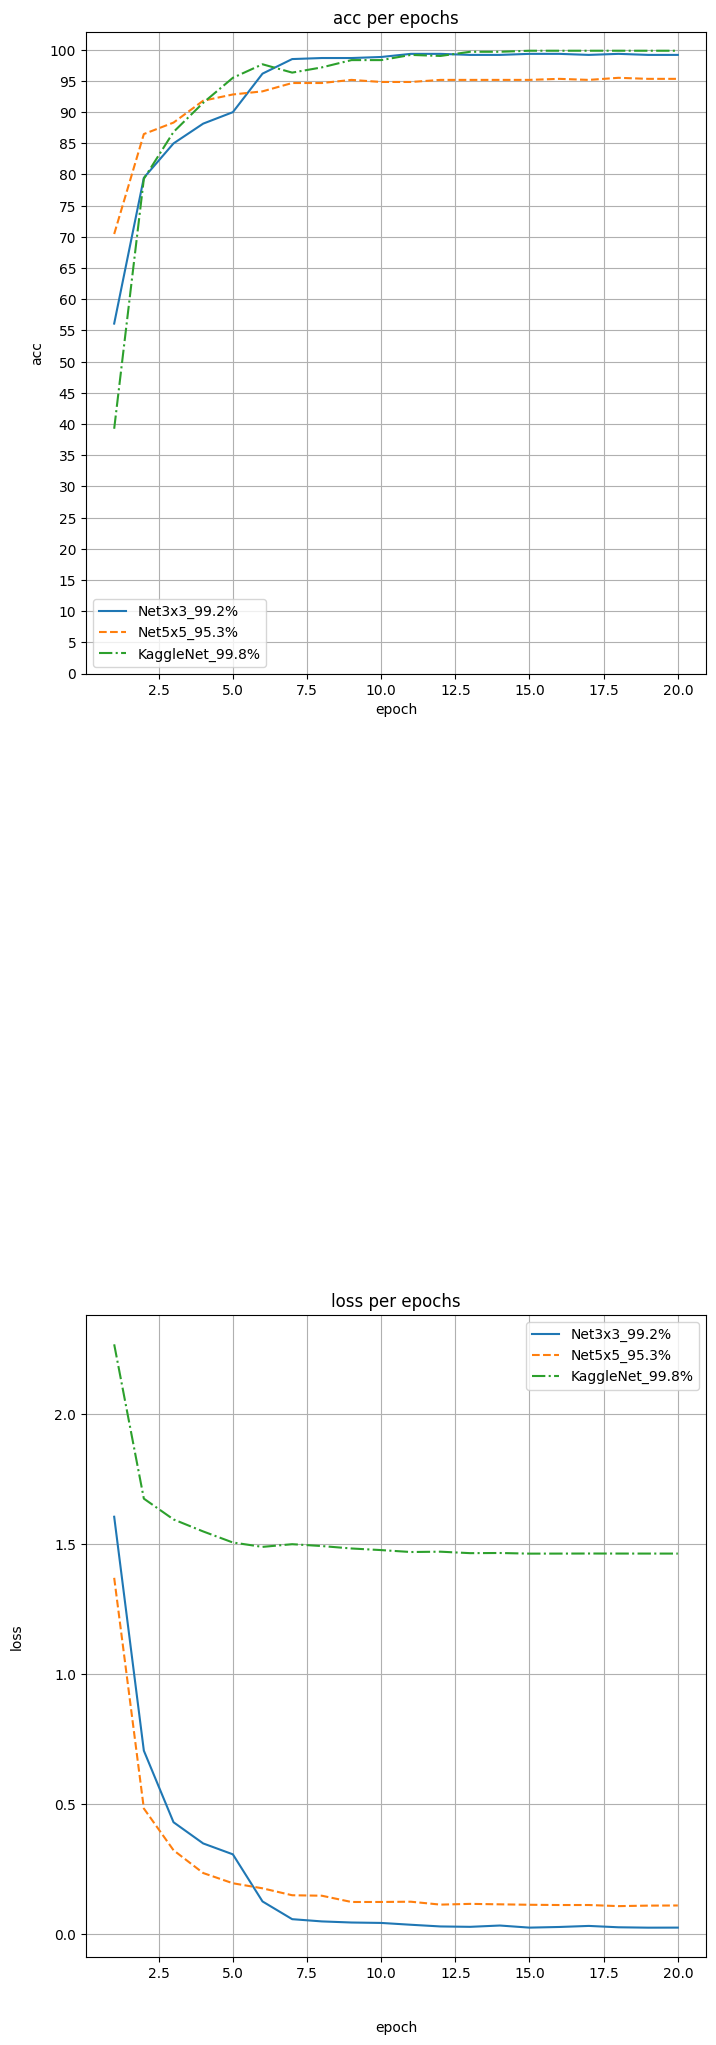

In [ ]:
plot = PlotMaker()
plot.make_arrs(name=trainer_3x3.output_fname, data=trainer_3x3.acc_loss_epoch)
plot.make_arrs(name=trainer_5x5.output_fname, data=trainer_5x5.acc_loss_epoch)
plot.make_arrs(name=trainer_KaggleNet.output_fname, data=trainer_KaggleNet.acc_loss_epoch)
plot.make_plot()

### plot by models

In [ ]:
models = [trainer_3x3, trainer_5x5, trainer_KaggleNet]
data_name=['total data', 'MNIST data', 'custom data', 'test data']
testloaders=[total_testloader, MNIST_testloader, custom_testloader, testloader]
mal = ModelAccLoss(models=models, data_name=data_name, testloaders=testloaders)

In [ ]:
class DataAccLoss:
    def __init__(self, traindata_name, models, testdata_name, testloaders, printing=True):
        self.models = models
        self.traindata_name = traindata_name
        self.testdata_name = testdata_name
        self.testloaders = testloaders
        self.printing = printing

        self.run()

    def cal_acc_loss(self):
        self.acc = {}
        self.loss = {}

        for i in range(len(self.testloaders)):
            testloader = self.testloaders[i]

            inner_acc = np.zeros((1, len(self.models)))
            inner_loss = np.zeros((1, len(self.models)))
            inner_name = []

            if self.printing:
                print(f'{self.testdata_name[i]} ----------------------------\n')

            for j in range(len(self.models)):
                model = self.models[j]
                if self.printing:
                    print(f'{model.output_fname} --------------------------')

                tester = ModelTester(testloader=testloader,
                                    criterian=nn.CrossEntropyLoss(),
                                    net=model.net)

                inner_acc[:,j] = tester.acc
                inner_loss[:,j] = tester.test_loss

            self.acc[self.testdata_name[i]] = inner_acc.tolist()[0]
            self.loss[self.testdata_name[i]] = inner_loss.tolist()[0]

        self.acc_df = pd.DataFrame(self.acc, index=self.traindata_name)
        self.loss_df = pd.DataFrame(self.loss, index=self.traindata_name)

    def plot_acc_loss(self):
        matplotlib.style.use('fivethirtyeight')
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
        plt.subplots_adjust(hspace=0.5)

        self.acc_df.plot(kind='bar', ax=axs[0])
        axs[0].set_title('acc')

        self.loss_df.plot(kind='bar', ax=axs[1])
        axs[1].set_title('loss')

        plt.show()

    def run(self):
        self.cal_acc_loss()
        self.plot_acc_loss()

# .....................................................

